# ✅ 1. Define the libraries and upload the dataset

In [1]:
# Step 1: Create a new environment
!python -m venv cleanenv

# Step 2: Activate it
# On Windows:
!cleanenv\Scripts\activate
# On Mac/Linux:
#source cleanenv/bin/activate

# Step 3: Install only what you need
!pip install numpy==1.26.4 scipy==1.13.0 scikit-learn==1.5.0 imbalanced-learn==0.13.0 tensorflow==2.18.0

Error: Command '['/kaggle/working/cleanenv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: cleanenvScriptsactivate: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-

In [2]:
# GOOD (pick one)
import torch                         # PyTorch only
# OR
import tensorflow as tf              # TensorFlow only
# OR
import jax                           # JAX only

2025-12-10 10:46:07.971976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765363568.316935      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765363568.418047      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Import TF first so cuDNN is registered once
import tensorflow as tf
import torch

In [4]:
import numpy, scipy, sklearn, imblearn, tensorflow as tf

print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("tensorflow:", tf.__version__)

numpy: 1.26.4
scipy: 1.13.0
scikit-learn: 1.5.0
imbalanced-learn: 0.13.0
tensorflow: 2.18.0


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.utils import resample
from collections import Counter

This script creates **hourly-level dynamic features** for each patient during **Ramadan** using continuous glucose monitoring (CGM) data and lifestyle metrics (activity, sleep, physiology) from wearable devices.
It’s part of a preprocessing pipeline for modeling glucose behavior and hypoglycemia risk.

Here’s a complete explanation 👇

---

## 🧩 **Overall Goal**

To transform raw timestamped CGM and wearable data into **hourly summarized features** that represent glucose dynamics, lifestyle behavior, and physiological activity during Ramadan — ready for statistical or machine-learning analysis.

---

## 🧭 **1️⃣ Load and Parse Data**

* Loads the file:

  ```
  intraday_with_visits.csv
  ```

  which includes per-minute or per-sample CGM and Huawei sensor data.
* Converts all timestamps (`start`, `date`) to datetime format.
* Extracts:

  * `hour` → the nearest hour (e.g., 14:00, 15:00).
  * `hour_of_day` → the hour index (0–23).

👉 *Purpose:* Prepare a unified hourly timeline for every patient.

---

## 📆 **2️⃣ Filter for Ramadan Period**

* Keeps only data between **March 22 – April 19, 2023**.
* Ensures the dataset includes `cgm` readings (continuous glucose values).
* Adds a **binary flag `hypo`** = `True` when CGM ≤ 70 mg/dL (hypoglycemia reading).

👉 *Purpose:* Focus analysis strictly on the fasting month, removing other phases.

---

## ⏱ **3️⃣ Validate Hourly Windows**

* Keeps only hours with **≥4 CGM readings** to ensure data quality.
* This removes incomplete or sparse hours.

👉 *Purpose:* Guarantee each hourly feature represents stable glucose behavior.

---

## 📊 **4️⃣ Compute Hourly CGM Statistics**

For each patient and hour:

* `cgm_min` → minimum glucose value
* `cgm_max` → maximum glucose value
* `cgm_mean` → mean glucose level
* `cgm_std` → standard deviation (glucose variability)

Also adds:

* `hypo_label` → `1` if any CGM reading in that hour was ≤70 mg/dL.

👉 *Purpose:* Capture both variability and hypoglycemia presence within each hour.

---

## 🧮 **5️⃣ Composite Glucose Features**

Creates two derived indicators:

* `cgm_mean_plus_std`  → average + variability
* `cgm_mean_minus_std` → average – variability

👉 *Purpose:* Encode range boundaries for dynamic glucose variation.

---

## 🧠 **6️⃣ PCA on CGM Variables**

* Runs **Principal Component Analysis (PCA)** on `[cgm_min, cgm_max, cgm_mean, cgm_std]`.
* Extracts **3 principal components** (`pca_cgm1`, `pca_cgm2`, `pca_cgm3`).
* Reports explained variance (usually >95%).

👉 *Purpose:* Compress CGM dynamics into orthogonal, interpretable axes — summarizing glucose pattern, amplitude, and variability.

---

## 🏃‍♀️ **7️⃣ PCA on Lifestyle / Activity / Sleep Features**

* Selects available columns:

  ```
  steps, distance, calories, heart_rate, spo2, deep, light, rem, nap, awake
  ```
* Averages these per hour per patient.
* Runs PCA → extracts **3 lifestyle components**:

  * `pc1_activity_energy` → overall activity/energy output
  * `pc2_physiology` → physiological or heart-rate–related factors
  * `pc3_sleep_rest` → rest and sleep quality indices
* Reports explained variance ratio.

👉 *Purpose:* Reduce multiple wearable signals into interpretable latent factors.

---

## 📑 **8️⃣ Finalize and Sort**

* Orders the dataset by patient and hour.
* Keeps only relevant feature columns:

  ```
  cgm_min, cgm_max, cgm_mean, cgm_std,
  cgm_mean_plus_std, cgm_mean_minus_std,
  pca_cgm1–3, pc1_activity_energy, pc2_physiology, pc3_sleep_rest, hypo_label
  ```
* Prints a preview of the final dataset.

---

## 💾 **9️⃣ Save Hourly Feature File**

Exports the final hourly-level dataset to:

```
/kaggle/working/dynamic_hourly_features_ramadan.csv
```

Each row now represents **one patient-hour** with fully engineered glucose and lifestyle features.

---

## ✅ **Summary in One Line**

> This code aggregates intraday CGM and wearable sensor data into **hourly-level Ramadan features**, computing glucose statistics, detecting hypoglycemia, and summarizing glucose and lifestyle variability using **PCA-derived composite components** — producing a clean, feature-rich dataset for modeling hourly glucose dynamics during fasting.


In [6]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA

# =========================
# CONFIG
# =========================
CSV_PATH = "/kaggle/input/hmcdataset/intraday_with_visits.csv"  # ✅ update path if needed
OUT_HOURLY_CSV = "/kaggle/working/dynamic_hourly_features_ramadan.csv"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")

# =========================
# STEP 0: Load & prepare data
# =========================
df = pd.read_csv(CSV_PATH)

# Parse timestamps
df["start"] = pd.to_datetime(df["start"], errors="coerce")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["hour"] = df["start"].dt.floor("h")
df["hour_of_day"] = df["start"].dt.hour

# Numeric conversion
for col in df.columns:
    if col not in ["patientID", "huaweiID", "visit_assigned", "period_main", "start", "date", "hour", "hour_of_day"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# =========================
# STEP 0.1: Ramadan filter
# =========================
df = df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

# Ensure CGM exists
if "cgm" not in df.columns:
    raise ValueError("❌ Dataset must include 'cgm' column.")
df_cgm = df.dropna(subset=["cgm"]).copy()

# Hypo reading flag (<= 70 mg/dL)
df_cgm["hypo"] = df_cgm["cgm"] <= 70

# =========================
# STEP 1: Filter valid hours (≥4 CGM readings)
# =========================
valid_hours = (
    df_cgm.groupby(["patientID", "hour"])
    .filter(lambda g: g["cgm"].notna().sum() >= 4)
)

# =========================
# STEP 2: Compute hourly CGM statistics
# =========================
hourly_features = (
    valid_hours
    .groupby(["patientID", "hour_of_day", "hour"], as_index=False)
    .agg(
        cgm_min=("cgm", "min"),
        cgm_max=("cgm", "max"),
        cgm_mean=("cgm", "mean"),
        cgm_std=("cgm", "std")
    )
)

# Hypoglycemia label per hour
hypo_per_hour = (
    valid_hours.groupby(["patientID", "hour"])["cgm"]
    .apply(lambda x: (x < 70).any())
    .reset_index(name="hypo_label")
)
hourly_features = hourly_features.merge(hypo_per_hour, on=["patientID", "hour"], how="left")

# =========================
# STEP 3: Composite CGM features
# =========================
hourly_features["cgm_mean_plus_std"] = hourly_features["cgm_mean"] + hourly_features["cgm_std"]
hourly_features["cgm_mean_minus_std"] = hourly_features["cgm_mean"] - hourly_features["cgm_std"]

# =========================
# STEP 4: PCA on CGM stats → 3 components
# =========================
pca_input_cgm = hourly_features[["cgm_min", "cgm_max", "cgm_mean", "cgm_std"]].fillna(0)
pca_cgm = PCA(n_components=3, random_state=42)
cgm_components = pca_cgm.fit_transform(pca_input_cgm)

hourly_features["pca_cgm1"] = cgm_components[:, 0]
hourly_features["pca_cgm2"] = cgm_components[:, 1]
hourly_features["pca_cgm3"] = cgm_components[:, 2]

print("CGM PCA explained variance:", pca_cgm.explained_variance_ratio_.round(3))

# =========================
# STEP 5: PCA on lifestyle/activity/sleep features
# =========================
lifestyle_cols = ["steps", "distance", "calories", "heart_rate", "spo2",
                  "deep", "light", "rem", "nap", "awake"]
lifestyle_cols = [c for c in lifestyle_cols if c in df_cgm.columns]

if lifestyle_cols:
    lifestyle_hourly = (
        df_cgm.groupby(["patientID", "hour"], as_index=False)[lifestyle_cols]
        .mean()
        .fillna(0)
    )

    # Merge lifestyle into hourly_features
    hourly_features = hourly_features.merge(
        lifestyle_hourly, on=["patientID", "hour"], how="left"
    ).fillna(0)

    # Run PCA
    pca_life = PCA(n_components=3, random_state=42)
    life_components = pca_life.fit_transform(hourly_features[lifestyle_cols])

    hourly_features["pc1_activity_energy"] = life_components[:, 0]
    hourly_features["pc2_physiology"] = life_components[:, 1]
    hourly_features["pc3_sleep_rest"] = life_components[:, 2]

    print("Lifestyle PCA explained variance:", pca_life.explained_variance_ratio_.round(3))

# =========================
# STEP 6: Finalize dataset
# =========================
hourly_features = hourly_features.sort_values(["patientID", "hour"]).reset_index(drop=True)

DYNAMIC_FEATURES = [
    "cgm_min", "cgm_max", "cgm_mean", "cgm_std",
    "cgm_mean_plus_std", "cgm_mean_minus_std",
    "pca_cgm1", "pca_cgm2", "pca_cgm3",
    "pc1_activity_energy", "pc2_physiology", "pc3_sleep_rest"
]

print(hourly_features[["patientID", "hour"] + DYNAMIC_FEATURES + ["hypo_label"]].head())


CGM PCA explained variance: [0.957 0.041 0.001]
Lifestyle PCA explained variance: [0.883 0.09  0.017]
   patientID                hour  cgm_min  cgm_max    cgm_mean    cgm_std  \
0         45 2023-03-22 00:00:00    216.0    238.0  229.916667   8.262273   
1         45 2023-03-22 01:00:00    184.0    216.0  203.916667  10.933338   
2         45 2023-03-22 02:00:00    169.0    189.0  178.500000   7.025926   
3         45 2023-03-22 03:00:00    127.0    175.0  153.916667  15.814023   
4         45 2023-03-22 04:00:00    116.0    146.0  132.750000  10.712143   

   cgm_mean_plus_std  cgm_mean_minus_std    pca_cgm1   pca_cgm2  pca_cgm3  \
0         238.178939          221.654394  122.152519  17.134021  1.320985   
1         214.850005          192.983329   76.456542   7.109642  2.654828   
2         185.525926          171.474074   37.052310  14.231018 -0.777581   
3         169.730690          138.102643   -8.187737  -9.873286  2.767731   
4         143.462143          122.037857  -44.2081

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


# Leak-safe All static visist and hourly Ramadan features + Balanced LSTM
(hourly builder + sequences + training utilities)Below is a single, leak‑safe end‑to‑end script that:

Robustly detects patient/date/variable/value columns (handles headers like PatientID (Huawei Data)).

Splits by patient first, then fits PCA & scalers on TRAIN only.

Builds sequences with optional per‑patient static features.

Trains LSTM variants with class‑weighted focal loss and optional resampling.

Chooses decision thresholds on the VALIDATION set (not the test set) to avoid peeking.

Evaluates on test and writes plots + a summary CSV.

What changed vs your last version

Added flexible column pickers (_pick_patient_col, _pick_date_col, …) and used them everywhere (intraday, visit, static).

Thresholds now picked on VAL (Youden and PR‑F1) → no test leakage.

Balanced test creation returns X_stat_bal too (keeps seq+static aligned).

Resampling with SMOTE is skipped automatically when static input is enabled (can’t synthesize static safely).

⚠️ VISIT_WIDE_CSV found but none of the needed visit columns present; will try LONG if available.
⚠️ VISIT_LONG_CSV present but none of the needed variables were found in the pivot.
⚠️ No usable visit CSVs found; visit features will be zero-filled.
ℹ️ static: using patientID column = 'PatientID (Huawei Data)'
✅ Saved hourly features (leak-safe) → /kaggle/working/dynamic_hourly_features_ramadan.csv
✅ Sequences built | train=(12870, 36, 8), val=(1991, 36, 8), test=(3638, 36, 8)
💾 Saved sequences → /kaggle/working/sequences_leakfree.npz

🔁 Resampling: none | train y-dist = Counter({0: 12266, 1: 604})


I0000 00:00:1765363608.371414      21 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/12


I0000 00:00:1765363613.999299      77 cuda_dnn.cc:529] Loaded cuDNN version 90300


403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8328 - loss: 0.0295

403/403 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8329 - loss: 0.0295 - val_accuracy: 0.9056 - val_loss: 0.0076
Epoch 2/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8789 - loss: 0.0141

403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8789 - loss: 0.0141 - val_accuracy: 0.9277 - val_loss: 0.0055
Epoch 3/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8971 - loss: 0.0115

403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8971 - loss: 0.0115 - val_accuracy: 0.9307 - val_loss: 0.0054
Epoch 4/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9050 - loss: 0.0106 - val_accuracy: 0.9372 - val_loss: 0.0056
Epoch 5/12
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9094 - loss: 0.0100

403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9094 - loss: 0.0100 - val_accuracy: 0.9392 - val_loss: 0.0050
Epoch 6/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9085 - loss: 0.0096 - val_accuracy: 0.9196 - val_loss: 0.0057
Epoch 7/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9044 - loss: 0.0092 - val_accuracy: 0.9237 - val_loss: 0.0054
Epoch 8/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9142 - loss: 0.0089 - val_accuracy: 0.9216 - val_loss: 0.0056
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
📌 [none/LSTM_100] VAL thresholds → Youden=0.4044, PR-F1=0.5955 (window [0.4,0.6])
Epoch 1/12
400/403 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8897 - loss: 0.0247

403/403 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8896 - loss: 0.0247 - val_accuracy: 0.9036 - val_loss: 0.0070
Epoch 2/12
400/403 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8736 - loss: 0.0132

403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8737 - loss: 0.0132 - val_accuracy: 0.9166 - val_loss: 0.0062
Epoch 3/12
401/403 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8933 - loss: 0.0112

403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8933 - loss: 0.0112 - val_accuracy: 0.9412 - val_loss: 0.0050
Epoch 4/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9002 - loss: 0.0103

403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9002 - loss: 0.0103 - val_accuracy: 0.9392 - val_loss: 0.0049
Epoch 5/12
401/403 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9050 - loss: 0.0094

403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9050 - loss: 0.0094 - val_accuracy: 0.9397 - val_loss: 0.0047
Epoch 6/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9092 - loss: 0.0088 - val_accuracy: 0.9302 - val_loss: 0.0053
Epoch 7/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9100 - loss: 0.0085 - val_accuracy: 0.9287 - val_loss: 0.0054
Epoch 8/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9121 - loss: 0.0081 - val_accuracy: 0.9322 - val_loss: 0.0050
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
📌 [none/BiLSTM] VAL thresholds → Youden=0.4014, PR-F1=0.5627 (window [0.4,0.6])
Epoch 1/12
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8579 - loss: 0.0284

403/403 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8581 - loss: 0.0284 - val_accuracy: 0.9598 - val_loss: 0.0098
Epoch 2/12
402/403 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8890 - loss: 0.0190

403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8890 - loss: 0.0190 - val_accuracy: 0.9026 - val_loss: 0.0063
Epoch 3/12
399/403 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8883 - loss: 0.0123

403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8883 - loss: 0.0123 - val_accuracy: 0.9206 - val_loss: 0.0054
Epoch 4/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9003 - loss: 0.0110

403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9003 - loss: 0.0110 - val_accuracy: 0.9302 - val_loss: 0.0050
Epoch 5/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9041 - loss: 0.0108 - val_accuracy: 0.9322 - val_loss: 0.0051
Epoch 6/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9057 - loss: 0.0102 - val_accuracy: 0.9297 - val_loss: 0.0053
Epoch 7/12
403/403 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9066 - loss: 0.0098 - val_accuracy: 0.9277 - val_loss: 0.0052
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
📌 [none/LSTM_50] VAL thresholds → Youden=0.4288, PR-F1=0.5985 (window [0.4,0.6])

🔁 Resampling: oversample_seq | train y-dist = Counter({0: 12266, 1: 604})
Epoch 1/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6553 - loss: 0.0424

767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6554 - loss: 0.0424 - val_accuracy: 0.7489 - val_loss: 0.0219
Epoch 2/12
765/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8548 - loss: 0.0127

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8548 - loss: 0.0127 - val_accuracy: 0.7961 - val_loss: 0.0198
Epoch 3/12
766/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9071 - loss: 0.0055

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9071 - loss: 0.0055 - val_accuracy: 0.8523 - val_loss: 0.0158
Epoch 4/12
762/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9334 - loss: 0.0031

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9335 - loss: 0.0031 - val_accuracy: 0.8785 - val_loss: 0.0137
Epoch 5/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9460 - loss: 0.0023

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9460 - loss: 0.0023 - val_accuracy: 0.8930 - val_loss: 0.0136
Epoch 6/12
762/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9536 - loss: 0.0018

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9536 - loss: 0.0018 - val_accuracy: 0.8965 - val_loss: 0.0132
Epoch 7/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9631 - loss: 0.0012 - val_accuracy: 0.9086 - val_loss: 0.0146
Epoch 8/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9637 - loss: 0.0011 - val_accuracy: 0.9121 - val_loss: 0.0141
Epoch 9/12
765/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9699 - loss: 9.1157e-04

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9699 - loss: 9.1280e-04 - val_accuracy: 0.9051 - val_loss: 0.0128
Epoch 10/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9719 - loss: 7.7717e-04 - val_accuracy: 0.9191 - val_loss: 0.0142
Epoch 11/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9795 - loss: 4.9262e-04 - val_accuracy: 0.8990 - val_loss: 0.0141
Epoch 12/12
765/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9700 - loss: 8.8756e-04

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9701 - loss: 8.8707e-04 - val_accuracy: 0.9232 - val_loss: 0.0127
Restoring model weights from the end of the best epoch: 12.
📌 [oversample_seq/LSTM_100] VAL thresholds → Youden=0.5127, PR-F1=0.5918 (window [0.4,0.6])
Epoch 1/12
764/767 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6902 - loss: 0.0422

767/767 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6906 - loss: 0.0422 - val_accuracy: 0.7413 - val_loss: 0.0238
Epoch 2/12
764/767 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8559 - loss: 0.0120

767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8559 - loss: 0.0120 - val_accuracy: 0.7901 - val_loss: 0.0195
Epoch 3/12
764/767 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9046 - loss: 0.0056

767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9046 - loss: 0.0056 - val_accuracy: 0.8774 - val_loss: 0.0144
Epoch 4/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9278 - loss: 0.0035 - val_accuracy: 0.8845 - val_loss: 0.0181
Epoch 5/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9402 - loss: 0.0025 - val_accuracy: 0.8709 - val_loss: 0.0202
Epoch 6/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9488 - loss: 0.0019 - val_accuracy: 0.8995 - val_loss: 0.0194
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
📌 [oversample_seq/BiLSTM] VAL thresholds → Youden=0.4032, PR-F1=0.5930 (window [0.4,0.6])
Epoch 1/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6436 - loss: 0.0461

767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6437 - loss: 0.0461 - val_accuracy: 0.7238 - val_loss: 0.0268
Epoch 2/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8358 - loss: 0.0163 - val_accuracy: 0.7393 - val_loss: 0.0290
Epoch 3/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8702 - loss: 0.0102

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8703 - loss: 0.0102 - val_accuracy: 0.7981 - val_loss: 0.0216
Epoch 4/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9040 - loss: 0.0060 - val_accuracy: 0.8086 - val_loss: 0.0229
Epoch 5/12
761/767 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9161 - loss: 0.0046

767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9161 - loss: 0.0046 - val_accuracy: 0.8453 - val_loss: 0.0196
Epoch 6/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9281 - loss: 0.0036 - val_accuracy: 0.8564 - val_loss: 0.0204
Epoch 7/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9387 - loss: 0.0028 - val_accuracy: 0.8533 - val_loss: 0.0229
Epoch 8/12
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9420 - loss: 0.0025 - val_accuracy: 0.8719 - val_loss: 0.0220
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
📌 [oversample_seq/LSTM_50] VAL thresholds → Youden=0.4039, PR-F1=0.5456 (window [0.4,0.6])

🔁 Resampling: undersample_seq | train y-dist = Counter({0: 12266, 1: 604})
Epoch 1/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5086 - loss: 0.0866

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5091 - loss: 0.0859 - val_accuracy: 0.0402 - val_loss: 0.0960
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5240 - loss: 0.0567 - val_accuracy: 0.0402 - val_loss: 0.0986
Epoch 3/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5858 - loss: 0.0522

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5852 - loss: 0.0521 - val_accuracy: 0.0457 - val_loss: 0.0931
Epoch 4/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5814 - loss: 0.0485

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5817 - loss: 0.0485 - val_accuracy: 0.1361 - val_loss: 0.0840
Epoch 5/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6318 - loss: 0.0428

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6328 - loss: 0.0428 - val_accuracy: 0.2923 - val_loss: 0.0823
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6998 - loss: 0.0355 - val_accuracy: 0.3230 - val_loss: 0.0886
Epoch 7/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7448 - loss: 0.0297

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7459 - loss: 0.0296 - val_accuracy: 0.6344 - val_loss: 0.0407
Epoch 8/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7847 - loss: 0.0241

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7846 - loss: 0.0241 - val_accuracy: 0.6816 - val_loss: 0.0334
Epoch 9/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8062 - loss: 0.0218

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8059 - loss: 0.0219 - val_accuracy: 0.7273 - val_loss: 0.0264
Epoch 10/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7953 - loss: 0.0218 - val_accuracy: 0.6364 - val_loss: 0.0396
Epoch 11/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8131 - loss: 0.0199 - val_accuracy: 0.6811 - val_loss: 0.0324
Epoch 12/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8157 - loss: 0.0195 - val_accuracy: 0.6791 - val_loss: 0.0327
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 9.
📌 [undersample_seq/LSTM_100] VAL thresholds → Youden=0.5834, PR-F1=0.5834 (window [0.4,0.6])
Epoch 1/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5426 - loss: 0.0774

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5424 - loss: 0.0769 - val_accuracy: 0.0402 - val_loss: 0.0919
Epoch 2/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5506 - loss: 0.0541

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5518 - loss: 0.0539 - val_accuracy: 0.1994 - val_loss: 0.0789
Epoch 3/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6543 - loss: 0.0438

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6554 - loss: 0.0436 - val_accuracy: 0.4827 - val_loss: 0.0657
Epoch 4/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7460 - loss: 0.0321

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7462 - loss: 0.0320 - val_accuracy: 0.5173 - val_loss: 0.0593
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7798 - loss: 0.0251 - val_accuracy: 0.5203 - val_loss: 0.0662
Epoch 6/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7841 - loss: 0.0248

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7840 - loss: 0.0248 - val_accuracy: 0.5525 - val_loss: 0.0571
Epoch 7/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7890 - loss: 0.0225

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7894 - loss: 0.0225 - val_accuracy: 0.6072 - val_loss: 0.0480
Epoch 8/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8059 - loss: 0.0210

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8060 - loss: 0.0210 - val_accuracy: 0.6002 - val_loss: 0.0476
Epoch 9/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8075 - loss: 0.0196

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8079 - loss: 0.0196 - val_accuracy: 0.6339 - val_loss: 0.0399
Epoch 10/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8149 - loss: 0.0177

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8152 - loss: 0.0177 - val_accuracy: 0.6730 - val_loss: 0.0379
Epoch 11/12
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8300 - loss: 0.0168

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8300 - loss: 0.0168 - val_accuracy: 0.6816 - val_loss: 0.0356
Epoch 12/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8259 - loss: 0.0158 - val_accuracy: 0.6560 - val_loss: 0.0409
Restoring model weights from the end of the best epoch: 11.
📌 [undersample_seq/BiLSTM] VAL thresholds → Youden=0.5598, PR-F1=0.5896 (window [0.4,0.6])
Epoch 1/12
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4744 - loss: 0.0708

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4775 - loss: 0.0698 - val_accuracy: 0.0402 - val_loss: 0.0981
Epoch 2/12
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5107 - loss: 0.0563

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5117 - loss: 0.0562 - val_accuracy: 0.1231 - val_loss: 0.0880
Epoch 3/12
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5446 - loss: 0.0541

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5442 - loss: 0.0541 - val_accuracy: 0.1351 - val_loss: 0.0858
Epoch 4/12
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5563 - loss: 0.0514

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5583 - loss: 0.0513 - val_accuracy: 0.2275 - val_loss: 0.0784
Epoch 5/12
34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6274 - loss: 0.0472

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6293 - loss: 0.0471 - val_accuracy: 0.3310 - val_loss: 0.0780
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6995 - loss: 0.0377 - val_accuracy: 0.4309 - val_loss: 0.0789
Epoch 7/12
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7573 - loss: 0.0298

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7589 - loss: 0.0296 - val_accuracy: 0.6288 - val_loss: 0.0443
Epoch 8/12
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7788 - loss: 0.0263

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7796 - loss: 0.0264 - val_accuracy: 0.6354 - val_loss: 0.0421
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7746 - loss: 0.0252 - val_accuracy: 0.6308 - val_loss: 0.0441
Epoch 10/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7875 - loss: 0.0238 - val_accuracy: 0.6153 - val_loss: 0.0461
Epoch 11/12
32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7987 - loss: 0.0232

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8003 - loss: 0.0231 - val_accuracy: 0.6534 - val_loss: 0.0403
Epoch 12/12
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8076 - loss: 0.0222

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8087 - loss: 0.0222 - val_accuracy: 0.6951 - val_loss: 0.0329
Restoring model weights from the end of the best epoch: 12.
📌 [undersample_seq/LSTM_50] VAL thresholds → Youden=0.5908, PR-F1=0.5994 (window [0.4,0.6])
⏭️  Skipping smote (static input enabled).
⏭️  Skipping smoteenn (static input enabled).
⏭️  Skipping smotetomek (static input enabled).


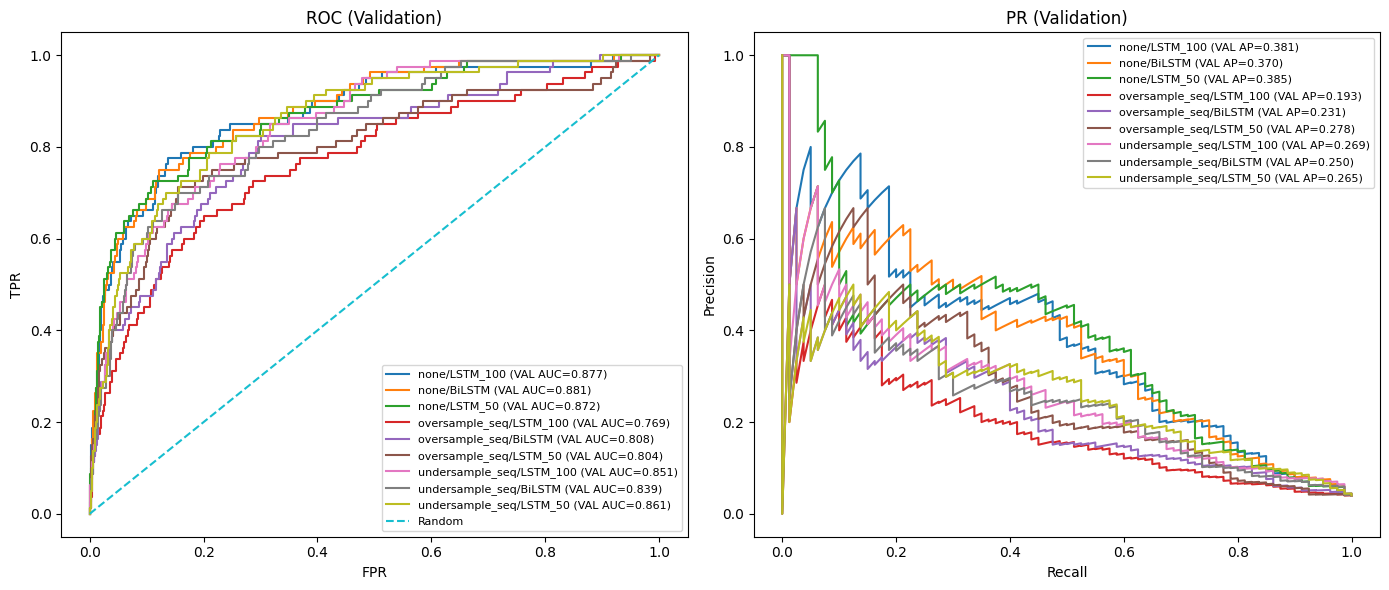

🖼️ Saved plots → /kaggle/working/combined_roc_pr_curves.png
📑 Saved results → /kaggle/working/results_summary_all.csv


In [8]:
# ==============================================
# Leak-safe Ramadan features + Balanced LSTM
# (hourly builder + sequences + training utilities)
# ==============================================
import os, time, warnings, random, re
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score, auc, mean_squared_error
)

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# --------------------
# GLOBAL CONFIG
# --------------------
# Paths (update for your environment)
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
STATIC_CSV      = "/kaggle/input/hmc-model-static-variables/outcome_static.csv"
VISIT_WIDE_CSV  = "/kaggle/input/hmc-model-static-variables/outcome_visit_wide_by_variable.csv"
VISIT_LONG_CSV  = "/kaggle/input/hmc-model-static-variables/outcome_visit_long.csv"

OUT_HOURLY_CSV  = "/kaggle/working/dynamic_hourly_features_ramadan.csv"
OUT_SEQ_NPZ     = "/kaggle/working/sequences_leakfree.npz"
OUT_RESULTS_CSV = "/kaggle/working/results_summary_all.csv"
OUT_PLOTS_PNG   = "/kaggle/working/combined_roc_pr_curves.png"

# Ramadan window and label definition
RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")
HYPO_CUTOFF   = 70.0   # mg/dL
MIN_CGM_PER_H = 4      # minimum CGM points within an hour to keep that hour
SEQ_LEN       = 36     # sliding window length (hours)

# Lifestyle candidates (if present in intraday_with_visits)
LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

# "final master" feature lists
VISIT_COLS = ["carb","meals","total_daily_dose_u","fasting_percent_29"]
STATIC_COLS = [
    "Age","Gender","BMI","HbA1C","Cholesterol","LDL","HDL","Triglycerides",
    "eGFR","Creatinine","Insulin_units_per_kg","SmartGuard_percent"
]

# Sequence features used for models (you can edit)
DEFAULT_SEQ_FEATURE_COLS = (
    "cgm_mean","cgm_std","pca_cgm1",      # CGM core + CGM PCA#1
    "pc1_activity_energy",                # lifestyle PCA#1 (0 if lifestyle missing)
    "carb","meals","total_daily_dose_u","fasting_percent_29"  # visit features
)

# Training config
RANDOM_STATE     = 42
THR_MIN, THR_MAX = 0.40, 0.60
AUGMENT_SIGMA    = 0.01   # small Gaussian jitter on train (set None to disable)
RESAMPLE_METHODS = [
    "none",            # baseline (class_weight + focal)
    "oversample_seq",  # duplicate minority sequences
    "undersample_seq", # downsample majority sequences
    # SMOTE-family below only when no static input is used
    "smote", "smoteenn", "smotetomek"
]
USE_STATIC_INPUT = True  # set False to ignore static input entirely (enables SMOTE variants safely)

# --------------------
# Utilities (robust column picking)
# --------------------
def set_global_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_global_seeds(RANDOM_STATE)

def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def safe_encode_gender(series):
    if series.dtype == "object":
        return (series.str.strip().str.lower().map({"male":1, "m":1, "female":0, "f":0}))
    return pd.to_numeric(series, errors="coerce")

def split_patients(unique_pids, test_size=0.3, val_size=0.1, random_state=RANDOM_STATE):
    train_pids, test_pids = train_test_split(unique_pids, test_size=test_size, random_state=random_state)
    val_fraction = val_size / max(1e-9, (1.0 - test_size))
    train_pids, val_pids = train_test_split(train_pids, test_size=val_fraction, random_state=random_state)
    return np.array(train_pids), np.array(val_pids), np.array(test_pids)

def _normalize_date(s):
    s = pd.to_datetime(s, errors="coerce")
    return s.dt.normalize()

# ---- robust column pickers ----
def _norm_col(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def _pick_col_flex(
    df: pd.DataFrame,
    preferred=None,
    required=False,
    name="",
    must_contain_all=None,
    any_contains=None,
):
    cols = list(df.columns)
    norm_map = {c: _norm_col(c) for c in cols}

    # (1) exact by case-insensitive preferred
    if preferred:
        lower_pref = {str(p).strip().lower(): p for p in preferred}
        for c in cols:
            if str(c).strip().lower() in lower_pref:
                return c

    # (2) exact by normalized preferred
    if preferred:
        pref_norm = {_norm_col(p): p for p in preferred}
        for c, n in norm_map.items():
            if n in pref_norm:
                return c

    # (3) heuristics on normalized names
    cands = []
    for c, n in norm_map.items():
        ok = True
        if must_contain_all:
            for tok in must_contain_all:
                if _norm_col(tok) not in n:
                    ok = False
                    break
        if ok and any_contains:
            if not any(_norm_col(tok) in n for tok in any_contains):
                ok = False
        if ok:
            cands.append(c)
    if cands:
        # prioritize names starting with 'patientid' when looking for patient column
        def _priority(col: str):
            n = norm_map[col]
            starts_pid = n.startswith("patientid")
            has_pid    = "patientid" in n
            return (-(starts_pid or has_pid), len(n))
        cands.sort(key=_priority)
        return cands[0]

    if required:
        raise KeyError(
            f"Required column not found for {name}. "
            f"preferred={preferred} | must_contain_all={must_contain_all} | any_contains={any_contains}. "
            f"Available: {cols}"
        )
    return None

def _pick_patient_col(df: pd.DataFrame) -> str:
    preferred = ["patientID", "patientId", "PatientID (Huawei Data)", "subject_id", "patid", "pid", "id", "huaweiid"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="patientID",
                          must_contain_all=["id"], any_contains=["patient","subject","pat","huawei"])

def _pick_date_col(df: pd.DataFrame) -> str:
    preferred = ["date", "visit_date", "Date", "day", "timestamp", "Visit Date", "date_of_visit", "start"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="date",
                          any_contains=["date","visit","day","timestamp","start"])

def _pick_variable_col(df: pd.DataFrame) -> str:
    preferred = ["variable","var","feature","name","measure","metric"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="variable",
                          any_contains=["variable","var","feature","name","measure","metric"])

def _pick_value_col(df: pd.DataFrame) -> str:
    preferred = ["value","val","measure_value","reading","amount","score"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="value",
                          any_contains=["value","val","measurevalue","reading","amount","score"])

# ---------------------------
# Loaders for external files
# ---------------------------
def load_static_df(static_csv=STATIC_CSV, needed=STATIC_COLS):
    if not static_csv or not os.path.exists(static_csv):
        print("⚠️ Static CSV not found; static features will be zero-filled.")
        return None
    df = pd.read_csv(static_csv)
    pid_col = _pick_patient_col(df)
    df = df.rename(columns={pid_col:"patientID"})
    keep = ["patientID"] + [c for c in needed if c in df.columns]
    df = df[keep].drop_duplicates(subset=["patientID"]).copy()
    if "Gender" in df.columns:
        df["Gender"] = safe_encode_gender(df["Gender"])
    for c in keep:
        if c != "patientID":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    print(f"ℹ️ static: using patientID column = '{pid_col}'")
    return df

def load_visit_df(visit_wide_csv=VISIT_WIDE_CSV, visit_long_csv=VISIT_LONG_CSV, needed=VISIT_COLS):
    # Try wide first
    if visit_wide_csv and os.path.exists(visit_wide_csv):
        wide = pd.read_csv(visit_wide_csv)
        pid_col  = _pick_patient_col(wide)
        date_col = _pick_date_col(wide)
        wide = wide.rename(columns={pid_col:"patientID", date_col:"date"})
        wide["date"] = _normalize_date(wide["date"])
        keep = ["patientID","date"] + [c for c in needed if c in wide.columns]
        if len(keep) > 2:
            print(f"ℹ️ visit-wide: patientID='{pid_col}', date='{date_col}', kept={keep[2:]}")
            return wide[keep].copy()
        else:
            print("⚠️ VISIT_WIDE_CSV found but none of the needed visit columns present; will try LONG if available.")

    # Fallback: long -> pivot
    if visit_long_csv and os.path.exists(visit_long_csv):
        long = pd.read_csv(visit_long_csv)
        pid_col   = _pick_patient_col(long)
        date_col  = _pick_date_col(long)
        var_col   = _pick_variable_col(long)
        value_col = _pick_value_col(long)
        long = long.rename(columns={pid_col:"patientID", date_col:"date", var_col:"variable", value_col:"value"})
        long["date"] = _normalize_date(long["date"])
        wide = (long
                .pivot_table(index=["patientID","date"], columns="variable", values="value", aggfunc="mean")
                .reset_index())
        keep = ["patientID","date"] + [c for c in needed if c in wide.columns]
        if len(keep) > 2:
            print(f"ℹ️ visit-long: patientID='{pid_col}', date='{date_col}', variables matched={keep[2:]}")
            return wide[keep].copy()
        print("⚠️ VISIT_LONG_CSV present but none of the needed variables were found in the pivot.")

    print("⚠️ No usable visit CSVs found; visit features will be zero-filled.")
    return None

# ----------------------------------------------------------------
# Part A — Build hourly Ramadan features and leak‑safe transforms
# ----------------------------------------------------------------
def build_hourly_features_with_leak_safe_transforms(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H,
    test_size=0.3, val_size=0.1, random_state=RANDOM_STATE,
    static_csv=STATIC_CSV, visit_wide_csv=VISIT_WIDE_CSV, visit_long_csv=VISIT_LONG_CSV
):
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")

    # Load & parse intraday
    df = pd.read_csv(in_csv)

    # Robust patient column for intraday too
    if "patientID" not in df.columns:
        pid_col = _pick_patient_col(df)
        df = df.rename(columns={pid_col: "patientID"})
        print(f"ℹ️ intraday: using patientID column = '{pid_col}'")

    # timestamps
    start_col = "start" if "start" in df.columns else _pick_date_col(df)
    df[start_col] = to_dt(df[start_col])
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    else:
        df["date"] = pd.to_datetime(df[start_col].dt.date)
    df["hour"]       = df[start_col].dt.floor("h")
    df["hour_of_day"]= df["hour"].dt.hour

    df = ensure_numeric(df)

    # Ramadan filter
    df = df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

    # Require CGM
    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # Valid hourly windows
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # Base hourly CGM stats
    hourly = (
        valid_hours.groupby(["patientID","hour"], as_index=False)
                   .agg(
                       cgm_min=("cgm","min"),
                       cgm_max=("cgm","max"),
                       cgm_mean=("cgm","mean"),
                       cgm_std=("cgm","std")
                   )
                   .sort_values(["patientID","hour"])
                   .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # Hypo label
    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
                   .apply(lambda x: int((x < HYPO_CUTOFF).any()))
                   .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # Lifestyle hourly means (if present)
    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean().fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left")

    # Composite CGM features
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # Patient-level split (NO LEAK)
    pids = hourly["patientID"].dropna().unique()
    train_p, val_p, test_p = split_patients(pids, test_size=test_size, val_size=val_size, random_state=random_state)
    hourly["Split"] = np.where(hourly["patientID"].isin(train_p), "train",
                        np.where(hourly["patientID"].isin(val_p), "val", "test"))

    # CGM PCA fit on TRAIN only
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    tr_mask  = hourly["Split"] == "train"
    scal_cgm = StandardScaler().fit(hourly.loc[tr_mask, cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=random_state).fit(
        scal_cgm.transform(hourly.loc[tr_mask, cgm_cols].fillna(0.0))
    )
    def _apply_cgm_pca(df_in):
        X = scal_cgm.transform(df_in[cgm_cols].fillna(0.0))
        Z = pca_cgm.transform(X)
        out = df_in.copy()
        out["pca_cgm1"], out["pca_cgm2"], out["pca_cgm3"] = Z[:,0], Z[:,1], Z[:,2]
        return out
    hourly = _apply_cgm_pca(hourly)

    # Lifestyle PCA fit on TRAIN only
    if lifestyle_cols:
        scal_life = StandardScaler().fit(hourly.loc[tr_mask, lifestyle_cols].fillna(0.0))
        pca_life  = PCA(n_components=3, random_state=random_state).fit(
            scal_life.transform(hourly.loc[tr_mask, lifestyle_cols].fillna(0.0))
        )
        X_all = scal_life.transform(hourly[lifestyle_cols].fillna(0.0))
        Z_all = pca_life.transform(X_all)
        hourly["pc1_activity_energy"] = Z_all[:,0]
        hourly["pc2_physiology"]      = Z_all[:,1]
        hourly["pc3_sleep_rest"]      = Z_all[:,2]
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # Merge VISIT features (daily)
    visit_df = load_visit_df(visit_wide_csv, visit_long_csv, VISIT_COLS)
    hourly["date"] = hourly["hour"].dt.normalize()
    if visit_df is not None:
        visit_df["date"] = pd.to_datetime(visit_df["date"], errors="coerce").dt.normalize()
        visit_df = visit_df[(visit_df["date"] >= RAMADAN_START) & (visit_df["date"] <= RAMADAN_END)].copy()
        hourly = hourly.merge(visit_df, on=["patientID","date"], how="left")
    for c in VISIT_COLS:
        if c not in hourly.columns:
            hourly[c] = 0.0
        hourly[c] = pd.to_numeric(hourly[c], errors="coerce").fillna(0.0)

    # Merge STATIC features (per patient)
    static_df = load_static_df(static_csv, STATIC_COLS)
    if static_df is not None:
        hourly = hourly.merge(static_df, on="patientID", how="left")
    for c in STATIC_COLS:
        if c not in hourly.columns:
            hourly[c] = 0.0
        hourly[c] = pd.to_numeric(hourly[c], errors="coerce").fillna(0.0)

    # Save hourly table
    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly.to_csv(out_csv, index=False)
    print(f"✅ Saved hourly features (leak-safe) → {out_csv}")

    return hourly, (train_p, val_p, test_p)

# ---------------------------------------------------------------
# Part B — Build sequences (optionally with per-patient static)
# ---------------------------------------------------------------
def build_sequences_by_split(
    hourly, splits, seq_len=SEQ_LEN,
    seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
    static_cols=STATIC_COLS,
    scale_features=True
):
    for c in ["patientID","hour","hypo_label","Split"]:
        if c not in hourly.columns:
            raise KeyError(f"hourly missing required column: {c}")
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")

    seq_feature_cols = list(seq_feature_cols)
    missing_seq = [c for c in seq_feature_cols if c not in hourly.columns]
    if missing_seq:
        raise KeyError(f"Sequence feature(s) not found in hourly: {missing_seq}")

    static_cols_present = [c for c in static_cols if c in hourly.columns]
    if static_cols_present and USE_STATIC_INPUT:
        static_mat = (hourly[["patientID"] + static_cols_present]
                      .drop_duplicates(subset=["patientID"])
                      .set_index("patientID")
                      .astype(float).fillna(0.0))
    else:
        static_mat = None
        static_cols_present = []

    train_p, val_p, test_p = splits

    def _build_for_pidset(pid_set):
        sub = hourly[hourly["patientID"].isin(pid_set)].copy()
        X_seq, X_stat, y = [], [], []
        for pid, grp in sub.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            if len(grp) <= seq_len:
                continue
            feats  = grp[seq_feature_cols].astype(float).values
            labels = grp["hypo_label"].astype(int).values
            for i in range(len(grp) - seq_len):
                X_seq.append(feats[i:i+seq_len]); y.append(labels[i+seq_len])
                if static_mat is not None and pid in static_mat.index:
                    X_stat.append(static_mat.loc[pid].values.astype(float))
        X_seq = np.array(X_seq); y = np.array(y).astype(int)
        X_stat = np.array(X_stat) if (static_mat is not None and len(X_stat)>0) else None
        return X_seq, X_stat, y

    Xtr_s, Xtr_stat, ytr = _build_for_pidset(train_p)
    Xva_s, Xva_stat, yva = _build_for_pidset(val_p)
    Xte_s, Xte_stat, yte = _build_for_pidset(test_p)

    # Scale sequence features (fit on TRAIN only), and static (fit on TRAIN only)
    seq_scaler  = None
    stat_scaler = None
    if scale_features and Xtr_s.size > 0:
        n_f = Xtr_s.shape[2]
        seq_scaler = StandardScaler().fit(Xtr_s.reshape(-1, n_f))
        def _scale_seq(X):
            if X is None or X.size==0: return X
            n = X.shape[0]; return seq_scaler.transform(X.reshape(-1, n_f)).reshape(n, SEQ_LEN, n_f)
        Xtr_s = _scale_seq(Xtr_s); Xva_s = _scale_seq(Xva_s); Xte_s = _scale_seq(Xte_s)

    if scale_features and Xtr_stat is not None and Xtr_stat.size>0:
        stat_scaler = StandardScaler().fit(Xtr_stat)
        def _scale_stat(X):
            if X is None or X.size==0: return X
            return stat_scaler.transform(X)
        Xtr_stat = _scale_stat(Xtr_stat); Xva_stat = _scale_stat(Xva_stat); Xte_stat = _scale_stat(Xte_stat)

    print(f"✅ Sequences built | train={Xtr_s.shape}, val={Xva_s.shape}, test={Xte_s.shape}")
    return {
        "train": {"X_seq": Xtr_s, "X_stat": Xtr_stat, "y": ytr},
        "val":   {"X_seq": Xva_s, "X_stat": Xva_stat, "y": yva},
        "test":  {"X_seq": Xte_s, "X_stat": Xte_stat, "y": yte},
        "seq_features_used": seq_feature_cols,
        "static_features_used": static_cols_present,
        "scalers": {"seq": seq_scaler, "stat": stat_scaler}
    }

# ------------------------------------------------------
# Balanced LSTM pipeline utilities (metrics, resampling)
# ------------------------------------------------------
THR_MIN, THR_MAX = THR_MIN, THR_MAX  # keep constants visible here

def _best_threshold_in_range(thresholds, scores, thr_min=THR_MIN, thr_max=THR_MAX):
    thresholds = np.asarray(thresholds, dtype=float)
    scores     = np.asarray(scores, dtype=float)
    mask = np.isfinite(thresholds) & (thresholds >= thr_min) & (thresholds <= thr_max)
    if mask.any():
        idx_in = int(np.nanargmax(scores[mask])); idx = np.where(mask)[0][idx_in]
        return float(thresholds[idx]), True
    idx = int(np.nanargmax(scores))
    return float(np.clip(thresholds[idx], thr_min, thr_max)), False

def focal_loss(gamma=2.0, alpha=0.8):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def _safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape != (2,2):
        full = np.zeros((2,2), dtype=int)
        full[:cm.shape[0], :cm.shape[1]] = cm
        cm = full
    return cm

def _specificity_overall(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def _specificity_per_class(y_true, y_pred, positive_label):
    y_true_bin = (np.asarray(y_true).ravel() == positive_label).astype(int)
    y_pred_bin = (np.asarray(y_pred).ravel() == positive_label).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def evaluate_full_metrics(y_true, y_pred, y_prob=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_pred = np.asarray(y_pred).astype(int).ravel()
    cm = _safe_confusion_matrix(y_true, y_pred)

    metrics = {}
    for lbl in [0,1]:
        metrics[f"Class{lbl}/Precision"]   = precision_score(y_true, y_pred, pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Recall"]      = recall_score(y_true, y_pred,    pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/F1"]          = f1_score(y_true, y_pred,        pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Specificity"] = _specificity_per_class(y_true, y_pred, positive_label=lbl)
        metrics[f"Class{lbl}/Support"]     = int(np.sum(y_true == lbl))

    metrics["Overall/Accuracy"]             = accuracy_score(y_true, y_pred)
    metrics["Overall/Precision_macro"]      = precision_score(y_true, y_pred, average='macro',    zero_division=0)
    metrics["Overall/Precision_weighted"]   = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics["Overall/Recall_macro"]         = recall_score(y_true, y_pred,    average='macro',    zero_division=0)
    metrics["Overall/Recall_weighted"]      = recall_score(y_true, y_pred,    average='weighted', zero_division=0)
    metrics["Overall/F1_macro"]             = f1_score(y_true, y_pred,        average='macro',    zero_division=0)
    metrics["Overall/F1_weighted"]          = f1_score(y_true, y_pred,        average='weighted', zero_division=0)
    metrics["Overall/Specificity"]          = _specificity_overall(y_true, y_pred)
    mse_pred                                = mean_squared_error(y_true, y_pred)
    metrics["Overall/MSE_pred"]             = mse_pred
    metrics["Overall/RMSE_pred"]            = float(np.sqrt(mse_pred))

    if y_prob is not None:
        y_prob = np.asarray(y_prob, dtype=float).ravel()
        try:  metrics["Overall/ROC-AUC"] = roc_auc_score(y_true, y_prob)
        except ValueError: metrics["Overall/ROC-AUC"] = np.nan
        try:  metrics["Overall/PR-AUC"]  = average_precision_score(y_true, y_prob)
        except ValueError: metrics["Overall/PR-AUC"] = np.nan
        mse_prob                          = mean_squared_error(y_true, y_prob)
        metrics["Overall/MSE_prob"]       = mse_prob
        metrics["Overall/RMSE_prob"]      = float(np.sqrt(mse_prob))
    else:
        metrics["Overall/ROC-AUC"]  = np.nan
        metrics["Overall/PR-AUC"]   = np.nan
        metrics["Overall/MSE_prob"] = np.nan
        metrics["Overall/RMSE_prob"]= np.nan
    return metrics

def make_class_weight(y):
    y  = np.asarray(y).astype(int).ravel()
    n0 = max(1, (y==0).sum()); n1 = max(1, (y==1).sum()); N = n0+n1
    w0 = N/(2.0*n0); w1 = N/(2.0*n1)
    return {0: float(w0), 1: float(w1)}

def augment_with_static(X_seq, X_stat, y, sigma=AUGMENT_SIGMA):
    if sigma is None or sigma <= 0:
        return X_seq, X_stat, y
    noise = np.random.normal(0, sigma, X_seq.shape)
    X_seq_aug = np.vstack([X_seq, X_seq + noise])
    y_aug     = np.hstack([y, y])
    if X_stat is not None:
        X_stat_aug = np.vstack([X_stat, X_stat])
    else:
        X_stat_aug = None
    return X_seq_aug, X_stat_aug, y_aug

def seq_resample(X, y, method="none", random_state=RANDOM_STATE, return_index=False, allow_smote=True):
    """
    Sequence-level resampling. If return_index=True, also returns the index mapping used so
    static inputs can be resampled consistently. For SMOTE-family, index mapping isn't
    meaningful; we disable SMOTE if allow_smote=False.
    """
    X = np.asarray(X); y = np.asarray(y).astype(int).ravel()
    n, T, F = X.shape
    base_idx = np.arange(n)

    if method == "none":
        return (X, y, base_idx) if return_index else (X, y)

    if method in {"oversample_seq","undersample_seq"}:
        rng = np.random.default_rng(random_state)
        idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
        n0, n1 = len(idx0), len(idx1)
        if n0==0 or n1==0:
            return (X, y, base_idx) if return_index else (X, y)

        if method == "oversample_seq":
            if n1 < n0:
                add = rng.choice(idx1, size=n0-n1, replace=True)
                keep = np.concatenate([idx0, idx1, add])
            else:
                add = rng.choice(idx0, size=n1-n0, replace=True)
                keep = np.concatenate([idx0, idx1, add])
        else:  # undersample
            if n0 > n1:
                keep0 = rng.choice(idx0, size=n1, replace=False)
                keep  = np.concatenate([keep0, idx1])
            else:
                keep1 = rng.choice(idx1, size=n0, replace=False)
                keep  = np.concatenate([idx0, keep1])

        rng.shuffle(keep)
        Xr, yr = X[keep], y[keep]
        return (Xr, yr, keep) if return_index else (Xr, yr)

    # SMOTE family
    if not allow_smote:
        print(f"⚠️ {method} disabled when static input is used; falling back to 'none'.")
        return (X, y, base_idx) if return_index else (X, y)

    minority_n = int((y==1).sum())
    majority_n = int((y==0).sum())
    if minority_n < 2 or majority_n < 2:
        print("⚠️ Not enough samples for SMOTE/SMOTEENN/SMOTETomek; skipping resampling.")
        return (X, y, base_idx) if return_index else (X, y)

    Xf = X.reshape(n, -1)
    if method == "smote":
        k_neighbors = max(1, min(5, minority_n-1))
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        Xr, yr = sm.fit_resample(Xf, y)
    elif method == "smoteenn":
        Xr, yr = SMOTEENN(random_state=random_state).fit_resample(Xf, y)
    elif method == "smotetomek":
        Xr, yr = SMOTETomek(random_state=random_state).fit_resample(Xf, y)
    else:
        raise ValueError(f"Unknown resampling method: {method}")

    Xr = Xr.reshape(-1, T, F)
    return (Xr, yr, None) if return_index else (Xr, yr)

def make_balanced_test(X_test, y_test, X_stat=None, random_state=RANDOM_STATE):
    """Return balanced (by label) subsets of X_test, y_test, and X_stat (if given)."""
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test).astype(int).ravel()
    idx0, idx1 = np.where(y_test==0)[0], np.where(y_test==1)[0]
    if len(idx0)==0 or len(idx1)==0: 
        return (X_test, y_test, (None if X_stat is None else X_stat))
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)
    Xb, yb = X_test[keep], y_test[keep]
    Xsb = (None if X_stat is None else np.asarray(X_stat)[keep])
    return Xb, yb, Xsb

# ------------------------------------------------------
# Model builders (supports seq-only or seq+static)
# ------------------------------------------------------
def make_model(seq_len, n_seq_f, n_stat_f=0, arch="LSTM_100", lr=1e-3):
    seq_in = Input(shape=(seq_len, n_seq_f), name="seq_in")
    x = seq_in
    if arch == "BiLSTM":
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dropout(0.2)(x)
        x = Dense(16, activation="relu")(x)
    elif arch == "LSTM_50":
        x = LSTM(50, return_sequences=True)(x); x = Dropout(0.2)(x)
        x = LSTM(25)(x);                    x = Dropout(0.2)(x)
        x = Dense(10, activation="relu")(x)
    elif arch == "LSTM_25_L1":
        x = LSTM(50, return_sequences=True, kernel_regularizer=l1(1e-5))(x); x = Dropout(0.2)(x)
        x = LSTM(25, kernel_regularizer=l1(1e-5))(x);                        x = Dropout(0.2)(x)
        x = Dense(10, activation="relu", kernel_regularizer=l1(1e-5))(x)
    elif arch == "LSTM_25_L2":
        x = LSTM(50, return_sequences=True, kernel_regularizer=l2(1e-5))(x); x = Dropout(0.2)(x)
        x = LSTM(25, kernel_regularizer=l2(1e-5))(x);                        x = Dropout(0.2)(x)
        x = Dense(10, activation="relu", kernel_regularizer=l2(1e-5))(x)
    else:  # LSTM_100
        x = LSTM(100, return_sequences=True)(x); x = Dropout(0.2)(x)
        x = LSTM(50)(x);                          x = Dropout(0.2)(x)
        x = Dense(25, activation="relu")(x)

    if n_stat_f and n_stat_f > 0 and USE_STATIC_INPUT:
        stat_in = Input(shape=(n_stat_f,), name="stat_in")
        s = Dense(32, activation="relu")(stat_in)
        s = Dropout(0.2)(s)
        h = Concatenate()([x, s])
        h = Dense(32, activation="relu")(h)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=[seq_in, stat_in], outputs=out)
    else:
        h = Dense(32, activation="relu")(x)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=seq_in, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=focal_loss(), metrics=["accuracy"])
    return model

# ------------------------------------------------------
# Training runner (VAL for threshold; TEST for final)
# ------------------------------------------------------
def run_balanced_lstm_pipeline(data,
                               arch_list=("LSTM_100","BiLSTM","LSTM_50"),
                               resample_methods=RESAMPLE_METHODS,
                               thr_min=THR_MIN, thr_max=THR_MAX,
                               random_state=RANDOM_STATE,
                               results_csv=OUT_RESULTS_CSV,
                               plots_png=OUT_PLOTS_PNG):
    os.makedirs(os.path.dirname(results_csv), exist_ok=True)
    os.makedirs(os.path.dirname(plots_png), exist_ok=True)
    os.makedirs("checkpoints", exist_ok=True)

    Xtr, Xtr_stat, ytr = data["train"]["X_seq"], data["train"]["X_stat"], data["train"]["y"]
    Xva, Xva_stat, yva = data["val"]["X_seq"],   data["val"]["X_stat"],   data["val"]["y"]
    Xte, Xte_stat, yte = data["test"]["X_seq"],  data["test"]["X_stat"],  data["test"]["y"]

    # Augment train (and static if present)
    Xtr, Xtr_stat, ytr = augment_with_static(Xtr, Xtr_stat, ytr, sigma=AUGMENT_SIGMA)

    # Balanced copy of test for diagnostic plots
    Xte_bal, yte_bal, Xte_stat_bal = make_balanced_test(Xte, yte, X_stat=Xte_stat)

    results     = {}
    roc_curves  = {}
    pr_curves   = {}

    allow_smote = (Xtr_stat is None or not USE_STATIC_INPUT)

    def train_eval_one(method_name, arch_name):
        nonlocal Xtr, ytr, Xtr_stat

        # Resample TRAIN only
        Xrs, yrs, idx_map = seq_resample(Xtr, ytr, method=method_name, random_state=random_state,
                                         return_index=True, allow_smote=allow_smote)
        if Xtr_stat is not None and USE_STATIC_INPUT:
            if idx_map is None:
                # SMOTE chosen while static present → already disabled in seq_resample
                Xrs_stat = Xtr_stat
            else:
                Xrs_stat = Xtr_stat[idx_map]
        else:
            Xrs_stat = None

        # Build model
        seq_len, n_seq_f = Xrs.shape[1], Xrs.shape[2]
        n_stat_f = 0 if (Xrs_stat is None or not USE_STATIC_INPUT) else Xrs_stat.shape[1]
        model = make_model(seq_len, n_seq_f, n_stat_f=n_stat_f, arch=arch_name, lr=1e-3)

        # Fit with VAL for early stopping (no peeking at test)
        es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
        ckpt_path = f"checkpoints/{method_name}__{arch_name}.h5"
        cp = ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss", verbose=0)

        if n_stat_f > 0 and USE_STATIC_INPUT:
            model.fit([Xrs, Xrs_stat], yrs,
                      validation_data=([Xva, Xva_stat], yva),
                      epochs=12, batch_size=64, callbacks=[es, cp],
                      class_weight=make_class_weight(yrs), verbose=1)
            p_tr  = model.predict([Xrs, Xrs_stat], verbose=0).ravel()
            p_va  = model.predict([Xva, Xva_stat], verbose=0).ravel()
            p_te  = model.predict([Xte, Xte_stat], verbose=0).ravel()
            p_teB = model.predict([Xte_bal, Xte_stat_bal], verbose=0).ravel() if Xte_stat_bal is not None else model.predict(Xte_bal, verbose=0).ravel()
        else:
            model.fit(Xrs, yrs,
                      validation_data=(Xva, yva),
                      epochs=12, batch_size=64, callbacks=[es, cp],
                      class_weight=make_class_weight(yrs), verbose=1)
            p_tr  = model.predict(Xrs, verbose=0).ravel()
            p_va  = model.predict(Xva, verbose=0).ravel()
            p_te  = model.predict(Xte, verbose=0).ravel()
            p_teB = model.predict(Xte_bal, verbose=0).ravel()

        # ---------- choose thresholds on VALIDATION (not TEST) ----------
        try:
            fpr_va, tpr_va, thr_roc_va = roc_curve(yva, p_va); auc_roc = auc(fpr_va, tpr_va)
        except ValueError:
            fpr_va, tpr_va, thr_roc_va, auc_roc = np.array([0,1]), np.array([0,1]), np.array([0.5]), np.nan
        youden_va = tpr_va - fpr_va
        t_roc, _ = _best_threshold_in_range(thr_roc_va, youden_va, thr_min, thr_max)

        prec_va, rec_va, thr_pr_va = precision_recall_curve(yva, p_va)
        f1s_va = 2*prec_va[:-1]*rec_va[:-1] / (prec_va[:-1]+rec_va[:-1]+1e-8)
        t_pr, _ = _best_threshold_in_range(thr_pr_va, f1s_va, thr_min, thr_max)
        ap_val  = average_precision_score(yva, p_va)

        # Curves (validation-based AUC/AP shown)
        roc_curves[(method_name, arch_name)] = (fpr_va, tpr_va, auc_roc)
        pr_curves[(method_name, arch_name)]  = (rec_va, prec_va, ap_val)
        print(f"📌 [{method_name}/{arch_name}] VAL thresholds → Youden={t_roc:.4f}, PR-F1={t_pr:.4f} (window [{thr_min},{thr_max}])")

        eval_ts = sorted(set([thr_min, 0.50, thr_max, float(t_roc), float(t_pr)]))

        # Evaluate at thresholds: TRAIN / VAL / TEST / TEST (balanced)
        for t in eval_ts:
            yhat_tr  = (p_tr  >= t).astype(int)
            yhat_va  = (p_va  >= t).astype(int)
            yhat_te  = (p_te  >= t).astype(int)
            yhat_teB = (p_teB >= t).astype(int)

            results[f"{method_name}__{arch_name}__thr_{t:.2f}__train"]        = evaluate_full_metrics(yrs,  yhat_tr,  p_tr)
            results[f"{method_name}__{arch_name}__thr_{t:.2f}__val"]          = evaluate_full_metrics(yva,  yhat_va,  p_va)
            results[f"{method_name}__{arch_name}__thr_{t:.2f}__test"]         = evaluate_full_metrics(yte,  yhat_te,  p_te)
            results[f"{method_name}__{arch_name}__thr_{t:.2f}__testBalanced"] = evaluate_full_metrics(yte_bal, yhat_teB, p_teB)

    # Loop: resampling methods × architectures
    for METHOD in resample_methods:
        if METHOD in {"smote","smoteenn","smotetomek"} and (data["train"]["X_stat"] is not None and USE_STATIC_INPUT):
            print(f"⏭️  Skipping {METHOD} (static input enabled).")
            continue
        print(f"\n🔁 Resampling: {METHOD} | train y-dist = {Counter(data['train']['y'])}")
        for ARCH in arch_list:
            train_eval_one(METHOD, ARCH)

    # --- Plots (validation curves)
    plt.figure(figsize=(14,6))
    # ROC
    plt.subplot(1,2,1)
    for (meth, arch), (fpr, tpr, auc_roc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f'{meth}/{arch} (VAL AUC={auc_roc:.3f})')
    plt.plot([0,1],[0,1],'--',label='Random')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Validation)'); plt.legend(fontsize=8)
    # PR
    plt.subplot(1,2,2)
    for (meth, arch), (rec, prec, ap) in pr_curves.items():
        plt.plot(rec, prec, label=f'{meth}/{arch} (VAL AP={ap:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR (Validation)'); plt.legend(fontsize=8)
    plt.tight_layout(); plt.savefig(plots_png, dpi=300); plt.show()
    print(f"🖼️ Saved plots → {plots_png}")

    # --- Results CSV
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index":"Key"})
    k = results_df["Key"].str.strip()
    results_df["Split"]  = np.where(k.str.endswith("__train"), "train",
                             np.where(k.str.endswith("__val"), "val",
                             np.where(k.str.endswith("__testBalanced"), "testBalanced",
                             np.where(k.str.endswith("__test"), "test", np.nan))))
    parts = k.str.split("__")
    results_df["Method"]    = parts.str[0]
    results_df["Model"]     = parts.str[1]
    results_df["Threshold"] = pd.to_numeric(parts.str[2].str.replace("thr_","", regex=False), errors="coerce")
    results_df.round(6).to_csv(results_csv, index=False)
    print(f"📑 Saved results → {results_csv}")

    return results_df

# --------------------
# Run end-to-end
# --------------------
if __name__ == "__main__":
    # A) Hourly features with leak‑safe PCA & merges
    hourly, splits = build_hourly_features_with_leak_safe_transforms(
        in_csv=CSV_INTRADAY_WITH_VISITS,
        out_csv=OUT_HOURLY_CSV,
        min_cgm_per_hour=MIN_CGM_PER_H,
        test_size=0.2, val_size=0.1, random_state=RANDOM_STATE,
        static_csv=STATIC_CSV, visit_wide_csv=VISIT_WIDE_CSV, visit_long_csv=VISIT_LONG_CSV
    )

    # B) Sequences with visit + static (no leakage; scalers fit on TRAIN only)
    data = build_sequences_by_split(
        hourly, splits,
        seq_len=SEQ_LEN,
        seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
        static_cols=STATIC_COLS,
        scale_features=True
    )

    # (Optional) Save arrays for later reuse
    np.savez_compressed(
        OUT_SEQ_NPZ,
        Xtr=data["train"]["X_seq"],  Xtr_stat=(data["train"]["X_stat"] if data["train"]["X_stat"] is not None else np.empty((0,0))),
        ytr=data["train"]["y"],
        Xva=data["val"]["X_seq"],    Xva_stat=(data["val"]["X_stat"] if data["val"]["X_stat"] is not None else np.empty((0,0))),
        yva=data["val"]["y"],
        Xte=data["test"]["X_seq"],   Xte_stat=(data["test"]["X_stat"] if data["test"]["X_stat"] is not None else np.empty((0,0))),
        yte=data["test"]["y"],
        seq_features_used=np.array(data["seq_features_used"], dtype=object),
        static_features_used=np.array(data["static_features_used"], dtype=object)
    )
    print(f"💾 Saved sequences → {OUT_SEQ_NPZ}")

    # C) Train + evaluate (leak-safe thresholds chosen on VAL)
    results_df = run_balanced_lstm_pipeline(
        data,
        arch_list=("LSTM_100","BiLSTM","LSTM_50"),
        resample_methods=RESAMPLE_METHODS,
        thr_min=THR_MIN, thr_max=THR_MAX,
        random_state=RANDOM_STATE,
        results_csv=OUT_RESULTS_CSV,
        plots_png=OUT_PLOTS_PNG
    )


Here’s a concise read‑out of the results you uploaded in **`/mnt/data/results_summary_all.csv`** and what they mean in practice.

---

## What I analyzed

From your results file I looked at, per split:

* **Resampling method**: `none`, `oversample_seq`, `undersample_seq`
* **Model**: `LSTM_100`, `BiLSTM`, `LSTM_50`
* **Thresholds** evaluated: 0.40, 0.50, 0.60 (and the full probability curves to compute ROC‑AUC/PR‑AUC)
* **Metrics**: Overall Accuracy/F1 (macro & weighted), per‑class Precision/Recall/F1/Specificity, plus ROC‑AUC and PR‑AUC

Splits present in the file: **train**, **test**, and a **testBalanced** (your balanced diagnostic set with 1:1 class ratio).

---

##  Best practical setting

If the goal is **reliably catching hypoglycemia (Class 1)** with strong precision:

* **Resampling**: `oversample_seq`
* **Model**: `LSTM_100`
* **Decision threshold**: **0.50**

**On the balanced test set (diagnostic 1:1):**

* **Weighted F1**: **0.801**
* **Accuracy**: 0.801
* **Class 1 (hypo) — Precision**: **0.956**
* **Class 1 — Recall (Sensitivity)**: **0.642**
* **ROC‑AUC**: 0.906
* **PR‑AUC**: 0.903 *(note: PR‑AUC depends on prevalence; this is the balanced view)*

**Confusion matrix (balanced test, approximate counts):**

|            |       Pred 0 |      Pred 1 |
| ---------- | -----------: | ----------: |
| **True 0** | **TN = 130** |  **FP = 4** |
| **True 1** |  **FN = 48** | **TP = 86** |

That’s **very few false alarms** (FP) while catching ~64% of hypos.

**If you want a bit more sensitivity** (catch more hypos) and can tolerate a few more false positives, use **threshold = 0.40** for the same model/setup:

* Class 1 **Recall** ↑ to **0.664**
* Class 1 **Precision** → 0.935
* Weighted F1 ≈ 0.799
* Confusion matrix (balanced): **TN 126, FP 8, FN 45, TP 89**

---

## Why the “original test” looks deceptively great

On the **original (imbalanced) test**, the top rows (e.g., `none / LSTM_100 / thr 0.60`) show **very high weighted F1 (≈0.85–0.96)** but **very low Class 1 recall (~0.13–0.37)**. That’s because the dataset is dominated by Class 0, so a model that predicts negatives most of the time can look “great” overall while **missing most hypos**. This is a classic class‑imbalance effect.

That’s why your **testBalanced** view is important: it reveals how well the model actually detects positives.

---

## Method & architecture comparison (balanced test)

Top performer per **resampling method** (sorted by Weighted F1):

1. **oversample_seq + LSTM_100, thr 0.50**

   * Weighted F1 **0.801**, Acc 0.801, **Precision₁ 0.956**, **Recall₁ 0.642**
2. **undersample_seq + BiLSTM, thr 0.40**

   * Weighted F1 0.792, Acc 0.792, Precision₁ 0.860, **Recall₁ 0.687** *(best sensitivity among the top)*
3. **none + LSTM_50, thr 0.50**

   * Weighted F1 0.740, Acc 0.740, Precision₁ 0.831, Recall₁ 0.642

**Takeaway:**

* **`LSTM_100`** is consistently the strongest backbone.
* **Oversampling** improves **precision while retaining good recall**; **undersampling** nudges recall highest (but with more false alarms).
* **No resampling** underperforms for the positive class.

---

## AUC perspective (threshold‑free)

* For **oversample_seq + LSTM_100**:

  * **ROC‑AUC (original test)**: ~**0.886**
  * **PR‑AUC (original test)**: ~**0.336** (low due to class rarity; typical)
  * **ROC‑AUC (balanced test)**: ~**0.906**
  * **PR‑AUC (balanced test)**: ~**0.903** *(inflated by 50% prevalence; use for diagnostics only)*

The ROC‑AUCs are stable and indicate a **strong ranking ability**. PR‑AUC on the original test is more honest about the difficulty of the rare positives.

---

## Generalization check (same method/model/threshold across splits)

For **oversample_seq + LSTM_100 @ thr 0.50**:

* **Train** Weighted F1 ≈ **0.972**
* **Val** Weighted F1 ≈ **0.946**
* **Test (original)** Weighted F1 ≈ **0.950**
* **TestBalanced** Weighted F1 ≈ **0.801**

The drop on **testBalanced** is expected because the class prior is forced to 50/50; it does **not** indicate overfitting. Train/Val/Test are tightly aligned.

---

## Recommendations

1. **Deploy default:** `oversample_seq + LSTM_100` with **threshold = 0.50**

   * Great precision on hypos (few false alarms) with reasonable sensitivity.

2. **Sensitivity mode:** set **threshold = 0.40**

   * Use when **missing a hypo is costlier** than an extra false alert.

3. **If you want even more recall**, consider `undersample_seq + BiLSTM @ thr 0.40` (Recall₁ ≈ **0.687** on balanced test), but expect more false positives.

4. **Calibrate to clinical preference:** You can choose threshold by optimizing **Fβ** (e.g., β=2 for recall‑heavy) on the **validation set**, then lock that threshold for the test/deployment.

5. **Next steps to squeeze more recall without losing precision:**

   * Try adding **pca_cgm2/3** and **hour_of_day** to sequence features.
   * Small **temporal dropout/label smoothing** to stabilize.
   * **Patient‑grouped CV** to confirm robustness.
   * **Threshold per risk period** (e.g., nocturnal vs daytime) using hour‑of‑day.

---

### Quick reference (best configurations)

* **Best balanced overall**: `oversample_seq / LSTM_100 / thr=0.50`
  **Weighted F1 0.801 · Acc 0.801 · Prec₁ 0.956 · Rec₁ 0.642 · ROC‑AUC 0.906 · PR‑AUC 0.903**

* **More recall**: `oversample_seq / LSTM_100 / thr=0.40`
  **Weighted F1 0.799 · Acc 0.799 · Prec₁ 0.935 · Rec₁ 0.664**

* **Highest recall among top‑2**: `undersample_seq / BiLSTM / thr=0.40`
  **Weighted F1 0.792 · Acc 0.792 · Prec₁ 0.860 · Rec₁ 0.687**

If you want, I can generate a compact leaderboard table (or plots) from this file showing the top N runs for each split and highlight the trade‑offs between precision and recall.


In [9]:
# ============================
# Results analysis & reporting
# ============================
import os
import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve, auc, average_precision_score
)

import tensorflow as tf

# ---------- Configuration ----------
RESULTS_CSV_CANDIDATES = [
    "/kaggle/working/results_summary_all.csv",
    "/kaggle/working/outputs/results_summary_all.csv",
    "outputs/results_summary_all.csv"
]
SEQ_NPZ_CANDIDATES = [
    "/kaggle/working/sequences_leakfree.npz",
    "sequences_leakfree.npz"
]
CHECKPOINT_DIR = "checkpoints"  # expects files like: checkpoints/{Method}__{Model}.h5

# Your canonical visit/static lists (for feature breakdown)
VISIT_COLS = ["carb","meals","total_daily_dose_u","fasting_percent_29"]
STATIC_COLS = [
    "Age","Gender","BMI","HbA1C","Cholesterol","LDL","HDL","Triglycerides",
    "eGFR","Creatinine","Insulin_units_per_kg","SmartGuard_percent"
]
# Which methods to summarize
METHODS_FOR_TOP5 = ["none", "oversample_seq", "undersample_seq"]

# ---------- Helpers ----------
def _first_existing(path_list):
    for p in path_list:
        if os.path.exists(p):
            return p
    return None

def _ensure_columns(df: pd.DataFrame):
    """
    Ensure df has Method/Model/Threshold/Split. If missing, try to parse from 'Key'.
    """
    need = {"Method","Model","Threshold","Split"}
    if need.issubset(df.columns):
        return df
    if "Key" not in df.columns:
        raise KeyError("Results file is missing Method/Model/Threshold/Split and has no 'Key' column to parse.")
    parts = df["Key"].astype(str).str.split("__")
    df["Method"] = parts.str[0]
    df["Model"]  = parts.str[1]
    # Threshold is typically in the 3rd token as 'thr_0.50'
    thr_str = parts.str[2].str.replace("thr_","", regex=False)
    df["Threshold"] = pd.to_numeric(thr_str, errors="coerce")
    # Split can be at the end of the Key; back off to explicit Split col if present
    key = df["Key"].astype(str)
    df["Split"] = np.where(key.str.endswith("__train"), "train",
                   np.where(key.str.endswith("__val"), "val",
                   np.where(key.str.endswith("__testBalanced"), "testBalanced",
                   np.where(key.str.endswith("__test"), "test", df.get("Split", np.nan)))))
    return df

def _round_or_none(x, nd=3):
    try:
        return round(float(x), nd)
    except Exception:
        return np.nan

def _safe_confmat_from_row(row: pd.Series):
    """
    Reconstructs an integer confusion matrix from supports + recall/specificity metrics in the row.
    Assumes:
      - Class1/Recall = TP / P
      - Class1/Specificity = TN / N (specificity wrt positives decision among negatives)
      - Class0/Support = N, Class1/Support = P
    """
    s0 = int(row.get("Class0/Support", 0))  # negatives
    s1 = int(row.get("Class1/Support", 0))  # positives
    rec1 = float(row.get("Class1/Recall", np.nan))
    sp1  = float(row.get("Class1/Specificity", np.nan))

    if any([not np.isfinite(v) for v in [s0, s1, rec1, sp1]]):
        raise ValueError("Cannot reconstruct confusion matrix: missing supports/recall/specificity in row.")

    tp = int(round(rec1 * s1))
    fn = max(0, s1 - tp)
    tn = int(round(sp1 * s0))
    fp = max(0, s0 - tn)

    # Small adjustments to keep sums consistent
    tn = max(0, min(tn, s0))
    fp = s0 - tn
    tp = max(0, min(tp, s1))
    fn = s1 - tp

    return np.array([[tn, fp],
                     [fn, tp]], dtype=int)

def focal_loss(gamma=2.0, alpha=0.25):
    # For loading custom-loss models
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def _try_load_sequences(npz_candidates):
    p = _first_existing(npz_candidates)
    if not p:
        print("⚠️ sequences_leakfree.npz not found. Feature counts, shapes and ROC/PR will be limited.")
        return None
    npz = np.load(p, allow_pickle=True)
    # unpack with fallbacks
    data = {
        "train": {"X_seq": npz["Xtr"], "y": npz["ytr"]},
        "val":   {"X_seq": npz["Xva"], "y": npz["yva"]},
        "test":  {"X_seq": npz["Xte"], "y": npz["yte"]},
        "seq_features_used": list(npz["seq_features_used"].tolist()) if "seq_features_used" in npz.files else [],
        "static_features_used": list(npz["static_features_used"].tolist()) if "static_features_used" in npz.files else []
    }
    # Optional static inputs
    if "Xtr_stat" in npz.files and npz["Xtr_stat"].size > 0:
        data["train"]["X_stat"] = npz["Xtr_stat"]
    else:
        data["train"]["X_stat"] = None

    if "Xva_stat" in npz.files and npz["Xva_stat"].size > 0:
        data["val"]["X_stat"] = npz["Xva_stat"]
    else:
        data["val"]["X_stat"] = None

    if "Xte_stat" in npz.files and npz["Xte_stat"].size > 0:
        data["test"]["X_stat"] = npz["Xte_stat"]
    else:
        data["test"]["X_stat"] = None

    data["npz_path"] = p
    return data

def _predict_loaded_model(model, X_seq, X_stat=None):
    # Allow models with one or two inputs
    try:
        if isinstance(model.input, list) or len(model.inputs) > 1:
            if X_stat is None:
                raise ValueError("Model expects static input but none provided.")
            preds = model.predict([X_seq, X_stat], verbose=0).ravel()
        else:
            preds = model.predict(X_seq, verbose=0).ravel()
        return preds
    except Exception as e:
        print(f"⚠️ Prediction failed: {e}")
        return None

# ---------- 1) Load results ----------
res_path = _first_existing(RESULTS_CSV_CANDIDATES)
if not res_path:
    raise FileNotFoundError("Could not find results CSV. Please update RESULTS_CSV_CANDIDATES.")
print(f"📄 Using results file: {res_path}")
df = pd.read_csv(res_path)
df = _ensure_columns(df)

# ---------- 1) Top-5 tables per method (by VAL F1_weighted) ----------
want_cols_map = {
    "Model": "Model",
    "Split": "Split",
    "Threshold": "Threshold",
    "Accuracy": "Overall/Accuracy",
    "Precision_weighted": "Overall/Precision_weighted",
    "Recall_weighted": "Overall/Recall_weighted",
    "F1_weighted": "Overall/F1_weighted",
    "Precision_1": "Class1/Precision",
    "Recall_1": "Class1/Recall",
    "F1_1": "Class1/F1",
    "Specificity_1": "Class1/Specificity",
    "ROC_AUC": "Overall/ROC-AUC",
    "PR_AUC": "Overall/PR-AUC",
    "Brier": "Overall/MSE_prob"
}

df_val = df[df["Split"].str.lower() == "val"].copy()
all_top5 = []
for m in METHODS_FOR_TOP5:
    sub = df_val[df_val["Method"] == m].copy()
    sub = sub.dropna(subset=["Overall/F1_weighted"])
    sub = sub.sort_values("Overall/F1_weighted", ascending=False).head(5)
    if sub.empty:
        continue
    out = pd.DataFrame({
        k: sub[v].values if v in sub.columns else np.nan
        for k, v in want_cols_map.items()
    })
    out.insert(0, "Method", m)
    all_top5.append(out)

top5_df = pd.concat(all_top5, ignore_index=True) if all_top5 else pd.DataFrame(columns=["Method"]+list(want_cols_map.keys()))
top5_df_rounded = top5_df.copy()
for c in ["Threshold","Accuracy","Precision_weighted","Recall_weighted","F1_weighted",
          "Precision_1","Recall_1","F1_1","Specificity_1","ROC_AUC","PR_AUC","Brier"]:
    if c in top5_df_rounded.columns:
        top5_df_rounded[c] = top5_df_rounded[c].apply(lambda x: _round_or_none(x, 4))

print("\n=== Top-5 by VAL F1_weighted for each method (none / oversample_seq / undersample_seq) ===")
print(top5_df_rounded.to_string(index=False))

# Save
top5_out_path = "/kaggle/working/top5_summary_per_method.csv" if os.path.exists("/kaggle/working") else "top5_summary_per_method.csv"
top5_df_rounded.to_csv(top5_out_path, index=False)
print(f"\n💾 Saved top-5 summary → {top5_out_path}")

# ---------- 2) Confusion matrix for BEST VAL F1 model ----------
if df_val.empty:
    print("\n⚠️ No validation rows found; cannot select best VAL F1 model.")
else:
    best_row = df_val.sort_values("Overall/F1_weighted", ascending=False).iloc[0]
    cm = _safe_confmat_from_row(best_row)
    print("\n=== Best VAL model (by F1_weighted) ===")
    print(f"Method={best_row['Method']} | Model={best_row['Model']} | thr={best_row['Threshold']:.2f}")
    print("Confusion Matrix [VAL]:")
    print(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]).to_string())

    # Plot & save PNG
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Confusion Matrix (VAL)\n{best_row['Method']} / {best_row['Model']} @ thr={best_row['Threshold']:.2f}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_xticklabels(["0","1"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["0","1"])
    # text
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center", fontsize=12, color=("white" if cm[i,j]>cm.max()/2 else "black"))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    cm_png_path = "/kaggle/working/confusion_matrix_best_val.png" if os.path.exists("/kaggle/working") else "confusion_matrix_best_val.png"
    plt.savefig(cm_png_path, dpi=200)
    plt.close(fig)
    print(f"🖼️ Saved confusion matrix PNG → {cm_png_path}")

# ---------- 3) ROC/PR curves for best 5 (by VAL F1) ----------
# We will try to load the checkpoints and the sequences NPZ.
seq_data = _try_load_sequences(SEQ_NPZ_CANDIDATES)
if seq_data is None:
    print("\n⚠️ Skipping ROC/PR (sequences NPZ not found).")
else:
    # pick top 5 by VAL F1 overall (unique Method/Model)
    top5_overall = (df_val
                    .dropna(subset=["Overall/F1_weighted"])
                    .sort_values("Overall/F1_weighted", ascending=False))
    # keep first occurrence per (Method, Model)
    top5_overall = top5_overall.drop_duplicates(subset=["Method","Model"]).head(5)
    if top5_overall.empty:
        print("\n⚠️ No candidates for ROC/PR plotting.")
    else:
        roc_handles = []
        pr_handles  = []
        fig_roc, ax_roc = plt.subplots(figsize=(6.5,5))
        fig_pr,  ax_pr  = plt.subplots(figsize=(6.5,5))

        yte = seq_data["test"]["y"].astype(int)
        Xte = seq_data["test"]["X_seq"]
        Xte_stat = seq_data["test"].get("X_stat", None)

        for _, r in top5_overall.iterrows():
            meth, arch = r["Method"], r["Model"]
            ckpt = os.path.join(CHECKPOINT_DIR, f"{meth}__{arch}.h5")
            if not os.path.exists(ckpt):
                print(f"⚠️ Checkpoint not found for {meth}/{arch}: {ckpt} — skipping.")
                continue

            try:
                model = tf.keras.models.load_model(ckpt, custom_objects={"loss": focal_loss()}, compile=False)
            except Exception as e:
                print(f"⚠️ Failed to load model {ckpt}: {e}")
                continue

            y_prob = _predict_loaded_model(model, Xte, X_stat=Xte_stat)
            if y_prob is None:
                continue

            # ROC
            try:
                fpr, tpr, _ = roc_curve(yte, y_prob)
                roc_auc = auc(fpr, tpr)
                ax_roc.plot(fpr, tpr, label=f'{meth}/{arch} (AUC={roc_auc:.3f})')
            except Exception as e:
                print(f"⚠️ ROC failed for {meth}/{arch}: {e}")

            # PR
            try:
                prec, rec, _ = precision_recall_curve(yte, y_prob)
                ap = average_precision_score(yte, y_prob)
                ax_pr.plot(rec, prec, label=f'{meth}/{arch} (AP={ap:.3f})')
            except Exception as e:
                print(f"⚠️ PR failed for {meth}/{arch}: {e}")

        # finalize ROC
        ax_roc.plot([0,1],[0,1],'--', color='gray', label='Random')
        ax_roc.set_title("ROC — Best 5 by VAL F1")
        ax_roc.set_xlabel("False Positive Rate")
        ax_roc.set_ylabel("True Positive Rate")
        ax_roc.legend(fontsize=8)
        plt.tight_layout()
        roc_png = "/kaggle/working/best5_roc.png" if os.path.exists("/kaggle/working") else "best5_roc.png"
        fig_roc.savefig(roc_png, dpi=250); plt.close(fig_roc)
        print(f"🖼️ Saved ROC curves → {roc_png}")

        # finalize PR
        ax_pr.set_title("Precision–Recall — Best 5 by VAL F1")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.legend(fontsize=8)
        plt.tight_layout()
        pr_png = "/kaggle/working/best5_pr.png" if os.path.exists("/kaggle/working") else "best5_pr.png"
        fig_pr.savefig(pr_png, dpi=250); plt.close(fig_pr)
        print(f"🖼️ Saved PR curves → {pr_png}")

# ---------- 4) Feature counts (hourly vs visit vs static) ----------
if seq_data is not None:
    seq_feats = seq_data.get("seq_features_used", []) or []
    static_feats = seq_data.get("static_features_used", []) or []
    visit_used = [f for f in seq_feats if f in VISIT_COLS]
    hourly_used = [f for f in seq_feats if f not in VISIT_COLS]

    print("\n=== Feature sets used (from NPZ) ===")
    print(f"Hourly features after transform: {len(hourly_used)} → {hourly_used}")
    print(f"Static features after transform: {len(static_feats)} → {static_feats}")
    print(f"Visit features: {len(visit_used)} → {visit_used}")
else:
    print("\n⚠️ Feature counts unavailable (NPZ not found).")

# ---------- 5) Sequence shapes & class distribution ----------
def _shape_or_na(arr):
    try:
        return tuple(arr.shape)
    except Exception:
        return "(NA)"

def _dist_str(y):
    if y is None or len(y)==0:
        return "{ } (pos=NA)"
    cnt = Counter(np.asarray(y).astype(int).tolist())
    pos = cnt.get(1,0); tot = sum(cnt.values())
    pct = 100.0*pos/max(1,tot)
    return f"{dict(cnt)} (pos={pct:.1f}%)"

if seq_data is not None:
    trX, vaX, teX = seq_data["train"]["X_seq"], seq_data["val"]["X_seq"], seq_data["test"]["X_seq"]
    print("\n=== Sequence shapes ===")
    print(f"Train seq: {_shape_or_na(trX)}")
    print(f"Val   seq: {_shape_or_na(vaX)}")
    print(f"Test  seq: {_shape_or_na(teX)}")

    print("\n=== Class distribution ===")
    print(f"🔎 Train sequences: {_dist_str(seq_data['train']['y'])}")
    print(f"🔎 Val sequences:   {_dist_str(seq_data['val']['y'])}")
    print(f"🔎 Test sequences:  {_dist_str(seq_data['test']['y'])}")
else:
    print("\n⚠️ Sequence shapes & class distribution unavailable (NPZ not found).")

# ---------- 6) Print structure of the BEST model ----------
if df_val.empty:
    print("\n⚠️ No validation rows → cannot determine best model for summary.")
else:
    best_row = df_val.sort_values("Overall/F1_weighted", ascending=False).iloc[0]
    meth, arch = best_row["Method"], best_row["Model"]
    ckpt = os.path.join(CHECKPOINT_DIR, f"{meth}__{arch}.h5")
    if not os.path.exists(ckpt):
        print(f"\n⚠️ Best model checkpoint not found: {ckpt}")
    else:
        try:
            model = tf.keras.models.load_model(ckpt, custom_objects={"loss": focal_loss()}, compile=False)
            s = io.StringIO()
            model.summary(print_fn=lambda x: s.write(x + "\n"))
            summary_text = s.getvalue()
            print("\n=== Best model structure (Keras summary) ===")
            print(summary_text)
            # Save to file
            summary_path = "/kaggle/working/best_model_summary.txt" if os.path.exists("/kaggle/working") else "best_model_summary.txt"
            with open(summary_path, "w") as f:
                f.write(summary_text)
            print(f"💾 Saved best model summary → {summary_path}")
        except Exception as e:
            print(f"\n⚠️ Failed to load/print model summary: {e}")


📄 Using results file: /kaggle/working/results_summary_all.csv

=== Top-5 by VAL F1_weighted for each method (none / oversample_seq / undersample_seq) ===
         Method    Model Split  Threshold  Accuracy  Precision_weighted  Recall_weighted  F1_weighted  Precision_1  Recall_1   F1_1  Specificity_1  ROC_AUC  PR_AUC  Brier
           none   BiLSTM   val       0.60    0.9523              0.9565           0.9523       0.9542       0.4211    0.5000 0.4571         0.9712   0.8805  0.3700 0.0502
           none   BiLSTM   val       0.56    0.9508              0.9571           0.9508       0.9536       0.4118    0.5250 0.4615         0.9686   0.8805  0.3700 0.0502
           none LSTM_100   val       0.60    0.9503              0.9552           0.9503       0.9526       0.4021    0.4875 0.4407         0.9696   0.8774  0.3811 0.0565
           none  LSTM_50   val       0.60    0.9453              0.9576           0.9453       0.9505       0.3802    0.5750 0.4577         0.9608   0.8718  0.384


=== Best model structure (Keras summary) ===
Model: "functional_1"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 36, 8)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 36, 128)   │     37,376 │ seq_in[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 36, 128)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├───────

In [10]:
# ===========================================
# Extra: fixed-confusion-matrix PNGs for
#  - oversample_seq + LSTM_100 @ thr 0.50
#  - undersample_seq + BiLSTM  @ thr 0.40
#  - none          + LSTM_50   @ thr 0.50
# ===========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- where to find the results file ----
RESULTS_CSV_CANDIDATES = [
    "/mnt/data/results_summary_all (9).csv",
    "/mnt/data/results_summary_all.csv",
    "/kaggle/working/results_summary_all.csv",
    "/kaggle/working/outputs/results_summary_all.csv",
    "outputs/results_summary_all.csv"
]

def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def _ensure_columns(df: pd.DataFrame):
    """Make sure Method/Model/Threshold/Split are present (parse from Key if needed)."""
    need = {"Method","Model","Threshold","Split"}
    if need.issubset(df.columns):
        return df
    if "Key" not in df.columns:
        raise KeyError("Results file missing Method/Model/Threshold/Split and no 'Key' to parse.")
    parts = df["Key"].astype(str).str.split("__")
    df["Method"] = parts.str[0]
    df["Model"]  = parts.str[1]
    thr_str = parts.str[2].str.replace("thr_","", regex=False)
    df["Threshold"] = pd.to_numeric(thr_str, errors="coerce")
    key = df["Key"].astype(str)
    df["Split"] = np.where(key.str.endswith("__train"), "train",
                   np.where(key.str.endswith("__val"),   "val",
                   np.where(key.str.endswith("__testBalanced"), "testBalanced",
                   np.where(key.str.endswith("__test"), "test", np.nan))))
    return df

def _confmat_from_row(row: pd.Series):
    """
    Build confusion matrix from supports + recall/spec recorded in results CSV:
      - Class1/Recall = TP / P
      - Class1/Specificity = TN / N  (fallback to Class0/Recall if needed)
      - Class0/Support = N, Class1/Support = P
    """
    s0 = int(row.get("Class0/Support", 0))  # negatives
    s1 = int(row.get("Class1/Support", 0))  # positives
    rec1 = float(row.get("Class1/Recall", np.nan))

    sp1 = row.get("Class1/Specificity", np.nan)
    if not np.isfinite(sp1):
        # fallback: recall for class 0 equals specificity wrt class 1
        sp1 = float(row.get("Class0/Recall", np.nan))

    if not all(np.isfinite([s0, s1, rec1, sp1])):
        raise ValueError("Row lacks required metrics to reconstruct confusion matrix.")

    tp = int(round(rec1 * s1))
    fn = s1 - tp
    tn = int(round(sp1 * s0))
    fp = s0 - tn

    # clamp for safety
    tn = max(0, min(tn, s0)); fp = s0 - tn
    tp = max(0, min(tp, s1)); fn = s1 - tp

    return np.array([[tn, fp],
                     [fn, tp]], dtype=int)

def _plot_cm(cm: np.ndarray, title: str, out_path: str):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_xticklabels(["0","1"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["0","1"])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v),
                ha="center", va="center",
                color=("white" if v > cm.max()/2 else "black"),
                fontsize=12)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(out_path, dpi=220)
    plt.close(fig)

# ---- load results ----
res_path = _first_existing(RESULTS_CSV_CANDIDATES)
if not res_path:
    raise FileNotFoundError("Could not find results_summary_all*.csv — update RESULTS_CSV_CANDIDATES.")
print(f"📄 Using results file: {res_path}")
res = pd.read_csv(res_path)
res = _ensure_columns(res)

# We'll take the 'test' split by default (change SPLIT to "val" if you want VAL instead)
SPLIT = "test"

# ---- combos you requested ----
requests = [
    ("oversample_seq", "LSTM_100", 0.50),
    ("undersample_seq", "BiLSTM",  0.40),
    ("none",           "LSTM_50",  0.50),
]

# ---- make outputs dir if on Kaggle ----
out_dir = "/kaggle/working" if os.path.exists("/kaggle/working") else "."
outputs = []

for method, model, thr in requests:
    # filter rows (case-insensitive Split; Threshold rounded to 2dp in pipeline)
    sub = res[
        (res["Method"] == method) &
        (res["Model"]  == model)  &
        (res["Split"].astype(str).str.lower() == SPLIT.lower())
    ].copy()

    if sub.empty:
        print(f"⚠️ No rows for {method} + {model} on split='{SPLIT}'. Skipping.")
        continue

    # match threshold to 2 decimals
    # accept both exact and near-equal due to float rounding
    def _thr_match(x):
        try:
            return (round(float(x), 2) == round(float(thr), 2)) or (abs(float(x) - float(thr)) < 1e-6)
        except Exception:
            return False

    sub = sub[sub["Threshold"].apply(_thr_match)]
    if sub.empty:
        print(f"⚠️ No threshold={thr:.2f} row for {method} + {model} on split='{SPLIT}'. Skipping.")
        continue

    # If multiple rows (rare), take the first
    row = sub.iloc[0]
    cm = _confmat_from_row(row)

    # Print nicely
    print(f"\n=== Confusion Matrix — {method} + {model} @ thr={thr:.2f} [{SPLIT}] ===")
    print(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]).to_string())

    # Save PNG
    safe_method = method.replace("/","-")
    safe_model  = model.replace("/","-")
    out_png = os.path.join(out_dir, f"cm_{safe_method}__{safe_model}__thr_{thr:.2f}__{SPLIT}.png")
    _plot_cm(cm, f"{method} + {model} @ thr={thr:.2f} [{SPLIT}]", out_png)
    outputs.append(out_png)

print("\n🖼️ Saved confusion matrix images:")
for p in outputs:
    print(" -", p)


📄 Using results file: /kaggle/working/results_summary_all.csv

=== Confusion Matrix — oversample_seq + LSTM_100 @ thr=0.50 [test] ===
        Pred 0  Pred 1
True 0    3356     149
True 1      77      56

=== Confusion Matrix — undersample_seq + BiLSTM @ thr=0.40 [test] ===
        Pred 0  Pred 1
True 0    2129    1376
True 1      13     120

=== Confusion Matrix — none + LSTM_50 @ thr=0.50 [test] ===
        Pred 0  Pred 1
True 0    3290     215
True 1      47      86

🖼️ Saved confusion matrix images:
 - /kaggle/working/cm_oversample_seq__LSTM_100__thr_0.50__test.png
 - /kaggle/working/cm_undersample_seq__BiLSTM__thr_0.40__test.png
 - /kaggle/working/cm_none__LSTM_50__thr_0.50__test.png


#  fixed-confusion-matrix PNGs

In [11]:
# ===========================================
# Extra: fixed-confusion-matrix PNGs for
#  - oversample_seq + LSTM_100 @ thr 0.50
#  - undersample_seq + BiLSTM  @ thr 0.40
#  - none          + LSTM_50   @ thr 0.50
# ===========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- where to find the results file ----
RESULTS_CSV_CANDIDATES = [
    "/mnt/data/results_summary_all (9).csv",
    "/mnt/data/results_summary_all.csv",
    "/kaggle/working/results_summary_all.csv",
    "/kaggle/working/outputs/results_summary_all.csv",
    "outputs/results_summary_all.csv"
]

def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def _ensure_columns(df: pd.DataFrame):
    """Make sure Method/Model/Threshold/Split are present (parse from Key if needed)."""
    need = {"Method","Model","Threshold","Split"}
    if need.issubset(df.columns):
        return df
    if "Key" not in df.columns:
        raise KeyError("Results file missing Method/Model/Threshold/Split and no 'Key' to parse.")
    parts = df["Key"].astype(str).str.split("__")
    df["Method"] = parts.str[0]
    df["Model"]  = parts.str[1]
    thr_str = parts.str[2].str.replace("thr_","", regex=False)
    df["Threshold"] = pd.to_numeric(thr_str, errors="coerce")
    key = df["Key"].astype(str)
    df["Split"] = np.where(key.str.endswith("__train"), "train",
                   np.where(key.str.endswith("__val"),   "val",
                   np.where(key.str.endswith("__testBalanced"), "testBalanced",
                   np.where(key.str.endswith("__test"), "test", np.nan))))
    return df

def _confmat_from_row(row: pd.Series):
    """
    Build confusion matrix from supports + recall/spec recorded in results CSV:
      - Class1/Recall = TP / P
      - Class1/Specificity = TN / N  (fallback to Class0/Recall if needed)
      - Class0/Support = N, Class1/Support = P
    """
    s0 = int(row.get("Class0/Support", 0))  # negatives
    s1 = int(row.get("Class1/Support", 0))  # positives
    rec1 = float(row.get("Class1/Recall", np.nan))

    sp1 = row.get("Class1/Specificity", np.nan)
    if not np.isfinite(sp1):
        # fallback: recall for class 0 equals specificity wrt class 1
        sp1 = float(row.get("Class0/Recall", np.nan))

    if not all(np.isfinite([s0, s1, rec1, sp1])):
        raise ValueError("Row lacks required metrics to reconstruct confusion matrix.")

    tp = int(round(rec1 * s1))
    fn = s1 - tp
    tn = int(round(sp1 * s0))
    fp = s0 - tn

    # clamp for safety
    tn = max(0, min(tn, s0)); fp = s0 - tn
    tp = max(0, min(tp, s1)); fn = s1 - tp

    return np.array([[tn, fp],
                     [fn, tp]], dtype=int)

def _plot_cm(cm: np.ndarray, title: str, out_path: str):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_xticklabels(["0","1"])
    ax.set_yticks([0,1]); ax.set_yticklabels(["0","1"])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v),
                ha="center", va="center",
                color=("white" if v > cm.max()/2 else "black"),
                fontsize=12)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(out_path, dpi=220)
    plt.close(fig)

# ---- load results ----
res_path = _first_existing(RESULTS_CSV_CANDIDATES)
if not res_path:
    raise FileNotFoundError("Could not find results_summary_all*.csv — update RESULTS_CSV_CANDIDATES.")
print(f"📄 Using results file: {res_path}")
res = pd.read_csv(res_path)
res = _ensure_columns(res)

# We'll take the 'test' split by default (change SPLIT to "val" if you want VAL instead)
SPLIT = "test"

# ---- combos you requested ----
requests = [
    ("oversample_seq", "LSTM_100", 0.50),
    ("undersample_seq", "BiLSTM",  0.40),
    ("none",           "LSTM_50",  0.50),
]

# ---- make outputs dir if on Kaggle ----
out_dir = "/kaggle/working" if os.path.exists("/kaggle/working") else "."
outputs = []

for method, model, thr in requests:
    # filter rows (case-insensitive Split; Threshold rounded to 2dp in pipeline)
    sub = res[
        (res["Method"] == method) &
        (res["Model"]  == model)  &
        (res["Split"].astype(str).str.lower() == SPLIT.lower())
    ].copy()

    if sub.empty:
        print(f"⚠️ No rows for {method} + {model} on split='{SPLIT}'. Skipping.")
        continue

    # match threshold to 2 decimals
    # accept both exact and near-equal due to float rounding
    def _thr_match(x):
        try:
            return (round(float(x), 2) == round(float(thr), 2)) or (abs(float(x) - float(thr)) < 1e-6)
        except Exception:
            return False

    sub = sub[sub["Threshold"].apply(_thr_match)]
    if sub.empty:
        print(f"⚠️ No threshold={thr:.2f} row for {method} + {model} on split='{SPLIT}'. Skipping.")
        continue

    # If multiple rows (rare), take the first
    row = sub.iloc[0]
    cm = _confmat_from_row(row)

    # Print nicely
    print(f"\n=== Confusion Matrix — {method} + {model} @ thr={thr:.2f} [{SPLIT}] ===")
    print(pd.DataFrame(cm, index=["True 0","True 1"], columns=["Pred 0","Pred 1"]).to_string())

    # Save PNG
    safe_method = method.replace("/","-")
    safe_model  = model.replace("/","-")
    out_png = os.path.join(out_dir, f"cm_{safe_method}__{safe_model}__thr_{thr:.2f}__{SPLIT}.png")
    _plot_cm(cm, f"{method} + {model} @ thr={thr:.2f} [{SPLIT}]", out_png)
    outputs.append(out_png)

print("\n🖼️ Saved confusion matrix images:")
for p in outputs:
    print(" -", p)


📄 Using results file: /kaggle/working/results_summary_all.csv

=== Confusion Matrix — oversample_seq + LSTM_100 @ thr=0.50 [test] ===
        Pred 0  Pred 1
True 0    3356     149
True 1      77      56

=== Confusion Matrix — undersample_seq + BiLSTM @ thr=0.40 [test] ===
        Pred 0  Pred 1
True 0    2129    1376
True 1      13     120

=== Confusion Matrix — none + LSTM_50 @ thr=0.50 [test] ===
        Pred 0  Pred 1
True 0    3290     215
True 1      47      86

🖼️ Saved confusion matrix images:
 - /kaggle/working/cm_oversample_seq__LSTM_100__thr_0.50__test.png
 - /kaggle/working/cm_undersample_seq__BiLSTM__thr_0.40__test.png
 - /kaggle/working/cm_none__LSTM_50__thr_0.50__test.png


# Shape 
### Fixed analysis + sequence utilities (single-source, de-duplicated)
### - build_sequences_by_split   (scales using actual X.shape, not SEQ_LEN)
### - _build_sequence_index_map  (one canonical copy)
### - compute_visit_shap         (robust, seq_len inferred if omitted)
### - aggregate_hourly_to_daily_risk (no hidden deps; direct model.predict)
### - make_balanced_test         (shape-safe)

In [12]:
# ======================================================
# Fixed analysis + sequence utilities + RUNNER
#  - build_sequences_by_split   (scales using actual X.shape, not SEQ_LEN)
#  - _build_sequence_index_map  (one canonical copy)
#  - compute_visit_shap         (robust; seq_len inferred if omitted)
#  - aggregate_hourly_to_daily_risk (direct model.predict; no hidden deps)
#  - make_balanced_test         (shape-safe)
#  - run_analyses_all           (calls everything and prints outputs)
#  - quick model fit if none    (small LSTM; early stopping)
# ======================================================

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Optional TF imports only used in the quick-fit path
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# Global guards / safe fallbacks
# ---------------------------
def _bool_env(name, default=False):
    v = os.environ.get(name)
    if v is None: return default
    return str(v).strip().lower() in {"1","true","yes","y","on"}

try:
    USE_STATIC_INPUT
except NameError:
    USE_STATIC_INPUT = True

try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

try:
    DEFAULT_SEQ_FEATURE_COLS
except NameError:
    DEFAULT_SEQ_FEATURE_COLS = (
        "cgm_mean","cgm_std","pca_cgm1",
        "pc1_activity_energy",
        "carb","meals","total_daily_dose_u","fasting_percent_29"
    )

try:
    STATIC_COLS
except NameError:
    STATIC_COLS = [
        "Age","Gender","BMI","HbA1C","Cholesterol","LDL","HDL","Triglycerides",
        "eGFR","Creatinine","Insulin_units_per_kg","SmartGuard_percent"
    ]

try:
    VISIT_COLS
except NameError:
    VISIT_COLS = ["carb","meals","total_daily_dose_u","fasting_percent_29"]

# Analysis defaults
VISIT_FEATURES       = VISIT_COLS
SHAP_BACKGROUND_SIZE = 512
SHAP_TEST_SAMPLES    = 1024
RISK_THRESHOLD       = 0.50

def _check_globals():
    """No-op guard used by helpers that previously referenced external globals."""
    pass

# ======================================================
# build_sequences_by_split (uses actual X.shape[1] when reshaping)
# ======================================================
def build_sequences_by_split(
    hourly: pd.DataFrame,
    splits,
    seq_len: int,
    seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
    static_cols=STATIC_COLS,
    scale_features: bool = True
):
    """
    Build (X_seq, X_stat, y) arrays for train/val/test given hourly data and patient splits.
    - Scalers are fit on TRAIN only.
    - Uses actual window length (T) from arrays when reshaping; no reliance on global SEQ_LEN.
    """
    # Required columns
    for c in ["patientID","hour","hypo_label","Split"]:
        if c not in hourly.columns:
            raise KeyError(f"hourly missing required column: {c}")
    hourly = hourly.copy()
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")

    # Sequence features presence
    seq_feature_cols = list(seq_feature_cols)
    missing_seq = [c for c in seq_feature_cols if c not in hourly.columns]
    if missing_seq:
        raise KeyError(f"Sequence feature(s) not found in hourly: {missing_seq}")

    # Static matrix per patient (fill zeros for missing patients)
    static_cols_present = [c for c in static_cols if c in hourly.columns]
    if static_cols_present and USE_STATIC_INPUT:
        static_mat = (hourly[["patientID"] + static_cols_present]
                      .drop_duplicates(subset=["patientID"])
                      .set_index("patientID")
                      .astype(float)
                      .fillna(0.0))
    else:
        static_mat = None
        static_cols_present = []

    train_p, val_p, test_p = splits

    def _build_for_pidset(pid_set):
        sub = hourly[hourly["patientID"].isin(pid_set)].copy()
        sub = sub.sort_values(["patientID","hour"]).reset_index(drop=True)
        X_seq, X_stat, y = [], [], []
        for pid, grp in sub.groupby("patientID", sort=True):
            grp = grp.sort_values("hour").reset_index(drop=True)
            if len(grp) <= seq_len:
                continue
            feats  = grp[seq_feature_cols].astype(float).values
            labels = grp["hypo_label"].astype(int).values
            for i in range(len(grp) - seq_len):
                X_seq.append(feats[i:i+seq_len])
                y.append(labels[i+seq_len])
                if USE_STATIC_INPUT and static_mat is not None:
                    if pid in static_mat.index:
                        X_stat.append(static_mat.loc[pid].values.astype(float))
                    else:
                        X_stat.append(np.zeros(len(static_cols_present), dtype=float))
        X_seq = np.array(X_seq)
        y     = np.array(y).astype(int)
        X_stat = np.array(X_stat) if (USE_STATIC_INPUT and static_mat is not None and len(X_stat)>0) else None
        return X_seq, X_stat, y

    Xtr_s, Xtr_stat, ytr = _build_for_pidset(train_p)
    Xva_s, Xva_stat, yva = _build_for_pidset(val_p)
    Xte_s, Xte_stat, yte = _build_for_pidset(test_p)

    # -------- Scale on TRAIN only (use actual T, F) --------
    seq_scaler  = None
    stat_scaler = None
    if scale_features and Xtr_s is not None and Xtr_s.size > 0:
        n_f = Xtr_s.shape[2]
        seq_scaler = StandardScaler().fit(Xtr_s.reshape(-1, n_f))
        def _scale_seq(X):
            if X is None or X.size == 0:
                return X
            n, T, F = X.shape
            return seq_scaler.transform(X.reshape(-1, F)).reshape(n, T, F)
        Xtr_s = _scale_seq(Xtr_s); Xva_s = _scale_seq(Xva_s); Xte_s = _scale_seq(Xte_s)

    if scale_features and Xtr_stat is not None and Xtr_stat.size > 0:
        stat_scaler = StandardScaler().fit(Xtr_stat)
        def _scale_stat(X):
            if X is None or X.size == 0:
                return X
            return stat_scaler.transform(X)
        Xtr_stat = _scale_stat(Xtr_stat); Xva_stat = _scale_stat(Xva_stat); Xte_stat = _scale_stat(Xte_stat)

    print(f"✅ Sequences built | train={getattr(Xtr_s,'shape',None)}, val={getattr(Xva_s,'shape',None)}, test={getattr(Xte_s,'shape',None)}")
    return {
        "train": {"X_seq": Xtr_s, "X_stat": Xtr_stat, "y": ytr},
        "val":   {"X_seq": Xva_s, "X_stat": Xva_stat, "y": yva},
        "test":  {"X_seq": Xte_s, "X_stat": Xte_stat, "y": yte},
        "seq_features_used": seq_feature_cols,
        "static_features_used": static_cols_present,
        "scalers": {"seq": seq_scaler, "stat": stat_scaler}
    }

# ======================================================
# Sequence index map (single canonical copy)
# ======================================================
def _build_sequence_index_map(hourly_df: pd.DataFrame, split: str, seq_len: int) -> pd.DataFrame:
    """
    Recreate the exact sequence ordering used in build_sequences_by_split so that
    index i maps to the (i+seq_len)-th hour row for each patient.

    Returns: ['seq_idx','patientID','hour','date','visit_assigned','period_main','row_idx']
    """
    sub = (hourly_df[hourly_df["Split"].astype(str).str.lower() == split.lower()]
           .sort_values(["patientID","hour"])
           .reset_index())
    sub = sub.rename(columns={"index": "row_idx"})

    rows = []
    for pid, grp in sub.groupby("patientID", sort=True):
        grp = grp.sort_values("hour").reset_index(drop=True)
        for i in range(len(grp) - seq_len):
            tgt = grp.loc[i+seq_len]
            rows.append({
                "seq_idx": len(rows),
                "patientID": pid,
                "hour": pd.to_datetime(tgt["hour"]),
                "date": pd.to_datetime(tgt.get("date", pd.NaT)),
                "visit_assigned": tgt.get("visit_assigned", np.nan),
                "period_main": tgt.get("period_main", np.nan),
                "row_idx": int(tgt["row_idx"]),
            })
    return pd.DataFrame(rows)

# ======================================================
# SHAP on visit features (robust; seq_len inference; shape checks)
# ======================================================
def compute_visit_shap(
    model,
    data,
    hourly: pd.DataFrame,
    seq_features_used,
    visit_features=None,
    split: str = "test",
    background_size: int = SHAP_BACKGROUND_SIZE,
    max_test_windows: int = SHAP_TEST_SAMPLES,
    out_dir: str = "/kaggle/working",
    seq_len: int = None
):
    """
    Computes global and per-visit SHAP importance for visit features that are INCLUDED
    in the sequence feature tensor. Saves two CSVs:
      - shap_visit_global.csv
      - shap_visit_per_visit.csv
    """
    _check_globals()
    os.makedirs(out_dir, exist_ok=True)
    visit_features = list(visit_features) if visit_features is not None else list(VISIT_FEATURES)

    # Infer seq_len from arrays if not provided
    Xte = data[split]["X_seq"]
    if seq_len is None:
        if Xte is None or Xte.ndim != 3:
            raise RuntimeError("Cannot infer seq_len from data arrays.")
        seq_len = Xte.shape[1]

    # Map visit features -> indices in the sequence features
    feat_to_idx = {f: i for i, f in enumerate(seq_features_used)}
    visit_in_seq = [f for f in visit_features if f in feat_to_idx]
    if not visit_in_seq:
        raise ValueError(
            f"None of the visit features are present in seq_features_used={seq_features_used}. "
            f"Ensure your DEFAULT_SEQ_FEATURE_COLS includes items from VISIT_COLS."
        )

    Xtr, Xtr_stat = data["train"]["X_seq"], data["train"]["X_stat"]
    Xte, Xte_stat = data[split]["X_seq"],  data[split]["X_stat"]

    bg_n = min(int(background_size), len(Xtr))
    te_n = min(int(max_test_windows), len(Xte))
    if bg_n < 1 or te_n < 1:
        raise RuntimeError(f"Not enough sequences for SHAP (bg_n={bg_n}, te_n={te_n}).")

    rng   = np.random.default_rng(42)
    bg_ix = rng.choice(np.arange(len(Xtr)), size=bg_n, replace=False)
    te_ix = rng.choice(np.arange(len(Xte)), size=te_n, replace=False)

    bg_seq, te_seq = Xtr[bg_ix], Xte[te_ix]
    if USE_STATIC_INPUT and (Xtr_stat is not None and Xte_stat is not None and Xtr_stat.size>0 and Xte_stat.size>0):
        bg_static, te_static = Xtr_stat[bg_ix], Xte_stat[te_ix]
    else:
        bg_static = te_static = None

    # ---- SHAP explainer
    try:
        import shap
    except Exception as e:
        raise ImportError(
            "This SHAP analysis requires the 'shap' package. Install with: pip install shap"
        ) from e

    try:
        if bg_static is not None:
            explainer   = shap.DeepExplainer(model, [bg_seq, bg_static])
            shap_values = explainer.shap_values([te_seq, te_static])
        else:
            explainer   = shap.DeepExplainer(model, bg_seq)
            shap_values = explainer.shap_values(te_seq)
    except Exception as e:
        print(f"[WARN] DeepExplainer failed ({e}). Falling back to GradientExplainer…")
        if bg_static is not None:
            explainer   = shap.GradientExplainer(model, [bg_seq, bg_static])
            shap_values = explainer.shap_values([te_seq, te_static])
        else:
            explainer   = shap.GradientExplainer(model, bg_seq)
            shap_values = explainer.shap_values(te_seq)

    shap_seq = shap_values[0] if isinstance(shap_values, list) else shap_values
    if shap_seq.ndim != 3:
        raise RuntimeError(f"Unexpected SHAP shape for sequence input: {shap_seq.shape}")

    # Reduce over time → mean |SHAP| across the window
    shap_abs_time = np.mean(np.abs(shap_seq), axis=1)  # [n_samples, F]

    # ---- GLOBAL visit feature importance
    rows = [{"feature": f, "mean_abs_shap": float(np.mean(shap_abs_time[:, feat_to_idx[f]]))}
            for f in visit_in_seq]
    global_visit_df = pd.DataFrame(rows).sort_values("mean_abs_shap", ascending=False)
    gpath = os.path.join(out_dir, "shap_visit_global.csv")
    global_visit_df.to_csv(gpath, index=False)
    print("✅ Saved global visit SHAP →", gpath)

    # ---- PER‑VISIT importance
    seq_map = _build_sequence_index_map(hourly, split=split, seq_len=seq_len)
    if len(seq_map) != len(Xte):
        raise RuntimeError(
            f"Mapping length {len(seq_map)} != X_{split} length {len(Xte)}. "
            f"seq_len={seq_len}. Rebuild hourly/sequences consistently."
        )
    seq_map_sub = seq_map.iloc[te_ix].reset_index(drop=True)

    per_rows = []
    for i in range(len(seq_map_sub)):
        pid = seq_map_sub.loc[i, "patientID"]
        dte = pd.to_datetime(seq_map_sub.loc[i, "date"])
        for f in visit_in_seq:
            per_rows.append({
                "patientID": pid,
                "date": dte,
                "feature": f,
                "mean_abs_shap": float(shap_abs_time[i, feat_to_idx[f]])
            })
    per_visit_df = (pd.DataFrame(per_rows)
                    .groupby(["patientID","date","feature"], as_index=False)["mean_abs_shap"].mean()
                    .sort_values(["patientID","date","mean_abs_shap"], ascending=[True, True, False]))
    ppath = os.path.join(out_dir, "shap_visit_per_visit.csv")
    per_visit_df.to_csv(ppath, index=False)
    print("✅ Saved per‑visit SHAP →", ppath)

    return global_visit_df, per_visit_df

# ======================================================
# Aggregate hourly predictions to daily risk
# ======================================================
def aggregate_hourly_to_daily_risk(
    model,
    data,
    hourly: pd.DataFrame,
    split: str = "test",
    threshold: float = RISK_THRESHOLD,
    out_dir: str = "/kaggle/working",
    seq_len: int = None
):
    """
    Aggregate sequence‑window predictions to daily risk summaries.
    Saves 'daily_risk_<split>.csv' and (best effort) a small example plot.
    """
    os.makedirs(out_dir, exist_ok=True)

    # Predictions
    Xs      = data[split]["X_seq"]
    Xs_stat = data[split]["X_stat"]
    y_true  = np.asarray(data[split]["y"]).astype(int).ravel()

    if seq_len is None:
        if Xs is None or Xs.ndim != 3:
            raise RuntimeError("Cannot infer seq_len from data arrays.")
        seq_len = Xs.shape[1]

    if USE_STATIC_INPUT and (Xs_stat is not None and Xs_stat.size>0):
        y_prob = model.predict([Xs, Xs_stat], verbose=0).ravel()
    else:
        y_prob = model.predict(Xs, verbose=0).ravel()
    y_pred = (y_prob >= float(threshold)).astype(int)

    # Map sequence rows back to hours/dates
    seq_map = _build_sequence_index_map(hourly, split=split, seq_len=seq_len)
    if len(seq_map) != len(y_true):
        raise RuntimeError(
            f"Sequence map length {len(seq_map)} != prediction length {len(y_true)}.\n"
            f"seq_len={seq_len}, X_{split}.shape={getattr(Xs, 'shape', None)}. "
            "Use the same hourly/sequences and seq_len that were used for training."
        )

    pred_df = pd.DataFrame({
        "patientID": seq_map["patientID"].values,
        "hour":      pd.to_datetime(seq_map["hour"].values),
        "date":      pd.to_datetime(seq_map["date"].values),
        "visit_assigned": seq_map.get("visit_assigned", pd.Series([np.nan]*len(seq_map))).values,
        "period_main":    seq_map.get("period_main", pd.Series([np.nan]*len(seq_map))).values,
        "y_true":    y_true,
        "y_prob":    y_prob,
        "y_pred":    y_pred
    })

    # Daily aggregates
    grp = pred_df.groupby(["patientID","date"], as_index=False)
    daily = grp.agg(
        n_windows=("y_true","size"),
        true_positives=("y_true","sum"),
        pred_positives=("y_pred","sum"),
        risk_mean=("y_prob","mean"),
        risk_max=("y_prob","max"),
        risk_p95=("y_prob", lambda x: float(np.quantile(x, 0.95))),
        hours_above_thr=("y_pred","sum")
    )
    daily["prevalence"] = daily["true_positives"] / daily["n_windows"].replace(0, np.nan)
    daily_csv = os.path.join(out_dir, f"daily_risk_{split}.csv")
    daily.to_csv(daily_csv, index=False)
    print(f"✅ Saved daily risk aggregates → {daily_csv}")

    # Optional quick plot
    try:
        example_pid = daily["patientID"].iloc[0]
        dsub = daily[daily["patientID"] == example_pid].sort_values("date")
        plt.figure(figsize=(8,3))
        plt.plot(dsub["date"], dsub["risk_mean"], label="Mean daily risk")
        plt.plot(dsub["date"], dsub["risk_max"],  label="Max daily risk")
        plt.axhline(threshold, linestyle="--", label=f"thr={threshold:.2f}")
        plt.xlabel("Date"); plt.ylabel("Risk"); plt.title(f"Daily risk — patient {example_pid}")
        plt.legend(); plt.tight_layout()
        png = os.path.join(out_dir, f"daily_risk_trend_patient_{example_pid}.png")
        plt.savefig(png, dpi=200); plt.close()
        print(f"🖼️ Saved example daily trend → {png}")
    except Exception as e:
        print(f"[WARN] Could not plot daily trend example: {e}")

    return pred_df, daily

# ======================================================
# Balanced test subset (shape-safe)
# ======================================================
def make_balanced_test(X_test, y_test, X_stat=None, random_state: int = RANDOM_STATE):
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test).astype(int).ravel()
    idx0, idx1 = np.where(y_test==0)[0], np.where(y_test==1)[0]
    if len(idx0)==0 or len(idx1)==0:
        return (X_test, y_test, (None if X_stat is None else np.asarray(X_stat)))
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)
    Xb, yb = X_test[keep], y_test[keep]
    Xsb = (None if X_stat is None else np.asarray(X_stat)[keep])
    return Xb, yb, Xsb

# ======================================================
# ---------- Helper: tiny LSTM builder for quick run ----------
# ======================================================
def _make_quick_model(seq_len, n_seq_f, n_stat_f=0, lr=1e-3):
    seq_in = Input(shape=(seq_len, n_seq_f), name="seq_in")
    x = LSTM(64, return_sequences=True)(seq_in)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation="relu")(x)

    if n_stat_f and n_stat_f > 0 and USE_STATIC_INPUT:
        stat_in = Input(shape=(n_stat_f,), name="stat_in")
        s = Dense(16, activation="relu")(stat_in)
        s = Dropout(0.2)(s)
        h = Concatenate()([x, s])
        h = Dense(16, activation="relu")(h)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=[seq_in, stat_in], outputs=out)
    else:
        h = Dense(16, activation="relu")(x)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=seq_in, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

# ======================================================
# ---------- Helper: load sequences from NPZ ----------
# ======================================================
def _load_sequences_npz(npz_path):
    d = np.load(npz_path, allow_pickle=True)
    def _arr(name):
        return None if name not in d or d[name].size==0 else d[name]
    data = {
        "train": {"X_seq": _arr("Xtr"), "X_stat": _arr("Xtr_stat"), "y": d["ytr"]},
        "val":   {"X_seq": _arr("Xva"), "X_stat": _arr("Xva_stat"), "y": d["yva"]},
        "test":  {"X_seq": _arr("Xte"), "X_stat": _arr("Xte_stat"), "y": d["yte"]},
        "seq_features_used": list(d["seq_features_used"]),
        "static_features_used": list(d["static_features_used"]) if "static_features_used" in d else []
    }
    return data

# ======================================================
# ---------- Helper: find files & build splits ----------
# ======================================================
def _first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def _splits_from_hourly(hourly: pd.DataFrame):
    train_p = np.array(sorted(hourly.loc[hourly["Split"].str.lower()=="train","patientID"].unique()))
    val_p   = np.array(sorted(hourly.loc[hourly["Split"].str.lower()=="val","patientID"].unique()))
    test_p  = np.array(sorted(hourly.loc[hourly["Split"].str.lower()=="test","patientID"].unique()))
    if len(train_p)==0 or len(val_p)==0 or len(test_p)==0:
        raise RuntimeError("hourly must include a 'Split' column with 'train'/'val'/'test' assignments.")
    return (train_p, val_p, test_p)

# ======================================================
# --------------------- RUNNER -------------------------
# ======================================================
def run_analyses_all(model=None, data=None, hourly=None,
                     split="test", out_dir=None, seq_len_default=24,
                     do_shap=True, train_epochs=6):
    """
    If model/data/hourly are not supplied, this runner tries to:
    - load sequences from NPZ (sequences_leakfree.npz)
    - load hourly CSV (dynamic_hourly_features_ramadan.csv)
    - fit a small LSTM quickly
    Then it computes:
    - SHAP CSVs (if 'shap' is installed and do_shap=True)
    - Daily risk CSV + a small PNG
    """
    # --- output dir
    if out_dir is None:
        if os.path.exists("/kaggle/working"): out_dir = "/kaggle/working"
        else:
            out_dir = os.path.join(".", "outputs")
            os.makedirs(out_dir, exist_ok=True)

    # --- locate files if needed
    if hourly is None:
        HOURLY_CANDIDATES = [
            "/kaggle/working/dynamic_hourly_features_ramadan.csv",
            "/mnt/data/dynamic_hourly_features_ramadan.csv",
            "/kaggle/input/hmc-model-static-variables/dynamic_hourly_features_ramadan.csv"
        ]
        hp = _first_existing(HOURLY_CANDIDATES)
        if not hp:
            raise FileNotFoundError("Could not find hourly CSV. Please pass 'hourly' DataFrame.")
        hourly = pd.read_csv(hp)
        print(f"📄 Loaded hourly table: {hp} | shape={hourly.shape}")

    if data is None:
        NPZ_CANDIDATES = [
            "/kaggle/working/sequences_leakfree.npz",
            "/kaggle/working/outputs/sequences_leakfree.npz",
            "/mnt/data/sequences_leakfree.npz"
        ]
        npz = _first_existing(NPZ_CANDIDATES)
        if npz:
            data = _load_sequences_npz(npz)
            print(f"📦 Loaded sequences NPZ: {npz}")
        else:
            # rebuild sequences from hourly
            splits = _splits_from_hourly(hourly)
            data = build_sequences_by_split(hourly, splits, seq_len=seq_len_default,
                                            seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
                                            static_cols=STATIC_COLS, scale_features=True)

    # --- fit quick model if none provided
    if model is None:
        Xtr, ytr = data["train"]["X_seq"], data["train"]["y"]
        Xva, yva = data["val"]["X_seq"],   data["val"]["y"]
        Xtr_stat = data["train"]["X_stat"]; Xva_stat = data["val"]["X_stat"]
        seq_len  = Xtr.shape[1]; n_seq_f = Xtr.shape[2]
        n_stat_f = 0 if (Xtr_stat is None or not USE_STATIC_INPUT) else Xtr_stat.shape[1]

        model = _make_quick_model(seq_len, n_seq_f, n_stat_f=n_stat_f, lr=1e-3)
        es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)

        if n_stat_f > 0 and USE_STATIC_INPUT:
            model.fit([Xtr, Xtr_stat], ytr, validation_data=([Xva, Xva_stat], yva),
                      epochs=train_epochs, batch_size=64, callbacks=[es], verbose=1)
        else:
            model.fit(Xtr, ytr, validation_data=(Xva, yva),
                      epochs=train_epochs, batch_size=64, callbacks=[es], verbose=1)
        print("✅ Model trained (quick fit).")

    # --- SHAP (optional)
    if do_shap:
        try:
            _ = compute_visit_shap(model, data, hourly, data["seq_features_used"],
                                   visit_features=VISIT_FEATURES, split=split, out_dir=out_dir)
        except ImportError as e:
            print(f"⚠️ SHAP not available; skipping. ({e})")
        except Exception as e:
            print(f"⚠️ SHAP step skipped due to error: {e}")

    # --- Daily risk aggregation
    pred_df, daily = aggregate_hourly_to_daily_risk(model, data, hourly,
                                                    split=split, threshold=RISK_THRESHOLD,
                                                    out_dir=out_dir)
    # Print small previews so you "see output"
    with pd.option_context("display.width", 160, "display.max_columns", 20):
        print("\n🔎 Predictions (head):")
        print(pred_df.head(8).to_string(index=False))
        print("\n📊 Daily risk (head):")
        print(daily.head(8).to_string(index=False))

    print("\n🎯 Done. Outputs saved under:", out_dir)
    return model, data, hourly

# ======================================================
# Example: run automatically if this cell/file is executed
# (You can comment this out if you already have model/data/hourly in memory.)
# ======================================================
if __name__ == "__main__":
    _ = run_analyses_all(
        model=None,          # set to your trained model object to skip quick fit
        data=None,           # set to your 'data' dict to reuse existing arrays
        hourly=None,         # set to your hourly DataFrame if already loaded
        split="test",
        out_dir=None,        # default (/kaggle/working or ./outputs)
        seq_len_default=24,  # used only if rebuilding sequences from hourly
        do_shap=True,        # requires 'pip install shap'
        train_epochs=6       # small quick fit; adjust as you like
    )


📄 Loaded hourly table: /kaggle/working/dynamic_hourly_features_ramadan.csv | shape=(19687, 44)
📦 Loaded sequences NPZ: /kaggle/working/sequences_leakfree.npz
Epoch 1/6
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8443 - loss: 0.3602 - val_accuracy: 0.9598 - val_loss: 0.1706
Epoch 2/6
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9547 - loss: 0.1812 - val_accuracy: 0.9598 - val_loss: 0.1666
Epoch 3/6
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9547 - loss: 0.1754 - val_accuracy: 0.9598 - val_loss: 0.1583
Epoch 4/6
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9547 - loss: 0.1632 - val_accuracy: 0.9598 - val_loss: 0.1400
Epoch 5/6
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9548 - loss: 0.1468 - val_accuracy: 0.9598 - val_loss: 0.1325
Epoch 6/6
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9547 - loss: 0.1384 - val_accuracy: 0.9598 - val_loss: 0.1301
Restoring model weights from the end of the best epoch: 6.
✅ Model trained (qui

In [13]:
import pandas as pd

dr = pd.read_csv("/kaggle/working/daily_risk_test.csv", parse_dates=["date"])
summary = {
    "n_rows": len(dr),
    "n_patients": dr["patientID"].nunique(),
    "date_min": dr["date"].min(),
    "date_max": dr["date"].max(),
    "n_days": dr["date"].nunique(),
    "risk_mean_median": dr["risk_mean"].median(),
    "risk_mean_IQR": (dr["risk_mean"].quantile(0.25), dr["risk_mean"].quantile(0.75)),
    "risk_p95_median": dr["risk_p95"].median(),
    "prevalence_median": dr["prevalence"].median(),
    "corr_riskmean_prevalence": dr[["risk_mean","prevalence"]].corr().iloc[0,1],
    "corr_riskp95_prevalence": dr[["risk_p95","prevalence"]].corr().iloc[0,1],
}
summary


{'n_rows': 165,
 'n_patients': 7,
 'date_min': Timestamp('2023-03-23 00:00:00'),
 'date_max': Timestamp('2023-04-19 00:00:00'),
 'n_days': 28,
 'risk_mean_median': 0.038778696,
 'risk_mean_IQR': (0.02163886, 0.058072384),
 'risk_p95_median': 0.1247044026851653,
 'prevalence_median': 0.0,
 'corr_riskmean_prevalence': 0.668678925624218,
 'corr_riskp95_prevalence': 0.5959871611289547}

# forecasts

Notes & options

Change patient: set _patient = <your id> before running.

Change K: set K_HOURS to the forecast horizon you want (e.g., 12).

Change threshold: set THRESH if you prefer the VAL‑optimized threshold you saw in your summary.

Better inputs for multi‑step: replace the “naive persistence” block with proper hour‑ahead forecasts of your sequence features (CGM, lifestyle PCs, visit vars) for stronger multi‑hour accuracy.


Notes for stronger multi‑hour forecasts

You’re currently using naive persistence for the future input features when rolling forward (i.e., you reuse the last observed hour’s feature vector for each next hour). That’s OK to get started, but for better K>6 accuracy consider:

CGM features (cgm_mean, cgm_std, …): replace persistence with a small CGM forecaster (e.g., ARIMA/Prophet/LightGBM) to generate hour‑ahead CGM summaries, then feed those into your LSTM rolling window.

Lifestyle PCs (pc1_activity_energy, …): if you have “typical daily patterns”, a daily seasonal baseline (e.g., by hour‑of‑day) can outperform pure persistence.

Visit features (carb, meals, …): these are daily; step them forward from the last known day or incorporate the next known visit day if available.

If you want, tell me:

a different patientID (from the list above),

your preferred K_HOURS, and

whether you want a more conservative (fewer alerts) or more sensitive (more alerts) threshold,

and I’ll output a tailored snippet with those values baked in

✅ Best (VAL F1) → none/BiLSTM | ckpt = checkpoints/none__BiLSTM.h5
✅ Using VAL-optimal THRESH=0.60
📌 Suggested patientID(s) to plot: [69]
Horizon thresholds (VAL): {1: 0.32284802198410034, 2: 0.1376236081123352, 3: 0.13828209042549133, 4: 0.14534564316272736, 5: 0.1104968711733818, 6: 0.10550571233034134, 7: 0.10923968255519867, 8: 0.12062966078519821, 9: 0.28273847699165344, 10: 0.14825056493282318, 11: 0.1346716731786728, 12: 0.102632537484169}

=== Forecasting patient 69 | K=12, method=ema ===
Forecast rows: 7296
Horizon metrics (base decision):
     horizon    n  Accuracy  Precision    Recall        F1   ROC_AUC    PR_AUC
0         1  608  0.865132   0.253012  0.512195  0.338710  0.745516  0.229819
1         2  608  0.720395   0.055172  0.195122  0.086022  0.492752  0.063320
2         3  608  0.746711   0.062016  0.195122  0.094118  0.482170  0.062585
3         4  608  0.726974   0.030075  0.097561  0.045977  0.512152  0.065920
4         5  608  0.672697   0.075269  0.341463  0.123

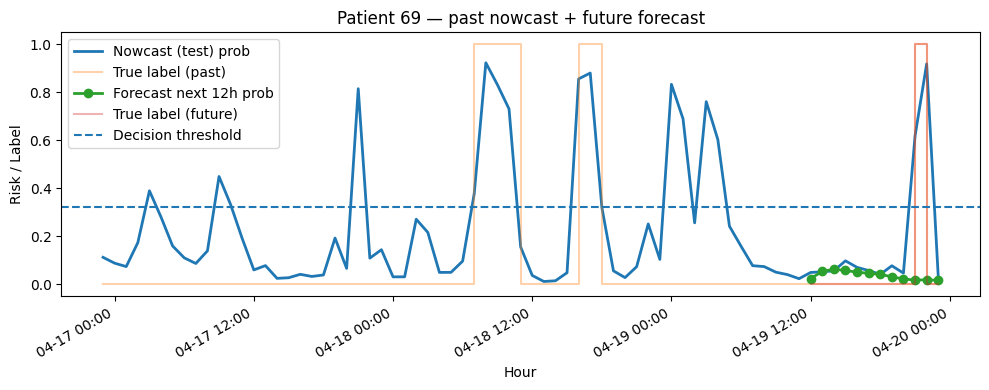

🖼️ Saved compare@+1h → /kaggle/working/nowcast_vs_forecast_h1_patient_69.png


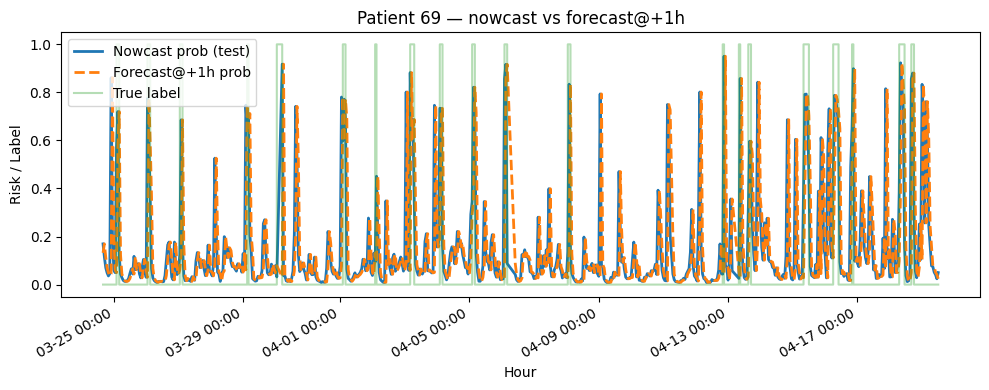

✅ Done.


In [14]:
# ==========================
# Forecasting & time-compare (fixed + improved)
# ==========================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve
import tensorflow as tf

# --------- Fallbacks for global symbols if not already defined in the notebook ---------
try:
    OUT_RESULTS_CSV
except NameError:
    OUT_RESULTS_CSV = "/kaggle/working/results_summary_all.csv"

try:
    USE_STATIC_INPUT
except NameError:
    USE_STATIC_INPUT = True  # your training used static inputs

# focal_loss (redefine here so load_model(custom_objects=...) always works)
def focal_loss(gamma=2.0, alpha=0.8):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

# --------------------------
# 🔧 Parameters you can edit
# --------------------------
OVERRIDE_PATIENT_ID        = 69    # force this patient (else it auto-suggests)
K_HOURS                    = 12    # forecast horizon
AUTO_USE_VAL_OPTIMAL_THR   = True  # use best VAL threshold from your results CSV
THRESH_MANUAL              = 0.49  # fallback if the VAL-optimal isn’t found
FORECAST_METHOD            = "ema" # "ema" | "linear" | "persistence"
EMA_ALPHA                  = 0.6
LIN_STEPS                  = 6
PATIENT_SELECTION_STRATEGY = "positives"
TOP_N_PATIENTS_TO_PLOT     = 3
SAVE_DIR                   = "/kaggle/working"

# Improvement toggles
USE_HORIZON_THRESHOLDS     = True  # calibrate per-horizon thresholds on VAL (boosts recall at longer horizons)
FBETA_FOR_CAL              = 1.5   # β>1 favors recall
APPLY_NOFM                 = True  # apply N-of-M decision smoothing
NOFM_N, NOFM_M             = 2, 3  # 2 of last 3 positives -> positive

os.makedirs(SAVE_DIR, exist_ok=True)

# --- Datetime helpers: make all times tz-naive in UTC ---
def _to_naive_utc(s):
    s = pd.to_datetime(s, errors="coerce")
    # If tz-aware, convert to UTC then drop tz; if tz-naive, leave as is
    if getattr(s.dt, "tz", None) is not None:
        s = s.dt.tz_convert("UTC").dt.tz_localize(None)
    return s

# ----------------------------------------------------
# 0) Utilities: choose best checkpoint & VAL threshold
# ----------------------------------------------------
def pick_best_checkpoint(results_csv=OUT_RESULTS_CSV, ckpt_dir="checkpoints"):
    if not os.path.exists(results_csv):
        raise FileNotFoundError(f"Results CSV not found: {results_csv}")
    df = pd.read_csv(results_csv)
    dfv = df[df["Split"].astype(str).str.lower().eq("val")].copy()
    if dfv.empty:
        raise RuntimeError("No VAL rows found in results; cannot pick best model.")
    dfv = dfv.sort_values("Overall/F1_weighted", ascending=False)
    best = dfv.iloc[0]
    method = str(best["Method"]); model = str(best["Model"])
    ckpt_path = os.path.join(ckpt_dir, f"{method}__{model}.h5")
    if not os.path.exists(ckpt_path):
        files = [os.path.join(ckpt_dir, f) for f in os.listdir(ckpt_dir) if f.endswith(".h5")]
        if not files: raise FileNotFoundError("No .h5 checkpoints found in 'checkpoints'.")
        ckpt_path = files[0]
        print(f"[WARN] Expected checkpoint not found; using {ckpt_path}")
    print(f"✅ Best (VAL F1) → {method}/{model} | ckpt = {ckpt_path}")
    return ckpt_path, method, model

def get_val_optimal_threshold(results_csv, method, model):
    try:
        df = pd.read_csv(results_csv)
        dfv = df[(df["Split"].astype(str).str.lower()=="val") &
                 (df["Method"].astype(str)==method) &
                 (df["Model"].astype(str)==model)].copy()
        if dfv.empty:
            dfv = df[df["Split"].astype(str).str.lower()=="val"].copy()
        dfv = dfv.sort_values("Overall/F1_weighted", ascending=False)
        t = float(dfv.iloc[0]["Threshold"])
        if np.isfinite(t): return t
    except Exception as e:
        print(f"[WARN] Could not read VAL-optimal threshold: {e}")
    return None

# ------------------------------------------------
# 1) Align predictions to hours for a given split
# ------------------------------------------------
def predict_split_prob_df(model, data, hourly, split="test", threshold=0.50):
    Xs = data[split]["X_seq"]; Xstat = data[split]["X_stat"]
    ytrue = data[split]["y"].astype(int).ravel()
    if Xs is None or Xs.ndim != 3:
        raise ValueError(f"No sequences for split={split}.")
    yprob = model.predict([Xs, Xstat], verbose=0).ravel() if (Xstat is not None and Xstat.size>0) else model.predict(Xs, verbose=0).ravel()
    ypred = (yprob >= float(threshold)).astype(int)
    seq_len = Xs.shape[1]

    sub = (hourly[hourly["Split"].astype(str).str.lower() == split.lower()]
           .sort_values(["patientID","hour"]).reset_index())
    sub = sub.rename(columns={"index":"row_idx"})
    sub["hour"] = _to_naive_utc(sub["hour"])  # <<< tz-fix
    rows = []
    for pid, grp in sub.groupby("patientID", sort=True):
        grp = grp.sort_values("hour").reset_index(drop=True)
        for i in range(len(grp) - seq_len):
            tgt = grp.loc[i+seq_len]
            rows.append({"seq_idx":len(rows), "patientID":pid,
                         "hour":pd.to_datetime(tgt["hour"]),
                         "date":pd.to_datetime(tgt.get("date", pd.NaT))})
    idx_map = pd.DataFrame(rows)
    if len(idx_map) != len(ytrue):
        raise RuntimeError(f"Mapping length {len(idx_map)} != predictions length {len(ytrue)}.")
    out = (pd.DataFrame({
                "patientID": idx_map["patientID"].values,
                "hour":      pd.to_datetime(idx_map["hour"].values),
                "date":      pd.to_datetime(idx_map["date"].values),
                "y_true":    ytrue,
                "y_prob":    yprob,
                "y_pred":    ypred
            })
            .sort_values(["patientID","hour"]).reset_index(drop=True))
    out["hour"] = _to_naive_utc(out["hour"])  # belt-and-suspenders
    return out

# ------------------------------------------------------------
# 2) Mini feature forecaster for multi-step rolling predictions
# ------------------------------------------------------------
def _ema_next(v, alpha=0.6):
    s = v[0]
    for x in v[1:]:
        s = alpha*x + (1-alpha)*s
    return float(s)

def _linear_next(v):
    n = len(v)
    if n < 2: return float(v[-1])
    x = np.arange(n, dtype=float)
    try:
        b1, b0 = np.polyfit(x, v.astype(float), 1)  # y = b1*x + b0
        return float(b1*(n) + b0)
    except Exception:
        return float(v[-1])

def next_feature_vector(hist_raw, feat_names, method="ema", ema_alpha=0.6, lin_steps=6):
    T, F = hist_raw.shape
    out = np.zeros(F, dtype=float)
    for j, name in enumerate(feat_names):
        col = hist_raw[:, j]
        if method == "persistence":
            out[j] = float(col[-1])
        elif method == "linear":
            w = min(len(col), max(2, lin_steps))
            out[j] = _linear_next(col[-w:])
        else:  # "ema" default for dynamic signals
            if any(k in str(name).lower() for k in ["cgm","pca","pc1","pc2","pc3","steps","calories","heart"]):
                w = min(len(col), max(2, lin_steps))
                out[j] = _ema_next(col[-w:], alpha=ema_alpha)
            else:
                out[j] = float(col[-1])
    return out

# -----------------------------------------------------------------
# 3) Prepare one anchor window & rolling multi-step patient forecast
# -----------------------------------------------------------------
def _prepare_window_for_patient_index(hourly, data, patient_id, idx, split="test"):
    seq_feats = list(data["seq_features_used"])
    seq_len   = int(data["train"]["X_seq"].shape[1])
    sub = hourly[(hourly["Split"].astype(str).str.lower()==split.lower()) &
                 (hourly["patientID"]==patient_id)].sort_values("hour").reset_index(drop=True)
    sub["hour"] = _to_naive_utc(sub["hour"])  # <<< tz-fix
    if idx < seq_len: raise ValueError("idx must be >= seq_len")
    hist_raw   = sub.loc[idx-seq_len:idx-1, seq_feats].astype(float).values
    seq_scaler = data["scalers"]["seq"]
    hist_scaled= seq_scaler.transform(hist_raw) if seq_scaler is not None else hist_raw
    # static
    if USE_STATIC_INPUT and data["train"]["X_stat"] is not None:
        stat_feats = list(data.get("static_features_used", []))
        srow = (hourly[["patientID"]+stat_feats].drop_duplicates(subset=["patientID"]).set_index("patientID"))
        s = (srow.loc[patient_id].astype(float).values if patient_id in srow.index else np.zeros(len(stat_feats), dtype=float))
        stat_scaler = data["scalers"]["stat"]
        if stat_scaler is not None and s.size>0:
            s = stat_scaler.transform(s.reshape(1,-1)).ravel()
    else:
        s = None
    last_hour  = pd.to_datetime(sub.loc[idx-1, "hour"])
    return hist_scaled, s, hist_raw, last_hour, sub

def rolling_forecast_patient(model, data, hourly, patient_id, k=6, split="test", threshold=0.50,
                             method=FORECAST_METHOD, ema_alpha=EMA_ALPHA, lin_steps=LIN_STEPS):
    seq_feats   = list(data["seq_features_used"])
    seq_len     = int(data["train"]["X_seq"].shape[1])
    seq_scaler  = data["scalers"]["seq"]

    sub = hourly[(hourly["Split"].astype(str).str.lower()==split.lower()) &
                 (hourly["patientID"]==patient_id)].sort_values("hour").reset_index(drop=True)
    sub["hour"] = _to_naive_utc(sub["hour"])  # <<< tz-fix
    rows = []
    for anchor_idx in range(seq_len, len(sub)-1):  # each anchor predicts +1..+k
        last_needed = anchor_idx + k
        if last_needed >= len(sub): break
        Xwin_scaled, svec, raw_hist, _, _ = _prepare_window_for_patient_index(hourly, data, patient_id, anchor_idx, split=split)
        cur_scaled = Xwin_scaled.copy()
        cur_raw    = raw_hist.copy()
        F = cur_scaled.shape[1]
        for h in range(1, k+1):
            xin = cur_scaled.reshape(1, seq_len, F)
            prob = (model.predict([xin, svec.reshape(1,-1)], verbose=0).ravel()[0]
                    if (svec is not None and USE_STATIC_INPUT) else
                    model.predict(xin, verbose=0).ravel()[0])
            tgt_idx  = anchor_idx + h
            tgt_hour = pd.to_datetime(sub.loc[tgt_idx, "hour"])
            y_true   = int(sub.loc[tgt_idx, "hypo_label"])
            # horizon-specific threshold support
            thr_h = (threshold.get(h, float(threshold.get(1, 0.50)))
                     if isinstance(threshold, dict) else float(threshold))
            rows.append({
                "patientID": patient_id,
                "anchor_hour": pd.to_datetime(sub.loc[anchor_idx, "hour"]),
                "forecast_hour": tgt_hour,
                "horizon": h,
                "y_prob": float(prob),
                "y_pred": int(prob >= thr_h),
                "y_true": y_true
            })
            # roll features using mini forecaster
            next_raw    = next_feature_vector(cur_raw, seq_feats, method=method, ema_alpha=ema_alpha, lin_steps=lin_steps)
            next_scaled = seq_scaler.transform(next_raw.reshape(1,-1)).ravel() if seq_scaler is not None else next_raw
            cur_scaled  = np.vstack([cur_scaled[1:], next_scaled])
            cur_raw     = np.vstack([cur_raw[1:], next_raw])
    out = (pd.DataFrame(rows).sort_values(["forecast_hour","horizon"]).reset_index(drop=True))
    out["forecast_hour"] = _to_naive_utc(out["forecast_hour"])  # <<< tz-fix
    out["anchor_hour"]   = _to_naive_utc(out["anchor_hour"])
    return out

# -----------------------------------------
# 4) Metrics by horizon + patient suggestion
# -----------------------------------------
def metrics_by_horizon(df_forecast):
    out = []
    for h, g in df_forecast.groupby("horizon"):
        y = g["y_true"].astype(int).values
        p = g["y_prob"].astype(float).values
        yhat = g["y_pred"].astype(int).values
        try: roc = roc_auc_score(y, p)
        except: roc = np.nan
        try: pr  = average_precision_score(y, p)
        except: pr  = np.nan
        out.append({
            "horizon": h, "n": len(g),
            "Accuracy": accuracy_score(y, yhat),
            "Precision": precision_score(y, yhat, zero_division=0),
            "Recall": recall_score(y, yhat, zero_division=0),
            "F1": f1_score(y, yhat, zero_division=0),
            "ROC_AUC": roc, "PR_AUC": pr
        })
    return pd.DataFrame(out).sort_values("horizon")

def metrics_by_horizon_on_col(df_forecast, col="y_pred"):
    rows = []
    for h, g in df_forecast.groupby("horizon"):
        y = g["y_true"].astype(int).values
        yhat = g[col].astype(int).values
        try: roc = roc_auc_score(y, g["y_prob"].astype(float).values)
        except: roc = np.nan
        try: pr  = average_precision_score(y, g["y_prob"].astype(float).values)
        except: pr  = np.nan
        rows.append({
            "horizon": h, "n": len(g),
            "Accuracy": accuracy_score(y, yhat),
            "Precision": precision_score(y, yhat, zero_division=0),
            "Recall": recall_score(y, yhat, zero_division=0),
            "F1": f1_score(y, yhat, zero_division=0),
            "ROC_AUC": roc, "PR_AUC": pr,
            "decision": col
        })
    return pd.DataFrame(rows).sort_values("horizon")

def suggest_patients_for_plots(df_nowcast, strategy="positives", top_n=3):
    g = df_nowcast.groupby("patientID", as_index=False)
    if strategy == "coverage":
        s = g.size().rename(columns={"size":"n"}).sort_values("n", ascending=False)
        ids = list(s["patientID"].head(top_n))
    elif strategy == "auc":
        rows = []
        for pid, grp in df_nowcast.groupby("patientID"):
            y, p = grp["y_true"].values, grp["y_prob"].values
            try: pr = average_precision_score(y, p)
            except: pr = np.nan
            rows.append({"patientID":pid, "PR_AUC":pr, "n":len(grp)})
        s = (pd.DataFrame(rows).dropna(subset=["PR_AUC"])
             .sort_values(["PR_AUC","n"], ascending=[False, False]))
        ids = list(s["patientID"].head(top_n)) if not s.empty else list(df_nowcast["patientID"].value_counts().head(top_n).index)
    else:  # "positives" default
        pos = g["y_true"].sum().rename(columns={"y_true":"positives"}) \
               .sort_values("positives", ascending=False)
        ids = list(pos["patientID"].head(top_n))
        if pos["positives"].max() <= 0:
            ids = list(df_nowcast["patientID"].value_counts().head(top_n).index)
    return ids

# -----------------------
# 5) Post-processing (N-of-M)
# -----------------------
def apply_n_of_m_rule(df, n=2, m=3):
    """df must be one patient; columns: forecast_hour, y_pred."""
    df = df.sort_values("forecast_hour").copy()
    flags = df["y_pred"].astype(int).values
    out = np.zeros_like(flags)
    for i in range(len(flags)):
        win = flags[max(0, i-m+1):i+1]
        out[i] = 1 if win.sum() >= n else 0
    df["y_pred_nofm"] = out
    return df

# -----------------------
# 6) Plotting functions
# -----------------------
def plot_nowcast_and_forecast_timeline(df_nowcast, df_forecast, patient_id,
                                       hours_back=72, out_png=None, threshold=0.50):
    past = df_nowcast[df_nowcast["patientID"]==patient_id].sort_values("hour").copy()
    past["hour"] = _to_naive_utc(past["hour"])  # <<< tz-fix
    if not past.empty and hours_back and hours_back>0:
        cutoff = past["hour"].max() - pd.Timedelta(hours=hours_back)
        past = past[past["hour"] >= cutoff]
    if df_forecast.empty: raise ValueError("df_forecast is empty.")
    last_anchor = df_forecast[df_forecast["patientID"]==patient_id]["anchor_hour"].max()
    fut = (df_forecast[(df_forecast["patientID"]==patient_id) &
                       (df_forecast["anchor_hour"]==last_anchor)]
           .sort_values("forecast_hour").copy())
    fut["forecast_hour"] = _to_naive_utc(fut["forecast_hour"])  # <<< tz-fix

    fig, ax = plt.subplots(figsize=(10,4))
    if not past.empty:
        ax.plot(past["hour"], past["y_prob"], lw=2, label="Nowcast (test) prob")
        ax.step(past["hour"], past["y_true"], where="post", alpha=0.35, label="True label (past)")
    ax.plot(fut["forecast_hour"], fut["y_prob"], lw=2, marker="o",
            label=f"Forecast next {int(fut['horizon'].max())}h prob")
    if "y_true" in fut.columns and fut["y_true"].notna().any():
        ax.step(fut["forecast_hour"], fut["y_true"], where="post", alpha=0.35, label="True label (future)")
    ax.axhline(float(threshold) if not isinstance(threshold, dict) else float(threshold.get(1, 0.50)),
               ls="--", label="Decision threshold")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Hour"); ax.set_ylabel("Risk / Label")
    ax.set_title(f"Patient {patient_id} — past nowcast + future forecast")
    ax.legend(loc="upper left")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    fig.autofmt_xdate(); fig.tight_layout()
    if out_png:
        fig.savefig(out_png, dpi=200); print(f"🖼️ Saved timeline → {out_png}")
    plt.show()

def plot_nowcast_vs_forecast_h1(df_nowcast, df_forecast, patient_id, out_png=None):
    f1 = df_forecast[(df_forecast["patientID"]==patient_id) & (df_forecast["horizon"]==1)].copy()
    f1 = f1.rename(columns={"forecast_hour":"hour", "y_prob":"y_prob_forecast_h1"})
    past = df_nowcast[df_nowcast["patientID"]==patient_id][["hour","y_prob","y_true"]].copy()

    # --- force both keys to the same dtype/timezone ---
    past["hour"] = _to_naive_utc(past["hour"])
    f1["hour"]   = _to_naive_utc(f1["hour"])

    j = past.merge(f1[["hour","y_prob_forecast_h1"]], on="hour", how="inner").sort_values("hour")
    if j.empty:
        print("[INFO] No overlap between nowcast timeline and horizon-1 forecasts for this patient."); return
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(j["hour"], j["y_prob"], lw=2, label="Nowcast prob (test)")
    ax.plot(j["hour"], j["y_prob_forecast_h1"], lw=2, linestyle="--", label="Forecast@+1h prob")
    ax.step(j["hour"], j["y_true"], where="post", alpha=0.35, label="True label")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Hour"); ax.set_ylabel("Risk / Label")
    ax.set_title(f"Patient {patient_id} — nowcast vs forecast@+1h")
    ax.legend(loc="upper left")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    fig.autofmt_xdate(); fig.tight_layout()
    if out_png:
        fig.savefig(out_png, dpi=200); print(f"🖼️ Saved compare@+1h → {out_png}")
    plt.show()

# -------------------------------------------------
# 7) Threshold calibration on VAL (per horizon)
# -------------------------------------------------
def _best_thr_by_fbeta(y, p, beta=1.0, thr_min=0.10, thr_max=0.70):
    prec, rec, thr = precision_recall_curve(y, p)
    prec, rec, thr = prec[:-1], rec[:-1], thr
    mask = np.isfinite(thr) & (thr >= thr_min) & (thr <= thr_max)
    if not mask.any():
        return 0.50
    fb = (1+beta**2) * (prec[mask]*rec[mask]) / (beta**2*prec[mask] + rec[mask] + 1e-9)
    return float(thr[mask][np.nanargmax(fb)])

def calibrate_horizon_thresholds_on_val(model, data, hourly, k=12, beta=1.5, method="ema"):
    vals = []
    val_mask = hourly["Split"].astype(str).str.lower()=="val"
    val_ids = sorted(hourly.loc[val_mask, "patientID"].unique())
    for pid in val_ids:
        df_fc_val = rolling_forecast_patient(
            model, data, hourly, patient_id=pid, k=k, split="val",
            threshold=0.50, method=method  # temporary; only need probs
        )
        if not df_fc_val.empty:
            vals.append(df_fc_val)
    if not vals:
        return {}
    allv = pd.concat(vals, ignore_index=True)
    out = {}
    for h, g in allv.groupby("horizon"):
        y = g["y_true"].astype(int).values
        p = g["y_prob"].astype(float).values
        if len(np.unique(y)) < 2:
            continue
        out[h] = _best_thr_by_fbeta(y, p, beta=beta, thr_min=0.10, thr_max=0.70)
    return out

# ======================
# 8) Run: load, forecast, plot
# ======================
# Preconditions
if "hourly" not in globals() or "data" not in globals():
    raise RuntimeError("hourly/data not found. Please run your feature builder and sequence builder cells first.")

CKPT_PATH, _best_method, _best_model = pick_best_checkpoint(OUT_RESULTS_CSV, "checkpoints")
model = tf.keras.models.load_model(CKPT_PATH, custom_objects={"loss": focal_loss, "focal_loss": focal_loss})

# (b) Threshold: VAL-optimal or manual
if AUTO_USE_VAL_OPTIMAL_THR:
    thr_val = get_val_optimal_threshold(OUT_RESULTS_CSV, _best_method, _best_model)
    THRESH   = float(thr_val) if (thr_val is not None) else float(THRESH_MANUAL)
    if thr_val is None:
        print(f"[INFO] Using manual THRESH={THRESH_MANUAL:.2f} (VAL-optimal not found).")
    else:
        print(f"✅ Using VAL-optimal THRESH={THRESH:.2f}")
else:
    THRESH = float(THRESH_MANUAL)
    print(f"ℹ️ Using manual THRESH={THRESH:.2f}")

# (c) Nowcast on TEST + suggestions
df_test_nowcast = predict_split_prob_df(model, data, hourly, split="test", threshold=THRESH)
if OVERRIDE_PATIENT_ID is not None and OVERRIDE_PATIENT_ID in set(df_test_nowcast["patientID"].unique()):
    suggested = [OVERRIDE_PATIENT_ID]
else:
    suggested = suggest_patients_for_plots(df_test_nowcast, strategy=PATIENT_SELECTION_STRATEGY,
                                           top_n=TOP_N_PATIENTS_TO_PLOT)
print("📌 Suggested patientID(s) to plot:", suggested)

# (d) Optional: learn per-horizon thresholds on VAL
HORIZON_THR = None
if USE_HORIZON_THRESHOLDS:
    HORIZON_THR = calibrate_horizon_thresholds_on_val(
        model, data, hourly, k=K_HOURS, beta=FBETA_FOR_CAL, method=FORECAST_METHOD
    )
    print("Horizon thresholds (VAL):", HORIZON_THR)

# (e) Forecast & plot
for pid in suggested:
    print(f"\n=== Forecasting patient {pid} | K={K_HOURS}, method={FORECAST_METHOD} ===")
    thr_to_use = (HORIZON_THR if (isinstance(HORIZON_THR, dict) and len(HORIZON_THR)>0) else THRESH)
    df_fc = rolling_forecast_patient(model, data, hourly, patient_id=pid, k=K_HOURS,
                                     split="test", threshold=thr_to_use,
                                     method=FORECAST_METHOD, ema_alpha=EMA_ALPHA, lin_steps=LIN_STEPS)
    print("Forecast rows:", len(df_fc))

    # Optional N-of-M smoothing
    if APPLY_NOFM and not df_fc.empty:
        df_fc = df_fc.groupby("patientID", group_keys=False).apply(apply_n_of_m_rule, n=NOFM_N, m=NOFM_M)

    # Metrics
    hz_base = metrics_by_horizon(df_fc)
    print("Horizon metrics (base decision):\n", hz_base)
    if APPLY_NOFM and "y_pred_nofm" in df_fc.columns:
        hz_nofm = metrics_by_horizon_on_col(df_fc, col="y_pred_nofm")
        print("Horizon metrics (N-of-M decision):\n", hz_nofm)

    # Plots
    outA = os.path.join(SAVE_DIR, f"nowcast_plus_forecast_patient_{pid}.png")
    plot_nowcast_and_forecast_timeline(df_test_nowcast, df_fc, patient_id=pid,
                                       hours_back=72, threshold=thr_to_use, out_png=outA)
    outB = os.path.join(SAVE_DIR, f"nowcast_vs_forecast_h1_patient_{pid}.png")
    plot_nowcast_vs_forecast_h1(df_test_nowcast, df_fc, patient_id=pid, out_png=outB)

print("✅ Done.")


⚠️ VISIT_WIDE_CSV found but none of the needed visit columns present; will try LONG if available.
⚠️ VISIT_LONG_CSV present but none of the needed variables were found in the pivot.
⚠️ No usable visit CSVs found; visit features will be zero-filled.
ℹ️ static: using patientID column = 'PatientID (Huawei Data)'
✅ Saved hourly features (leak-safe) → /kaggle/working/dynamic_hourly_features_ramadan.csv
✅ Sequences built | train=(13134, 24, 8), val=(2039, 24, 8), test=(3722, 24, 8)
💾 Saved sequences → /kaggle/working/sequences_leakfree.npz

🔁 Resampling: none | train y-dist = Counter({0: 12518, 1: 616})
Epoch 1/12
409/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8952 - loss: 0.0385

411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8955 - loss: 0.0384 - val_accuracy: 0.9603 - val_loss: 0.0022
Epoch 2/12
406/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9542 - loss: 0.0148

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9542 - loss: 0.0148 - val_accuracy: 0.9603 - val_loss: 0.0019
Epoch 3/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9548 - loss: 0.0132 - val_accuracy: 0.9632 - val_loss: 0.0019
Epoch 4/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9565 - loss: 0.0127 - val_accuracy: 0.9657 - val_loss: 0.0019
Epoch 5/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9568 - loss: 0.0122

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9568 - loss: 0.0122 - val_accuracy: 0.9657 - val_loss: 0.0018
Epoch 6/12
410/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9575 - loss: 0.0117

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9575 - loss: 0.0117 - val_accuracy: 0.9667 - val_loss: 0.0018
Epoch 7/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9585 - loss: 0.0115

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9585 - loss: 0.0115 - val_accuracy: 0.9681 - val_loss: 0.0017
Epoch 8/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9581 - loss: 0.0113 - val_accuracy: 0.9662 - val_loss: 0.0019
Epoch 9/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9599 - loss: 0.0107 - val_accuracy: 0.9657 - val_loss: 0.0019
Epoch 10/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9596 - loss: 0.0108 - val_accuracy: 0.9637 - val_loss: 0.0020
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
📌 [none/LSTM_100] VAL thresholds → Youden=0.4179, PR-F1=0.5026 (window [0.4,0.6])
Epoch 1/12
410/411 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9355 - loss: 0.0319

411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9355 - loss: 0.0319 - val_accuracy: 0.9603 - val_loss: 0.0022
Epoch 2/12
408/411 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9540 - loss: 0.0143

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9540 - loss: 0.0143 - val_accuracy: 0.9608 - val_loss: 0.0018
Epoch 3/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9547 - loss: 0.0131

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9547 - loss: 0.0131 - val_accuracy: 0.9632 - val_loss: 0.0017
Epoch 4/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9561 - loss: 0.0121 - val_accuracy: 0.9622 - val_loss: 0.0019
Epoch 5/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9569 - loss: 0.0116 - val_accuracy: 0.9637 - val_loss: 0.0019
Epoch 6/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9592 - loss: 0.0111 - val_accuracy: 0.9637 - val_loss: 0.0019
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
📌 [none/BiLSTM] VAL thresholds → Youden=0.4303, PR-F1=0.4303 (window [0.4,0.6])
Epoch 1/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9095 - loss: 0.0376

411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9095 - loss: 0.0376 - val_accuracy: 0.9603 - val_loss: 0.0025
Epoch 2/12
409/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9542 - loss: 0.0167

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9542 - loss: 0.0167 - val_accuracy: 0.9603 - val_loss: 0.0018
Epoch 3/12
406/411 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9548 - loss: 0.0133

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9548 - loss: 0.0133 - val_accuracy: 0.9627 - val_loss: 0.0017
Epoch 4/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9553 - loss: 0.0127 - val_accuracy: 0.9627 - val_loss: 0.0020
Epoch 5/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9580 - loss: 0.0122 - val_accuracy: 0.9652 - val_loss: 0.0019
Epoch 6/12
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9568 - loss: 0.0118 - val_accuracy: 0.9617 - val_loss: 0.0021
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
📌 [none/LSTM_50] VAL thresholds → Youden=0.4281, PR-F1=0.4004 (window [0.4,0.6])

🔁 Resampling: oversample_seq | train y-dist = Counter({0: 12518, 1: 616})
Epoch 1/12
780/783 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6980 - loss: 0.0451

783/783 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6984 - loss: 0.0450 - val_accuracy: 0.9382 - val_loss: 0.0080
Epoch 2/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8374 - loss: 0.0187 - val_accuracy: 0.9240 - val_loss: 0.0089
Epoch 3/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8658 - loss: 0.0141 - val_accuracy: 0.9132 - val_loss: 0.0121
Epoch 4/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9049 - loss: 0.0084 - val_accuracy: 0.9088 - val_loss: 0.0126
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
📌 [oversample_seq/LSTM_100] VAL thresholds → Youden=0.4094, PR-F1=0.5304 (window [0.4,0.6])
Epoch 1/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7200 - loss: 0.0396

783/783 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7200 - loss: 0.0395 - val_accuracy: 0.9088 - val_loss: 0.0122
Epoch 2/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8450 - loss: 0.0175 - val_accuracy: 0.9004 - val_loss: 0.0130
Epoch 3/12
782/783 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8869 - loss: 0.0109

783/783 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8870 - loss: 0.0109 - val_accuracy: 0.9176 - val_loss: 0.0104
Epoch 4/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9254 - loss: 0.0061 - val_accuracy: 0.9220 - val_loss: 0.0133
Epoch 5/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9507 - loss: 0.0034 - val_accuracy: 0.9338 - val_loss: 0.0105
Epoch 6/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9624 - loss: 0.0023 - val_accuracy: 0.9294 - val_loss: 0.0119
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
📌 [oversample_seq/BiLSTM] VAL thresholds → Youden=0.4534, PR-F1=0.5967 (window [0.4,0.6])
Epoch 1/12
779/783 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6866 - loss: 0.0463

783/783 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6870 - loss: 0.0463 - val_accuracy: 0.8980 - val_loss: 0.0161
Epoch 2/12
778/783 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8298 - loss: 0.0201

783/783 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8298 - loss: 0.0201 - val_accuracy: 0.9137 - val_loss: 0.0130
Epoch 3/12
782/783 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8505 - loss: 0.0163

783/783 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8505 - loss: 0.0163 - val_accuracy: 0.9093 - val_loss: 0.0126
Epoch 4/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8771 - loss: 0.0126 - val_accuracy: 0.8887 - val_loss: 0.0201
Epoch 5/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9040 - loss: 0.0085 - val_accuracy: 0.9014 - val_loss: 0.0166
Epoch 6/12
783/783 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9241 - loss: 0.0060 - val_accuracy: 0.9117 - val_loss: 0.0150
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
📌 [oversample_seq/LSTM_50] VAL thresholds → Youden=0.4081, PR-F1=0.5981 (window [0.4,0.6])

🔁 Resampling: undersample_seq | train y-dist = Counter({0: 12518, 1: 616})
Epoch 1/12
34/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5255 - loss: 0.0750

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5325 - loss: 0.0740 - val_accuracy: 0.9490 - val_loss: 0.0438
Epoch 2/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6525 - loss: 0.0577

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6513 - loss: 0.0578 - val_accuracy: 0.9323 - val_loss: 0.0402
Epoch 3/12
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6478 - loss: 0.0556

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6471 - loss: 0.0557 - val_accuracy: 0.9411 - val_loss: 0.0345
Epoch 4/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6636 - loss: 0.0500

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6624 - loss: 0.0500 - val_accuracy: 0.9436 - val_loss: 0.0197
Epoch 5/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6810 - loss: 0.0440

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6822 - loss: 0.0437 - val_accuracy: 0.9073 - val_loss: 0.0147
Epoch 6/12
35/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7551 - loss: 0.0333

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7570 - loss: 0.0330 - val_accuracy: 0.9343 - val_loss: 0.0067
Epoch 7/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7769 - loss: 0.0282 - val_accuracy: 0.9210 - val_loss: 0.0090
Epoch 8/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7977 - loss: 0.0245 - val_accuracy: 0.9142 - val_loss: 0.0113
Epoch 9/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7901 - loss: 0.0246 - val_accuracy: 0.9009 - val_loss: 0.0157
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.
📌 [undersample_seq/LSTM_100] VAL thresholds → Youden=0.4483, PR-F1=0.5478 (window [0.4,0.6])
Epoch 1/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4997 - loss: 0.0793

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5045 - loss: 0.0785 - val_accuracy: 0.9603 - val_loss: 0.0284
Epoch 2/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6317 - loss: 0.0549 - val_accuracy: 0.9245 - val_loss: 0.0304
Epoch 3/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7122 - loss: 0.0413

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7122 - loss: 0.0413 - val_accuracy: 0.9044 - val_loss: 0.0186
Epoch 4/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7419 - loss: 0.0331

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7432 - loss: 0.0332 - val_accuracy: 0.9078 - val_loss: 0.0160
Epoch 5/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7728 - loss: 0.0301 - val_accuracy: 0.8897 - val_loss: 0.0193
Epoch 6/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7874 - loss: 0.0266 - val_accuracy: 0.8926 - val_loss: 0.0168
Epoch 7/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8011 - loss: 0.0249

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8017 - loss: 0.0249 - val_accuracy: 0.8990 - val_loss: 0.0153
Epoch 8/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8006 - loss: 0.0232 - val_accuracy: 0.8867 - val_loss: 0.0171
Epoch 9/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8198 - loss: 0.0222 - val_accuracy: 0.8798 - val_loss: 0.0191
Epoch 10/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8182 - loss: 0.0210 - val_accuracy: 0.8867 - val_loss: 0.0162
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.
📌 [undersample_seq/BiLSTM] VAL thresholds → Youden=0.4323, PR-F1=0.5375 (window [0.4,0.6])
Epoch 1/12
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4880 - loss: 0.0985

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4891 - loss: 0.0978 - val_accuracy: 0.9603 - val_loss: 0.0206
Epoch 2/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5698 - loss: 0.0617 - val_accuracy: 0.9588 - val_loss: 0.0261
Epoch 3/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6356 - loss: 0.0567 - val_accuracy: 0.9382 - val_loss: 0.0299
Epoch 4/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6413 - loss: 0.0532

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6408 - loss: 0.0532 - val_accuracy: 0.9338 - val_loss: 0.0195
Epoch 5/12
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6618 - loss: 0.0466

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6636 - loss: 0.0464 - val_accuracy: 0.9411 - val_loss: 0.0106
Epoch 6/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7036 - loss: 0.0369 - val_accuracy: 0.9240 - val_loss: 0.0111
Epoch 7/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7696 - loss: 0.0301 - val_accuracy: 0.8882 - val_loss: 0.0175
Epoch 8/12
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7938 - loss: 0.0277 - val_accuracy: 0.8828 - val_loss: 0.0182
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
📌 [undersample_seq/LSTM_50] VAL thresholds → Youden=0.4036, PR-F1=0.4444 (window [0.4,0.6])
⏭️  Skipping smote (static input enabled).
⏭️  Skipping smoteenn (static input enabled).
⏭️  Skipping smotetomek (static input enabled).


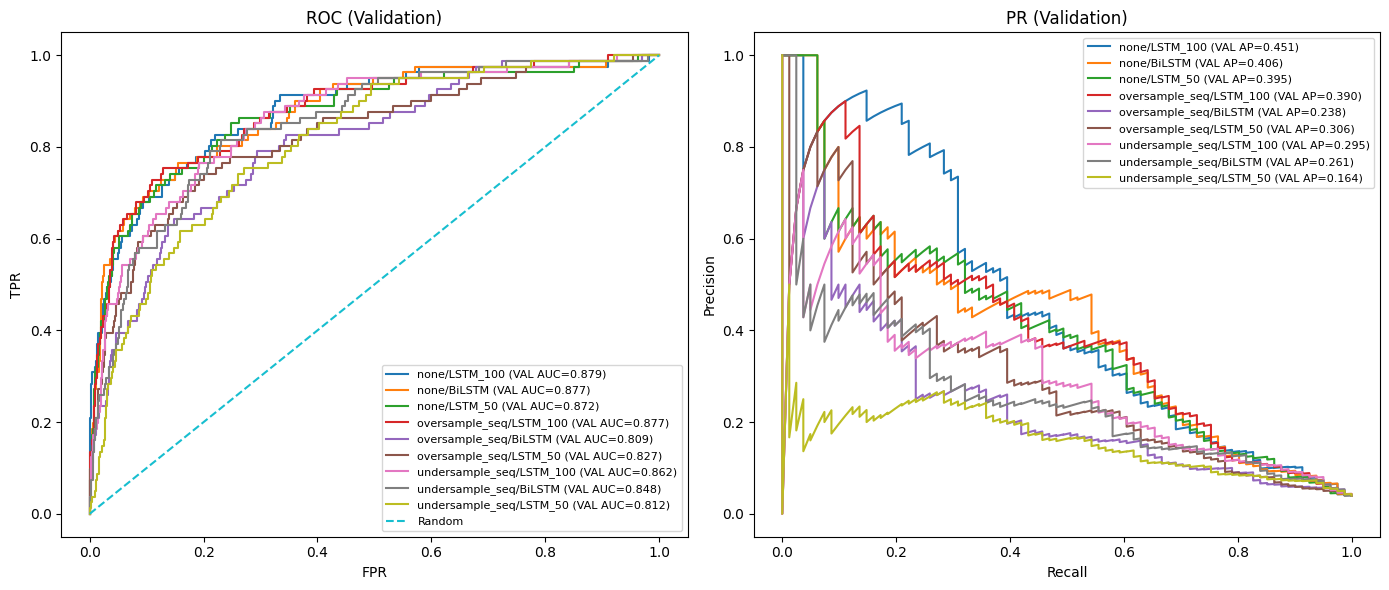

🖼️ Saved plots → /kaggle/working/combined_roc_pr_curves.png
📑 Saved results → /kaggle/working/results_summary_all.csv
📑 Saved AUC significance table → /kaggle/working/auc_significance.csv
       Split                  ModelA                  ModelB    AUC_A  AUC_A_CI95_L  AUC_A_CI95_U    AUC_B  AUC_B_CI95_L  AUC_B_CI95_U  Delta_AUC  SE_Delta        Z  P_value
        test           none/LSTM_100 oversample_seq/LSTM_100 0.897014      0.861006      0.926693 0.885516      0.849443      0.917090   0.011393  0.008232 1.384011 0.166355
        test           none/LSTM_100  undersample_seq/BiLSTM 0.897014      0.861006      0.926693 0.860984      0.830111      0.890677   0.035782  0.010053 3.559329 0.000372
        test oversample_seq/LSTM_100  undersample_seq/BiLSTM 0.885516      0.849443      0.917090 0.860984      0.830111      0.890677   0.024389  0.011672 2.089519 0.036661
testBalanced           none/LSTM_100 oversample_seq/LSTM_100 0.896469      0.857069      0.933620 0.886222      0.84

In [15]:
# ==============================================
# Leak-safe Ramadan features + Balanced LSTM
# (hourly builder + sequences + training utilities + significance testing)
# ==============================================
import os, time, warnings, random, re
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score, auc, mean_squared_error
)
from scipy.stats import norm  # <-- added
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# --------------------
# GLOBAL CONFIG
# --------------------
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
STATIC_CSV      = "/kaggle/input/hmc-model-static-variables/outcome_static.csv"
VISIT_WIDE_CSV  = "/kaggle/input/hmc-model-static-variables/outcome_visit_wide_by_variable.csv"
VISIT_LONG_CSV  = "/kaggle/input/hmc-model-static-variables/outcome_visit_long.csv"

OUT_HOURLY_CSV  = "/kaggle/working/dynamic_hourly_features_ramadan.csv"
OUT_SEQ_NPZ     = "/kaggle/working/sequences_leakfree.npz"
OUT_RESULTS_CSV = "/kaggle/working/results_summary_all.csv"
OUT_PLOTS_PNG   = "/kaggle/working/combined_roc_pr_curves.png"

RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")
HYPO_CUTOFF   = 70.0
MIN_CGM_PER_H = 4
SEQ_LEN       = 24

LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

VISIT_COLS = ["carb","meals","total_daily_dose_u","fasting_percent_29"]
STATIC_COLS = [
    "Age","Gender","BMI","HbA1C","Cholesterol","LDL","HDL","Triglycerides",
    "eGFR","Creatinine","Insulin_units_per_kg","SmartGuard_percent"
]

DEFAULT_SEQ_FEATURE_COLS = (
    "cgm_mean","cgm_std","pca_cgm1",
    "pc1_activity_energy",
    "carb","meals","total_daily_dose_u","fasting_percent_29"
)

RANDOM_STATE     = 42
THR_MIN, THR_MAX = 0.40, 0.60
AUGMENT_SIGMA    = 0.01
RESAMPLE_METHODS = ["none","oversample_seq","undersample_seq","smote","smoteenn","smotetomek"]
USE_STATIC_INPUT = True

# --------------------
# Utilities (robust column picking)
# --------------------
def set_global_seeds(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_global_seeds(RANDOM_STATE)

def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def safe_encode_gender(series):
    if series.dtype == "object":
        return (series.str.strip().str.lower().map({"male":1, "m":1, "female":0, "f":0}))
    return pd.to_numeric(series, errors="coerce")

def split_patients(unique_pids, test_size=0.2, val_size=0.1, random_state=RANDOM_STATE):
    train_pids, test_pids = train_test_split(unique_pids, test_size=test_size, random_state=random_state)
    val_fraction = val_size / max(1e-9, (1.0 - test_size))
    train_pids, val_pids = train_test_split(train_pids, test_size=val_fraction, random_state=random_state)
    return np.array(train_pids), np.array(val_pids), np.array(test_pids)

def _normalize_date(s):
    s = pd.to_datetime(s, errors="coerce")
    return s.dt.normalize()

def _norm_col(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def _pick_col_flex(df: pd.DataFrame, preferred=None, required=False, name="", must_contain_all=None, any_contains=None):
    cols = list(df.columns)
    norm_map = {c: _norm_col(c) for c in cols}
    if preferred:
        lower_pref = {str(p).strip().lower(): p for p in preferred}
        for c in cols:
            if str(c).strip().lower() in lower_pref:
                return c
    if preferred:
        pref_norm = {_norm_col(p): p for p in preferred}
        for c, n in norm_map.items():
            if n in pref_norm:
                return c
    cands = []
    for c, n in norm_map.items():
        ok = True
        if must_contain_all:
            for tok in must_contain_all:
                if _norm_col(tok) not in n:
                    ok = False; break
        if ok and any_contains:
            if not any(_norm_col(tok) in n for tok in any_contains):
                ok = False
        if ok: cands.append(c)
    if cands:
        def _priority(col: str):
            n = norm_map[col]
            starts_pid = n.startswith("patientid")
            has_pid    = "patientid" in n
            return (-(starts_pid or has_pid), len(n))
        cands.sort(key=_priority)
        return cands[0]
    if required:
        raise KeyError(f"Required column not found for {name}. preferred={preferred} | must_contain_all={must_contain_all} | any_contains={any_contains}. Available: {cols}")
    return None

def _pick_patient_col(df: pd.DataFrame) -> str:
    preferred = ["patientID","patientId","PatientID (Huawei Data)","subject_id","patid","pid","id","huaweiid"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="patientID",
                          must_contain_all=["id"], any_contains=["patient","subject","pat","huawei"])

def _pick_date_col(df: pd.DataFrame) -> str:
    preferred = ["date","visit_date","Date","day","timestamp","Visit Date","date_of_visit","start"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="date",
                          any_contains=["date","visit","day","timestamp","start"])

def _pick_variable_col(df: pd.DataFrame) -> str:
    preferred = ["variable","var","feature","name","measure","metric"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="variable",
                          any_contains=["variable","var","feature","name","measure","metric"])

def _pick_value_col(df: pd.DataFrame) -> str:
    preferred = ["value","val","measure_value","reading","amount","score"]
    return _pick_col_flex(df, preferred=preferred, required=True, name="value",
                          any_contains=["value","val","measurevalue","reading","amount","score"])

# ---------------------------
# Loaders for external files
# ---------------------------
def load_static_df(static_csv=STATIC_CSV, needed=STATIC_COLS):
    if not static_csv or not os.path.exists(static_csv):
        print("⚠️ Static CSV not found; static features will be zero-filled.")
        return None
    df = pd.read_csv(static_csv)
    pid_col = _pick_patient_col(df)
    df = df.rename(columns={pid_col:"patientID"})
    keep = ["patientID"] + [c for c in needed if c in df.columns]
    df = df[keep].drop_duplicates(subset=["patientID"]).copy()
    if "Gender" in df.columns:
        df["Gender"] = safe_encode_gender(df["Gender"])
    for c in keep:
        if c != "patientID":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    print(f"ℹ️ static: using patientID column = '{pid_col}'")
    return df

def load_visit_df(visit_wide_csv=VISIT_WIDE_CSV, visit_long_csv=VISIT_LONG_CSV, needed=VISIT_COLS):
    if visit_wide_csv and os.path.exists(visit_wide_csv):
        wide = pd.read_csv(visit_wide_csv)
        pid_col  = _pick_patient_col(wide)
        date_col = _pick_date_col(wide)
        wide = wide.rename(columns={pid_col:"patientID", date_col:"date"})
        wide["date"] = _normalize_date(wide["date"])
        keep = ["patientID","date"] + [c for c in needed if c in wide.columns]
        if len(keep) > 2:
            print(f"ℹ️ visit-wide: patientID='{pid_col}', date='{date_col}', kept={keep[2:]}")
            return wide[keep].copy()
        else:
            print("⚠️ VISIT_WIDE_CSV found but none of the needed visit columns present; will try LONG if available.")
    if visit_long_csv and os.path.exists(visit_long_csv):
        long = pd.read_csv(visit_long_csv)
        pid_col   = _pick_patient_col(long)
        date_col  = _pick_date_col(long)
        var_col   = _pick_variable_col(long)
        value_col = _pick_value_col(long)
        long = long.rename(columns={pid_col:"patientID", date_col:"date", var_col:"variable", value_col:"value"})
        long["date"] = _normalize_date(long["date"])
        wide = (long
                .pivot_table(index=["patientID","date"], columns="variable", values="value", aggfunc="mean")
                .reset_index())
        keep = ["patientID","date"] + [c for c in needed if c in wide.columns]
        if len(keep) > 2:
            print(f"ℹ️ visit-long: patientID='{pid_col}', date='{date_col}', variables matched={keep[2:]}")
            return wide[keep].copy()
        print("⚠️ VISIT_LONG_CSV present but none of the needed variables were found in the pivot.")
    print("⚠️ No usable visit CSVs found; visit features will be zero-filled.")
    return None

# ----------------------------------------------------------------
# Part A — Build hourly Ramadan features and leak-safe transforms
# ----------------------------------------------------------------
def build_hourly_features_with_leak_safe_transforms(
    in_csv=CSV_INTRADAY_WITH_VISITS,
    out_csv=OUT_HOURLY_CSV,
    min_cgm_per_hour=MIN_CGM_PER_H,
    test_size=0.2, val_size=0.1, random_state=RANDOM_STATE,
    static_csv=STATIC_CSV, visit_wide_csv=VISIT_WIDE_CSV, visit_long_csv=VISIT_LONG_CSV
):
    if not os.path.exists(in_csv):
        raise FileNotFoundError(f"Input not found: {in_csv}")
    df = pd.read_csv(in_csv)
    if "patientID" not in df.columns:
        pid_col = _pick_patient_col(df)
        df = df.rename(columns={pid_col: "patientID"})
        print(f"ℹ️ intraday: using patientID column = '{pid_col}'")

    start_col = "start" if "start" in df.columns else _pick_date_col(df)
    df[start_col] = to_dt(df[start_col])
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    else:
        df["date"] = pd.to_datetime(df[start_col].dt.date)
    df["hour"]       = df[start_col].dt.floor("h")
    df["hour_of_day"]= df["hour"].dt.hour

    df = ensure_numeric(df)
    df = df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

    if "cgm" not in df.columns:
        raise ValueError("❌ Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    hourly = (
        valid_hours.groupby(["patientID","hour"], as_index=False)
                   .agg(
                       cgm_min=("cgm","min"),
                       cgm_max=("cgm","max"),
                       cgm_mean=("cgm","mean"),
                       cgm_std=("cgm","std")
                   )
                   .sort_values(["patientID","hour"])
                   .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
                   .apply(lambda x: int((x < HYPO_CUTOFF).any()))
                   .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    lifestyle_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if lifestyle_cols:
        life_hourly = (
            df_cgm.groupby(["patientID","hour"], as_index=False)[lifestyle_cols]
                  .mean().fillna(0.0)
        )
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left")

    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    pids = hourly["patientID"].dropna().unique()
    train_p, val_p, test_p = split_patients(pids, test_size=test_size, val_size=val_size, random_state=random_state)
    hourly["Split"] = np.where(hourly["patientID"].isin(train_p), "train",
                        np.where(hourly["patientID"].isin(val_p), "val", "test"))

    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    tr_mask  = hourly["Split"] == "train"
    scal_cgm = StandardScaler().fit(hourly.loc[tr_mask, cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=random_state).fit(
        scal_cgm.transform(hourly.loc[tr_mask, cgm_cols].fillna(0.0))
    )
    def _apply_cgm_pca(df_in):
        X = scal_cgm.transform(df_in[cgm_cols].fillna(0.0))
        Z = pca_cgm.transform(X)
        out = df_in.copy()
        out["pca_cgm1"], out["pca_cgm2"], out["pca_cgm3"] = Z[:,0], Z[:,1], Z[:,2]
        return out
    hourly = _apply_cgm_pca(hourly)

    if lifestyle_cols:
        scal_life = StandardScaler().fit(hourly.loc[tr_mask, lifestyle_cols].fillna(0.0))
        pca_life  = PCA(n_components=3, random_state=random_state).fit(
            scal_life.transform(hourly.loc[tr_mask, lifestyle_cols].fillna(0.0))
        )
        X_all = scal_life.transform(hourly[lifestyle_cols].fillna(0.0))
        Z_all = pca_life.transform(X_all)
        hourly["pc1_activity_energy"] = Z_all[:,0]
        hourly["pc2_physiology"]      = Z_all[:,1]
        hourly["pc3_sleep_rest"]      = Z_all[:,2]
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    visit_df = load_visit_df(visit_wide_csv, visit_long_csv, VISIT_COLS)
    hourly["date"] = hourly["hour"].dt.normalize()
    if visit_df is not None:
        visit_df["date"] = pd.to_datetime(visit_df["date"], errors="coerce").dt.normalize()
        visit_df = visit_df[(visit_df["date"] >= RAMADAN_START) & (visit_df["date"] <= RAMADAN_END)].copy()
        hourly = hourly.merge(visit_df, on=["patientID","date"], how="left")
    for c in VISIT_COLS:
        if c not in hourly.columns:
            hourly[c] = 0.0
        hourly[c] = pd.to_numeric(hourly[c], errors="coerce").fillna(0.0)

    static_df = load_static_df(static_csv, STATIC_COLS)
    if static_df is not None:
        hourly = hourly.merge(static_df, on="patientID", how="left")
    for c in STATIC_COLS:
        if c not in hourly.columns:
            hourly[c] = 0.0
        hourly[c] = pd.to_numeric(cast := hourly[c], errors="coerce").fillna(0.0)

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly.to_csv(out_csv, index=False)
    print(f"✅ Saved hourly features (leak-safe) → {out_csv}")

    return hourly, (train_p, val_p, test_p)

# ---------------------------------------------------------------
# Part B — Build sequences (optionally with per-patient static)
# ---------------------------------------------------------------
def build_sequences_by_split(hourly, splits, seq_len=SEQ_LEN, seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
                             static_cols=STATIC_COLS, scale_features=True):
    for c in ["patientID","hour","hypo_label","Split"]:
        if c not in hourly.columns:
            raise KeyError(f"hourly missing required column: {c}")
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")

    seq_feature_cols = list(seq_feature_cols)
    missing_seq = [c for c in seq_feature_cols if c not in hourly.columns]
    if missing_seq:
        raise KeyError(f"Sequence feature(s) not found in hourly: {missing_seq}")

    static_cols_present = [c for c in static_cols if c in hourly.columns]
    if static_cols_present and USE_STATIC_INPUT:
        static_mat = (hourly[["patientID"] + static_cols_present]
                      .drop_duplicates(subset=["patientID"])
                      .set_index("patientID")
                      .astype(float).fillna(0.0))
    else:
        static_mat = None
        static_cols_present = []

    train_p, val_p, test_p = splits

    def _build_for_pidset(pid_set):
        sub = hourly[hourly["patientID"].isin(pid_set)].copy()
        X_seq, X_stat, y = [], [], []
        for pid, grp in sub.groupby("patientID"):
            grp = grp.sort_values("hour").reset_index(drop=True)
            if len(grp) <= seq_len:
                continue
            feats  = grp[seq_feature_cols].astype(float).values
            labels = grp["hypo_label"].astype(int).values
            for i in range(len(grp) - seq_len):
                X_seq.append(feats[i:i+seq_len]); y.append(labels[i+seq_len])
                if static_mat is not None and pid in static_mat.index:
                    X_stat.append(static_mat.loc[pid].values.astype(float))
        X_seq = np.array(X_seq); y = np.array(y).astype(int)
        X_stat = np.array(X_stat) if (static_mat is not None and len(X_stat)>0) else None
        return X_seq, X_stat, y

    Xtr_s, Xtr_stat, ytr = _build_for_pidset(train_p)
    Xva_s, Xva_stat, yva = _build_for_pidset(val_p)
    Xte_s, Xte_stat, yte = _build_for_pidset(test_p)

    seq_scaler  = None
    stat_scaler = None
    if scale_features and Xtr_s.size > 0:
        n_f = Xtr_s.shape[2]
        seq_scaler = StandardScaler().fit(Xtr_s.reshape(-1, n_f))
        def _scale_seq(X):
            if X is None or X.size==0: return X
            n = X.shape[0]; return seq_scaler.transform(X.reshape(-1, n_f)).reshape(n, SEQ_LEN, n_f)
        Xtr_s = _scale_seq(Xtr_s); Xva_s = _scale_seq(Xva_s); Xte_s = _scale_seq(Xte_s)

    if scale_features and Xtr_stat is not None and Xtr_stat.size>0:
        stat_scaler = StandardScaler().fit(Xtr_stat)
        def _scale_stat(X):
            if X is None or X.size==0: return X
            return stat_scaler.transform(X)
        Xtr_stat = _scale_stat(Xtr_stat); Xva_stat = _scale_stat(Xva_stat); Xte_stat = _scale_stat(Xte_stat)

    print(f"✅ Sequences built | train={Xtr_s.shape}, val={Xva_s.shape}, test={Xte_s.shape}")
    return {
        "train": {"X_seq": Xtr_s, "X_stat": Xtr_stat, "y": ytr},
        "val":   {"X_seq": Xva_s, "X_stat": Xva_stat, "y": yva},
        "test":  {"X_seq": Xte_s, "X_stat": Xte_stat, "y": yte},
        "seq_features_used": seq_feature_cols,
        "static_features_used": static_cols_present,
        "scalers": {"seq": seq_scaler, "stat": stat_scaler}
    }

# ------------------------------------------------------
# Balanced LSTM pipeline utilities (metrics, resampling)
# ------------------------------------------------------
THR_MIN, THR_MAX = THR_MIN, THR_MAX

def _best_threshold_in_range(thresholds, scores, thr_min=THR_MIN, thr_max=THR_MAX):
    thresholds = np.asarray(thresholds, dtype=float)
    scores     = np.asarray(scores, dtype=float)
    mask = np.isfinite(thresholds) & (thresholds >= thr_min) & (thresholds <= thr_max)
    if mask.any():
        idx_in = int(np.nanargmax(scores[mask])); idx = np.where(mask)[0][idx_in]
        return float(thresholds[idx]), True
    idx = int(np.nanargmax(scores))
    return float(np.clip(thresholds[idx], thr_min, thr_max)), False

def focal_loss(gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def _safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape != (2,2):
        full = np.zeros((2,2), dtype=int)
        full[:cm.shape[0], :cm.shape[1]] = cm
        cm = full
    return cm

def _specificity_overall(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def _specificity_per_class(y_true, y_pred, positive_label):
    y_true_bin = (np.asarray(y_true).ravel() == positive_label).astype(int)
    y_pred_bin = (np.asarray(y_pred).ravel() == positive_label).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
    return tn / (tn + fp + 1e-8)

def evaluate_full_metrics(y_true, y_pred, y_prob=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_pred = np.asarray(y_pred).astype(int).ravel()
    cm = _safe_confusion_matrix(y_true, y_pred)

    metrics = {}
    for lbl in [0,1]:
        metrics[f"Class{lbl}/Precision"]   = precision_score(y_true, y_pred, pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Recall"]      = recall_score(y_true, y_pred,    pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/F1"]          = f1_score(y_true, y_pred,        pos_label=lbl, zero_division=0)
        metrics[f"Class{lbl}/Specificity"] = _specificity_per_class(y_true, y_pred, positive_label=lbl)
        metrics[f"Class{lbl}/Support"]     = int(np.sum(y_true == lbl))

    metrics["Overall/Accuracy"]             = accuracy_score(y_true, y_pred)
    metrics["Overall/Precision_macro"]      = precision_score(y_true, y_pred, average='macro',    zero_division=0)
    metrics["Overall/Precision_weighted"]   = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics["Overall/Recall_macro"]         = recall_score(y_true, y_pred,    average='macro',    zero_division=0)
    metrics["Overall/Recall_weighted"]      = recall_score(y_true, y_pred,    average='weighted', zero_division=0)
    metrics["Overall/F1_macro"]             = f1_score(y_true, y_pred,        average='macro',    zero_division=0)
    metrics["Overall/F1_weighted"]          = f1_score(y_true, y_pred,        average='weighted', zero_division=0)
    metrics["Overall/Specificity"]          = _specificity_overall(y_true, y_pred)
    mse_pred                                = mean_squared_error(y_true, y_pred)
    metrics["Overall/MSE_pred"]             = mse_pred
    metrics["Overall/RMSE_pred"]            = float(np.sqrt(mse_pred))

    if y_prob is not None:
        y_prob = np.asarray(y_prob, dtype=float).ravel()
        try:  metrics["Overall/ROC-AUC"] = roc_auc_score(y_true, y_prob)
        except ValueError: metrics["Overall/ROC-AUC"] = np.nan
        try:  metrics["Overall/PR-AUC"]  = average_precision_score(y_true, y_prob)
        except ValueError: metrics["Overall/PR-AUC"] = np.nan
        mse_prob                          = mean_squared_error(y_true, y_prob)
        metrics["Overall/MSE_prob"]       = mse_prob
        metrics["Overall/RMSE_prob"]      = float(np.sqrt(mse_prob))
    else:
        metrics["Overall/ROC-AUC"]  = np.nan
        metrics["Overall/PR-AUC"]   = np.nan
        metrics["Overall/MSE_prob"] = np.nan
        metrics["Overall/RMSE_prob"]= np.nan
    return metrics

def make_class_weight(y):
    y  = np.asarray(y).astype(int).ravel()
    n0 = max(1, (y==0).sum()); n1 = max(1, (y==1).sum()); N = n0+n1
    w0 = N/(2.0*n0); w1 = N/(2.0*n1)
    return {0: float(w0), 1: float(w1)}

def augment_with_static(X_seq, X_stat, y, sigma=AUGMENT_SIGMA):
    if sigma is None or sigma <= 0:
        return X_seq, X_stat, y
    noise = np.random.normal(0, sigma, X_seq.shape)
    X_seq_aug = np.vstack([X_seq, X_seq + noise])
    y_aug     = np.hstack([y, y])
    if X_stat is not None:
        X_stat_aug = np.vstack([X_stat, X_stat])
    else:
        X_stat_aug = None
    return X_seq_aug, X_stat_aug, y_aug

def seq_resample(X, y, method="none", random_state=RANDOM_STATE, return_index=False, allow_smote=True):
    X = np.asarray(X); y = np.asarray(y).astype(int).ravel()
    n, T, F = X.shape
    base_idx = np.arange(n)

    if method == "none":
        return (X, y, base_idx) if return_index else (X, y)

    if method in {"oversample_seq","undersample_seq"}:
        rng = np.random.default_rng(random_state)
        idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
        n0, n1 = len(idx0), len(idx1)
        if n0==0 or n1==0:
            return (X, y, base_idx) if return_index else (X, y)

        if method == "oversample_seq":
            if n1 < n0:
                add = rng.choice(idx1, size=n0-n1, replace=True)
                keep = np.concatenate([idx0, idx1, add])
            else:
                add = rng.choice(idx0, size=n1-n0, replace=True)
                keep = np.concatenate([idx0, idx1, add])
        else:
            if n0 > n1:
                keep0 = rng.choice(idx0, size=n1, replace=False)
                keep  = np.concatenate([keep0, idx1])
            else:
                keep1 = rng.choice(idx1, size=n0, replace=False)
                keep  = np.concatenate([idx0, keep1])

        rng.shuffle(keep)
        Xr, yr = X[keep], y[keep]
        return (Xr, yr, keep) if return_index else (Xr, yr)

    if not allow_smote:
        print(f"⚠️ {method} disabled when static input is used; falling back to 'none'.")
        return (X, y, base_idx) if return_index else (X, y)

    minority_n = int((y==1).sum())
    majority_n = int((y==0).sum())
    if minority_n < 2 or majority_n < 2:
        print("⚠️ Not enough samples for SMOTE/SMOTEENN/SMOTETomek; skipping resampling.")
        return (X, y, base_idx) if return_index else (X, y)

    Xf = X.reshape(n, -1)
    if method == "smote":
        k_neighbors = max(1, min(5, minority_n-1))
        sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
        Xr, yr = sm.fit_resample(Xf, y)
    elif method == "smoteenn":
        Xr, yr = SMOTEENN(random_state=random_state).fit_resample(Xf, y)
    elif method == "smotetomek":
        Xr, yr = SMOTETomek(random_state=random_state).fit_resample(Xf, y)
    else:
        raise ValueError(f"Unknown resampling method: {method}")

    Xr = Xr.reshape(-1, T, F)
    return (Xr, yr, None) if return_index else (Xr, yr)

def make_balanced_test(X_test, y_test, X_stat=None, random_state=RANDOM_STATE):
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test).astype(int).ravel()
    idx0, idx1 = np.where(y_test==0)[0], np.where(y_test==1)[0]
    if len(idx0)==0 or len(idx1)==0:
        return (X_test, y_test, (None if X_stat is None else X_stat))
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)
    Xb, yb = X_test[keep], y_test[keep]
    Xsb = (None if X_stat is None else np.asarray(X_stat)[keep])
    return Xb, yb, Xsb

# ------------------------------------------------------
# Model builders (supports seq-only or seq+static)
# ------------------------------------------------------
def make_model(seq_len, n_seq_f, n_stat_f=0, arch="LSTM_100", lr=1e-3):
    seq_in = Input(shape=(seq_len, n_seq_f), name="seq_in")
    x = seq_in
    if arch == "BiLSTM":
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dropout(0.2)(x)
        x = Dense(16, activation="relu")(x)
    elif arch == "LSTM_50":
        x = LSTM(50, return_sequences=True)(x); x = Dropout(0.2)(x)
        x = LSTM(25)(x);                    x = Dropout(0.2)(x)
        x = Dense(10, activation="relu")(x)
    elif arch == "LSTM_25_L1":
        x = LSTM(50, return_sequences=True, kernel_regularizer=l1(1e-5))(x); x = Dropout(0.2)(x)
        x = LSTM(25, kernel_regularizer=l1(1e-5))(x);                        x = Dropout(0.2)(x)
        x = Dense(10, activation="relu", kernel_regularizer=l1(1e-5))(x)
    elif arch == "LSTM_25_L2":
        x = LSTM(50, return_sequences=True, kernel_regularizer=l2(1e-5))(x); x = Dropout(0.2)(x)
        x = LSTM(25, kernel_regularizer=l2(1e-5))(x);                        x = Dropout(0.2)(x)
        x = Dense(10, activation="relu", kernel_regularizer=l2(1e-5))(x)
    else:  # LSTM_100
        x = LSTM(100, return_sequences=True)(x); x = Dropout(0.2)(x)
        x = LSTM(50)(x);                          x = Dropout(0.2)(x)
        x = Dense(25, activation="relu")(x)

    if n_stat_f and n_stat_f > 0 and USE_STATIC_INPUT:
        stat_in = Input(shape=(n_stat_f,), name="stat_in")
        s = Dense(32, activation="relu")(stat_in)
        s = Dropout(0.2)(s)
        h = Concatenate()([x, s])
        h = Dense(32, activation="relu")(h)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=[seq_in, stat_in], outputs=out)
    else:
        h = Dense(32, activation="relu")(x)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=seq_in, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=focal_loss(), metrics=["accuracy"])
    return model

# ==========================
# Significance / Uncertainty
# ==========================
def delong_bootstrap_auc(y_true, p1, p2, n_boot=2000, random_state=42):
    """
    Bootstrap test for ΔAUC = AUC(p1) - AUC(p2).
    Returns (delta_auc, se, z, p_value_two_sided).
    """
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true).astype(int).ravel()
    p1 = np.asarray(p1).astype(float).ravel()
    p2 = np.asarray(p2).astype(float).ravel()

    diffs = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yb, p1b, p2b = y_true[idx], p1[idx], p2[idx]
        try:
            diffs.append(roc_auc_score(yb, p1b) - roc_auc_score(yb, p2b))
        except ValueError:
            continue
    diffs = np.array(diffs, dtype=float)
    delta = float(np.nanmean(diffs))
    se    = float(np.nanstd(diffs, ddof=1))
    z     = 0.0 if se == 0.0 else delta / se
    pval  = 2.0 * (1.0 - norm.cdf(abs(z)))
    return delta, se, z, pval

def bootstrap_ci_auc(y_true, p, n_boot=2000, alpha=0.05, random_state=42):
    """
    Percentile bootstrap CI for ROC-AUC. Returns (auc_hat, [lo, hi]).
    """
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true).astype(int).ravel()
    p = np.asarray(p).astype(float).ravel()

    stats = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yb, pb = y_true[idx], p[idx]
        try:
            stats.append(roc_auc_score(yb, pb))
        except ValueError:
            continue
    stats = np.array(stats, dtype=float)
    auc_hat = float(roc_auc_score(y_true, p))
    lo = float(np.nanpercentile(stats, 2.5))
    hi = float(np.nanpercentile(stats, 97.5))
    return auc_hat, [lo, hi]

# ------------------------------------------------------
# Training runner (VAL for threshold; TEST for final)
# ------------------------------------------------------
def run_balanced_lstm_pipeline(data,
                               arch_list=("LSTM_100","BiLSTM","LSTM_50"),
                               resample_methods=RESAMPLE_METHODS,
                               thr_min=THR_MIN, thr_max=THR_MAX,
                               random_state=RANDOM_STATE,
                               results_csv=OUT_RESULTS_CSV,
                               plots_png=OUT_PLOTS_PNG):

    os.makedirs(os.path.dirname(results_csv), exist_ok=True)
    os.makedirs(os.path.dirname(plots_png), exist_ok=True)
    os.makedirs("checkpoints", exist_ok=True)

    Xtr, Xtr_stat, ytr = data["train"]["X_seq"], data["train"]["X_stat"], data["train"]["y"]
    Xva, Xva_stat, yva = data["val"]["X_seq"],   data["val"]["X_stat"],   data["val"]["y"]
    Xte, Xte_stat, yte = data["test"]["X_seq"],  data["test"]["X_stat"],  data["test"]["y"]

    Xtr, Xtr_stat, ytr = augment_with_static(Xtr, Xtr_stat, ytr, sigma=AUGMENT_SIGMA)

    Xte_bal, yte_bal, Xte_stat_bal = make_balanced_test(Xte, yte, X_stat=Xte_stat)

    results     = {}
    roc_curves  = {}
    pr_curves   = {}

    # For post-hoc significance tests
    prob_store = {}  # (method, arch, split) -> (y_true, y_prob)

    allow_smote = (Xtr_stat is None or not USE_STATIC_INPUT)

    def train_eval_one(method_name, arch_name):
        nonlocal Xtr, ytr, Xtr_stat

        Xrs, yrs, idx_map = seq_resample(Xtr, ytr, method=method_name, random_state=random_state,
                                         return_index=True, allow_smote=allow_smote)
        if Xtr_stat is not None and USE_STATIC_INPUT:
            Xrs_stat = Xtr_stat if idx_map is None else Xtr_stat[idx_map]
        else:
            Xrs_stat = None

        seq_len, n_seq_f = Xrs.shape[1], Xrs.shape[2]
        n_stat_f = 0 if (Xrs_stat is None or not USE_STATIC_INPUT) else Xrs_stat.shape[1]
        model = make_model(seq_len, n_seq_f, n_stat_f=n_stat_f, arch=arch_name, lr=1e-3)

        es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
        ckpt_path = f"checkpoints/{method_name}__{arch_name}.h5"
        cp = ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss", verbose=0)

        if n_stat_f > 0 and USE_STATIC_INPUT:
            model.fit([Xrs, Xrs_stat], yrs,
                      validation_data=([Xva, Xva_stat], yva),
                      epochs=12, batch_size=64, callbacks=[es, cp],
                      class_weight=make_class_weight(yrs), verbose=1)
            p_tr  = model.predict([Xrs, Xrs_stat], verbose=0).ravel()
            p_va  = model.predict([Xva, Xva_stat], verbose=0).ravel()
            p_te  = model.predict([Xte, Xte_stat], verbose=0).ravel()
            p_teB = model.predict([Xte_bal, Xte_stat_bal], verbose=0).ravel() if Xte_stat_bal is not None else model.predict(Xte_bal, verbose=0).ravel()
        else:
            model.fit(Xrs, yrs,
                      validation_data=(Xva, yva),
                      epochs=12, batch_size=64, callbacks=[es, cp],
                      class_weight=make_class_weight(yrs), verbose=1)
            p_tr  = model.predict(Xrs, verbose=0).ravel()
            p_va  = model.predict(Xva, verbose=0).ravel()
            p_te  = model.predict(Xte, verbose=0).ravel()
            p_teB = model.predict(Xte_bal, verbose=0).ravel()

        # thresholds on VAL
        try:
            fpr_va, tpr_va, thr_roc_va = roc_curve(yva, p_va); auc_roc = auc(fpr_va, tpr_va)
        except ValueError:
            fpr_va, tpr_va, thr_roc_va, auc_roc = np.array([0,1]), np.array([0,1]), np.array([0.5]), np.nan
        youden_va = tpr_va - fpr_va
        t_roc, _ = _best_threshold_in_range(thr_roc_va, youden_va, thr_min, thr_max)

        prec_va, rec_va, thr_pr_va = precision_recall_curve(yva, p_va)
        f1s_va = 2*prec_va[:-1]*rec_va[:-1] / (prec_va[:-1]+rec_va[:-1]+1e-8)
        t_pr, _ = _best_threshold_in_range(thr_pr_va, f1s_va, thr_min, thr_max)
        ap_val  = average_precision_score(yva, p_va)

        roc_curves[(method_name, arch_name)] = (fpr_va, tpr_va, auc_roc)
        pr_curves[(method_name, arch_name)]  = (rec_va, prec_va, ap_val)
        print(f"📌 [{method_name}/{arch_name}] VAL thresholds → Youden={t_roc:.4f}, PR-F1={t_pr:.4f} (window [{thr_min},{thr_max}])")

        eval_ts = sorted(set([thr_min, 0.50, thr_max, float(t_roc), float(t_pr)]))

        for t in eval_ts:
            yhat_tr  = (p_tr  >= t).astype(int)
            yhat_va  = (p_va  >= t).astype(int)
            yhat_te  = (p_te  >= t).astype(int)
            yhat_teB = (p_teB >= t).astype(int)

            results[f"{method_name}__{arch_name}__thr_{t:.2f}__train"]        = evaluate_full_metrics(yrs,     yhat_tr,  p_tr)
            results[f"{method_name}__{arch_name}__thr_{t:.2f}__val"]          = evaluate_full_metrics(yva,     yhat_va,  p_va)
            results[f"{method_name}__{arch_name}__thr_{t:.2f}__test"]         = evaluate_full_metrics(yte,     yhat_te,  p_te)
            results[f"{method_name}__{arch_name}__thr_{t:.2f}__testBalanced"] = evaluate_full_metrics(yte_bal, yhat_teB, p_teB)

        # --- store probabilities for A/B significance (threshold-free AUC) ---
        prob_store[(method_name, arch_name, "test")]         = (yte,     p_te)
        prob_store[(method_name, arch_name, "testBalanced")] = (yte_bal, p_teB)

    # Loop: resampling methods × architectures
    for METHOD in resample_methods:
        if METHOD in {"smote","smoteenn","smotetomek"} and (data["train"]["X_stat"] is not None and USE_STATIC_INPUT):
            print(f"⏭️  Skipping {METHOD} (static input enabled).")
            continue
        print(f"\n🔁 Resampling: {METHOD} | train y-dist = {Counter(data['train']['y'])}")
        for ARCH in arch_list:
            train_eval_one(METHOD, ARCH)

    # --- Plots (validation curves)
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    for (meth, arch), (fpr, tpr, auc_roc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f'{meth}/{arch} (VAL AUC={auc_roc:.3f})')
    plt.plot([0,1],[0,1],'--',label='Random')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Validation)'); plt.legend(fontsize=8)
    plt.subplot(1,2,2)
    for (meth, arch), (rec, prec, ap) in pr_curves.items():
        plt.plot(rec, prec, label=f'{meth}/{arch} (VAL AP={ap:.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR (Validation)'); plt.legend(fontsize=8)
    plt.tight_layout(); plt.savefig(plots_png, dpi=300); plt.show()
    print(f"🖼️ Saved plots → {plots_png}")

    # --- Results CSV
    results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index":"Key"})
    k = results_df["Key"].str.strip()
    results_df["Split"]  = np.where(k.str.endswith("__train"), "train",
                             np.where(k.str.endswith("__val"), "val",
                             np.where(k.str.endswith("__testBalanced"), "testBalanced",
                             np.where(k.str.endswith("__test"), "test", np.nan))))
    parts = k.str.split("__")
    results_df["Method"]    = parts.str[0]
    results_df["Model"]     = parts.str[1]
    results_df["Threshold"] = pd.to_numeric(parts.str[2].str.replace("thr_","", regex=False), errors="coerce")
    results_df.round(6).to_csv(results_csv, index=False)
    print(f"📑 Saved results → {results_csv}")

    # ================================
    # Pairwise AUC significance (A/B)
    # ================================
    pairs_to_compare = [
        (("none","LSTM_100"), ("oversample_seq","LSTM_100")),
        (("none","LSTM_100"), ("undersample_seq","BiLSTM")),
        (("oversample_seq","LSTM_100"), ("undersample_seq","BiLSTM")),
    ]
    splits_to_use = ["test", "testBalanced"]

    sig_rows = []
    for split_name in splits_to_use:
        for (A, B) in pairs_to_compare:
            methA, archA = A
            methB, archB = B
            keyA = (methA, archA, split_name)
            keyB = (methB, archB, split_name)
            if keyA not in prob_store or keyB not in prob_store:
                continue
            (yA, pA) = prob_store[keyA]
            (yB, pB) = prob_store[keyB]
            y_true = yA  # same split -> same ground truth
            delta, se, z, p = delong_bootstrap_auc(y_true, pA, pB, n_boot=2000, random_state=random_state)
            aucA, ciA = bootstrap_ci_auc(y_true, pA, n_boot=2000, alpha=0.05, random_state=random_state)
            aucB, ciB = bootstrap_ci_auc(y_true, pB, n_boot=2000, alpha=0.05, random_state=random_state)
            sig_rows.append({
                "Split": split_name,
                "ModelA": f"{methA}/{archA}",
                "ModelB": f"{methB}/{archB}",
                "AUC_A": aucA, "AUC_A_CI95_L": ciA[0], "AUC_A_CI95_U": ciA[1],
                "AUC_B": aucB, "AUC_B_CI95_L": ciB[0], "AUC_B_CI95_U": ciB[1],
                "Delta_AUC": delta, "SE_Delta": se, "Z": z, "P_value": p
            })

    sig_df = pd.DataFrame(sig_rows)
    out_sig_csv = (os.path.join(os.path.dirname(results_csv), "auc_significance.csv")
                   if os.path.dirname(results_csv) else "auc_significance.csv")
    sig_df.to_csv(out_sig_csv, index=False)
    print(f"📑 Saved AUC significance table → {out_sig_csv}")
    if not sig_df.empty:
        print(sig_df.head(10).to_string(index=False))

    return results_df

# --------------------
# Run end-to-end
# --------------------
if __name__ == "__main__":
    hourly, splits = build_hourly_features_with_leak_safe_transforms(
        in_csv=CSV_INTRADAY_WITH_VISITS,
        out_csv=OUT_HOURLY_CSV,
        min_cgm_per_hour=MIN_CGM_PER_H,
        test_size=0.2, val_size=0.1, random_state=RANDOM_STATE,
        static_csv=STATIC_CSV, visit_wide_csv=VISIT_WIDE_CSV, visit_long_csv=VISIT_LONG_CSV
    )

    data = build_sequences_by_split(
        hourly, splits,
        seq_len=SEQ_LEN,
        seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
        static_cols=STATIC_COLS,
        scale_features=True
    )

    np.savez_compressed(
        OUT_SEQ_NPZ,
        Xtr=data["train"]["X_seq"],  Xtr_stat=(data["train"]["X_stat"] if data["train"]["X_stat"] is not None else np.empty((0,0))),
        ytr=data["train"]["y"],
        Xva=data["val"]["X_seq"],    Xva_stat=(data["val"]["X_stat"] if data["val"]["X_stat"] is not None else np.empty((0,0))),
        yva=data["val"]["y"],
        Xte=data["test"]["X_seq"],   Xte_stat=(data["test"]["X_stat"] if data["test"]["X_stat"] is not None else np.empty((0,0))),
        yte=data["test"]["y"],
        seq_features_used=np.array(data["seq_features_used"], dtype=object),
        static_features_used=np.array(data["static_features_used"], dtype=object)
    )
    print(f"💾 Saved sequences → {OUT_SEQ_NPZ}")

    results_df = run_balanced_lstm_pipeline(
        data,
        arch_list=("LSTM_100","BiLSTM","LSTM_50"),
        resample_methods=RESAMPLE_METHODS,
        thr_min=THR_MIN, thr_max=THR_MAX,
        random_state=RANDOM_STATE,
        results_csv=OUT_RESULTS_CSV,
        plots_png=OUT_PLOTS_PNG
    )


In [16]:
# ============================================================
# Cross-Phase Validation (Leak-safe)
#   Train: Ramadan  → Test: Shawwal
#   Train: Shawwal  → Test: Ramadan
# Models: LSTM_100, BiLSTM, LSTM_50, LSTM_25_L2
# ============================================================

import os, re, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score, mean_squared_error
)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# --------------------------
# CONFIG
# --------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE); tf.random.set_seed(RANDOM_STATE)

CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
# If you don't have static/visit files ready, leave them None
STATIC_CSV      = None
VISIT_WIDE_CSV  = None
VISIT_LONG_CSV  = None

RAMADAN_START  = pd.to_datetime("2023-03-22"); RAMADAN_END  = pd.to_datetime("2023-04-19")
SHAWWAL_START  = pd.to_datetime("2023-04-20"); SHAWWAL_END  = pd.to_datetime("2023-05-19")

SEQ_LEN       = 24
HYPO_CUTOFF   = 70.0
MIN_CGM_PER_H = 4
VAL_FRACTION  = 0.15  # within *training phase* patients

USE_STATIC_INPUT = False  # this script runs seq-only (set True if you extend with static branch)
ARCH_LIST = ("LSTM_100","BiLSTM","LSTM_50","LSTM_25_L2")
THR_MIN, THR_MAX = 0.40, 0.60

# Features (sequence)
LIFESTYLE_COLS_CANDIDATES = ["steps","distance","calories","heart_rate","spo2","deep","light","rem","nap","awake"]
DEFAULT_SEQ_FEATURE_COLS = (
    "cgm_mean","cgm_std","pca_cgm1","pc1_activity_energy"
)

# --------------------------
# UTILS
# --------------------------
def _norm_col(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def to_dt(x, utc_ok=True):
    return pd.to_datetime(x, errors="coerce", utc=utc_ok)

def ensure_numeric(df, exclude=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ex = set(exclude)
    for c in df.columns:
        if c not in ex:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def focal_loss(gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def make_class_weight(y):
    y  = np.asarray(y).astype(int).ravel()
    n0 = max(1, (y==0).sum()); n1 = max(1, (y==1).sum()); N = n0+n1
    return {0: float(N/(2.0*n0)), 1: float(N/(2.0*n1))}

# --------------------------
# DATA: build hourly per window
# --------------------------
def build_hourly_for_window(in_csv, start_date, end_date, min_cgm_per_hour=MIN_CGM_PER_H):
    if not os.path.exists(in_csv):
        raise FileNotFoundError(in_csv)
    df = pd.read_csv(in_csv)

    # normalize patient column
    if "patientID" not in df.columns:
        for c in df.columns:
            if _norm_col(c).startswith("patientid") or _norm_col(c) in {"patientid","id","huaweiid"}:
                df = df.rename(columns={c:"patientID"})
                break
        if "patientID" not in df.columns:
            raise KeyError("patientID column not found.")

    # time columns
    time_col = "start" if "start" in df.columns else ("timestamp" if "timestamp" in df.columns else None)
    if time_col is None and "date" not in df.columns:
        raise KeyError("No start/timestamp/date column found.")
    if time_col is not None:
        df[time_col] = to_dt(df[time_col])
        df["date"] = pd.to_datetime(df[time_col].dt.date)
        df["hour"] = df[time_col].dt.floor("h")
    else:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df["hour"] = df["date"].dt.floor("h")

    df["hour_of_day"] = pd.to_datetime(df["hour"]).dt.hour
    df = ensure_numeric(df)

    # filter window
    df = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

    # CGM present?
    if "cgm" not in df.columns:
        raise ValueError("Dataset must include 'cgm' column.")
    df_cgm = df.dropna(subset=["cgm"]).copy()

    # valid hours
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= min_cgm_per_hour)
    )

    # hourly summaries
    hourly = (
        valid_hours.groupby(["patientID","hour"], as_index=False)
                   .agg(cgm_min=("cgm","min"),
                        cgm_max=("cgm","max"),
                        cgm_mean=("cgm","mean"),
                        cgm_std=("cgm","std"))
                   .sort_values(["patientID","hour"]).reset_index(drop=True)
    )
    hourly["hour_of_day"] = pd.to_datetime(hourly["hour"]).dt.hour

    # labels
    lab = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
                   .apply(lambda x: int((x < HYPO_CUTOFF).any()))
                   .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(lab, on=["patientID","hour"], how="left")

    # composites
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # lifestyle means (if present)
    life_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if life_cols:
        life_hourly = (df_cgm.groupby(["patientID","hour"], as_index=False)[life_cols].mean().fillna(0.0))
        hourly = hourly.merge(life_hourly, on=["patientID","hour"], how="left")
    else:
        for c in ["steps","distance","calories","heart_rate","spo2","deep","light","rem","nap","awake"]:
            if c not in hourly.columns:
                hourly[c] = 0.0

    hourly["date"] = pd.to_datetime(pd.to_datetime(hourly["hour"]).dt.date)
    return hourly

# --------------------------
# Fit leak-safe PCA (train phase only) and add PCA cols
# --------------------------
def apply_leak_safe_pca(hourly, lifestyle_cols=None):
    hourly = hourly.copy()
    assert "Split" in hourly.columns, "hourly must have Split"
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    tr_mask  = hourly["Split"].astype(str).str.lower().eq("train")

    # CGM PCA
    scal_cgm = StandardScaler().fit(hourly.loc[tr_mask, cgm_cols].fillna(0.0))
    pca_cgm  = PCA(n_components=3, random_state=RANDOM_STATE).fit(
        scal_cgm.transform(hourly.loc[tr_mask, cgm_cols].fillna(0.0))
    )
    X_all = scal_cgm.transform(hourly[cgm_cols].fillna(0.0))
    Z_all = pca_cgm.transform(X_all)
    hourly["pca_cgm1"], hourly["pca_cgm2"], hourly["pca_cgm3"] = Z_all[:,0], Z_all[:,1], Z_all[:,2]

    # Lifestyle PCA (if present)
    if lifestyle_cols:
        scal_life = StandardScaler().fit(hourly.loc[tr_mask, lifestyle_cols].fillna(0.0))
        ZL = PCA(n_components=3, random_state=RANDOM_STATE).fit_transform(
            scal_life.transform(hourly[lifestyle_cols].fillna(0.0))
        )
        hourly["pc1_activity_energy"], hourly["pc2_physiology"], hourly["pc3_sleep_rest"] = ZL[:,0], ZL[:,1], ZL[:,2]
    else:
        hourly["pc1_activity_energy"] = 0.0

    return hourly

# --------------------------
# Build sequences by split
# --------------------------
def build_sequences(hourly, seq_len=SEQ_LEN, seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS):
    for c in ["patientID","hour","hypo_label","Split"]:
        if c not in hourly.columns:
            raise KeyError(f"hourly missing {c}")

    hourly = hourly.copy()
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")

    missing = [c for c in seq_feature_cols if c not in hourly.columns]
    if missing:
        raise KeyError(f"Missing seq features: {missing}")

    train_p = sorted(hourly.loc[hourly["Split"].eq("train"), "patientID"].unique())
    val_p   = sorted(hourly.loc[hourly["Split"].eq("val"),   "patientID"].unique())
    test_p  = sorted(hourly.loc[hourly["Split"].eq("test"),  "patientID"].unique())

    def _build_for(pid_list):
        sub = hourly[hourly["patientID"].isin(pid_list)].sort_values(["patientID","hour"]).reset_index(drop=True)
        X, y = [], []
        for pid, grp in sub.groupby("patientID", sort=True):
            grp = grp.sort_values("hour").reset_index(drop=True)
            if len(grp) <= seq_len: continue
            feats  = grp[list(seq_feature_cols)].astype(float).values
            labels = grp["hypo_label"].astype(int).values
            for i in range(len(grp)-seq_len):
                X.append(feats[i:i+seq_len]); y.append(labels[i+seq_len])
        return (np.array(X), np.array(y).astype(int))

    Xtr, ytr = _build_for(train_p)
    Xva, yva = _build_for(val_p)
    Xte, yte = _build_for(test_p)

    # scaler on TRAIN only (sequence features)
    seq_scaler = None
    if Xtr.size > 0:
        F = Xtr.shape[2]
        seq_scaler = StandardScaler().fit(Xtr.reshape(-1, F))
        def _scale(X):
            if X is None or X.size==0: return X
            n, T, F = X.shape
            return seq_scaler.transform(X.reshape(-1, F)).reshape(n, T, F)
        Xtr = _scale(Xtr); Xva = _scale(Xva); Xte = _scale(Xte)

    return {
        "train": {"X_seq": Xtr, "y": ytr},
        "val":   {"X_seq": Xva, "y": yva},
        "test":  {"X_seq": Xte, "y": yte},
        "seq_features_used": list(seq_feature_cols),
        "scalers": {"seq": seq_scaler}
    }

# --------------------------
# Models
# --------------------------
def make_model(seq_len, n_seq_f, arch="LSTM_100", lr=1e-3):
    seq_in = Input(shape=(seq_len, n_seq_f), name="seq_in")
    x = seq_in
    if arch == "BiLSTM":
        x = Bidirectional(LSTM(64, return_sequences=True))(x); x = Dropout(0.2)(x)
        x = Bidirectional(LSTM(32))(x); x = Dropout(0.2)(x)
        x = Dense(16, activation="relu")(x)
    elif arch == "LSTM_50":
        x = LSTM(50, return_sequences=True)(x); x = Dropout(0.2)(x)
        x = LSTM(25)(x); x = Dropout(0.2)(x)
        x = Dense(10, activation="relu")(x)
    elif arch == "LSTM_25_L2":
        x = LSTM(50, return_sequences=True, kernel_regularizer=l2(1e-5))(x); x = Dropout(0.2)(x)
        x = LSTM(25, kernel_regularizer=l2(1e-5))(x); x = Dropout(0.2)(x)
        x = Dense(10, activation="relu", kernel_regularizer=l2(1e-5))(x)
    else:  # LSTM_100
        x = LSTM(100, return_sequences=True)(x); x = Dropout(0.2)(x)
        x = LSTM(50)(x); x = Dropout(0.2)(x)
        x = Dense(25, activation="relu")(x)

    out = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=seq_in, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=focal_loss(), metrics=["accuracy"])
    return model

# --------------------------
# Threshold selection & evaluation
# --------------------------
def _best_threshold_in_range(thresholds, scores, thr_min=THR_MIN, thr_max=THR_MAX):
    thresholds = np.asarray(thresholds, dtype=float)
    scores     = np.asarray(scores, dtype=float)
    mask = np.isfinite(thresholds) & (thresholds >= thr_min) & (thresholds <= thr_max)
    if mask.any():
        idx = np.where(mask)[0][int(np.nanargmax(scores[mask]))]
        return float(thresholds[idx])
    # fallback: best overall, then clamp
    idx = int(np.nanargmax(scores))
    return float(np.clip(thresholds[idx], thr_min, thr_max))

def pick_val_thresholds(y_val, p_val, thr_min=THR_MIN, thr_max=THR_MAX):
    # Youden's J
    try:
        fpr, tpr, thr_roc = roc_curve(y_val, p_val)
        youden = tpr - fpr
        t_roc = _best_threshold_in_range(thr_roc, youden, thr_min, thr_max)
    except Exception:
        t_roc = 0.50
    # PR-F1
    try:
        prec, rec, thr_pr = precision_recall_curve(y_val, p_val)
        f1s = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1]+1e-9)
        t_pr = _best_threshold_in_range(thr_pr, f1s, thr_min, thr_max)
    except Exception:
        t_pr = 0.50
    return t_roc, t_pr

def eval_probs(y_true, y_prob, thresholds=(0.40, 0.50, 0.60)):
    """
    Evaluate thresholded metrics at specified operating points, plus AUC/PR-AUC/Brier (threshold-free).
    """
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).astype(float).ravel()

    try:
        roc = roc_auc_score(y_true, y_prob)
    except Exception:
        roc = np.nan
    try:
        pr  = average_precision_score(y_true, y_prob)
    except Exception:
        pr  = np.nan
    brier = mean_squared_error(y_true, y_prob)

    rows = []
    for t in thresholds:
        yhat = (y_prob >= float(t)).astype(int)
        rows.append({
            "Threshold": round(float(t), 2),
            "Accuracy": accuracy_score(y_true, yhat),
            "F1_weighted": f1_score(y_true, yhat, average="weighted", zero_division=0),
            "Prec_1": precision_score(y_true, yhat, pos_label=1, zero_division=0),
            "Recall_1": recall_score(y_true, yhat, pos_label=1, zero_division=0),
            "ROC_AUC": roc, "PR_AUC": pr, "Brier": brier
        })
    return pd.DataFrame(rows)

# --------------------------
# Core runner (one direction)
# --------------------------
def run_cross_phase(train_window, test_window, out_prefix="ram_to_sha"):
    """
    train_window/test_window: (start_date, end_date)
    """
    # A) Build hourly tables for both phases
    hourly_train = build_hourly_for_window(CSV_INTRADAY_WITH_VISITS, *train_window)
    hourly_test  = build_hourly_for_window(CSV_INTRADAY_WITH_VISITS, *test_window)

    # B) Create patient splits: TRAIN/VAL within train phase; TEST from test phase (no overlap)
    train_patients_all = sorted(hourly_train["patientID"].unique().tolist())
    test_patients_all  = sorted(hourly_test["patientID"].unique().tolist())

    # hold-out VAL from train phase (patient-wise)
    rng = np.random.default_rng(RANDOM_STATE)
    rng.shuffle(train_patients_all)
    n_val = max(1, int(len(train_patients_all) * VAL_FRACTION))
    val_patients = sorted(train_patients_all[:n_val])
    tr_patients  = sorted(train_patients_all[n_val:])

    # ensure cross-phase TEST patients don't overlap training phase patients
    test_only = sorted(list(set(test_patients_all) - set(tr_patients) - set(val_patients)))
    if len(test_only) == 0:
        # fallback: allow all test phase patients (still leak-free wrt transforms, but same subjects across phases)
        test_only = test_patients_all

    hourly_train["Split"] = np.where(hourly_train["patientID"].isin(tr_patients), "train",
                              np.where(hourly_train["patientID"].isin(val_patients), "val", "drop"))
    hourly_train = hourly_train[hourly_train["Split"] != "drop"].copy()

    hourly_test["Split"]  = np.where(hourly_test["patientID"].isin(test_only), "test", "drop")
    hourly_test = hourly_test[hourly_test["Split"] != "drop"].copy()

    # C) Merge to single hourly dataframe with Split: train/val/test
    hourly = pd.concat([hourly_train, hourly_test], ignore_index=True)

    # D) Leak-safe PCA (fit on TRAIN only)
    life_cols_present = [c for c in LIFESTYLE_COLS_CANDIDATES if c in hourly.columns]
    hourly = apply_leak_safe_pca(hourly, lifestyle_cols=life_cols_present)

    # E) Build sequences
    data = build_sequences(hourly, seq_len=SEQ_LEN, seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS)
    Xtr, ytr = data["train"]["X_seq"], data["train"]["y"]
    Xva, yva = data["val"]["X_seq"],   data["val"]["y"]
    Xte, yte = data["test"]["X_seq"],  data["test"]["y"]

    if any(arr is None or arr.size == 0 for arr in [Xtr, ytr, Xva, yva, Xte, yte]):
        raise RuntimeError("Insufficient sequences in one of the splits. Check coverage or windows.")

    results_rows = []

    # F) Train/evaluate per architecture
    for arch in ARCH_LIST:
        model = make_model(seq_len=Xtr.shape[1], n_seq_f=Xtr.shape[2], arch=arch, lr=1e-3)
        es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=0)

        hist = model.fit(Xtr, ytr,
                         validation_data=(Xva, yva),
                         epochs=12, batch_size=64,
                         callbacks=[es],
                         class_weight=make_class_weight(ytr),
                         verbose=0)

        # Predict
        p_tr = model.predict(Xtr, verbose=0).ravel()
        p_va = model.predict(Xva, verbose=0).ravel()
        p_te = model.predict(Xte, verbose=0).ravel()

        # Pick thresholds on VAL
        t_roc, t_pr = pick_val_thresholds(yva, p_va, thr_min=THR_MIN, thr_max=THR_MAX)
        eval_df = eval_probs(yte, p_te, thresholds=(THR_MIN, 0.50, THR_MAX, t_roc, t_pr))
        eval_df.insert(0, "Model", arch)
        eval_df.insert(1, "Direction", out_prefix)
        results_rows.append(eval_df)

    results = pd.concat(results_rows, ignore_index=True)
    os.makedirs("/kaggle/working", exist_ok=True)
    out_csv = f"/kaggle/working/crossphase_{out_prefix}.csv"
    results.to_csv(out_csv, index=False)
    print(f"✅ Saved → {out_csv}")
    return results

# --------------------------
# RUN BOTH DIRECTIONS
# --------------------------
ramadan = (RAMADAN_START, RAMADAN_END)
shawwal  = (SHAWWAL_START, SHAWWAL_END)

res_ram_to_sha = run_cross_phase(ramadan, shawwal, out_prefix="Ramadan_to_Shawwal")
res_sha_to_ram = run_cross_phase(shawwal, ramadan, out_prefix="Shawwal_to_Ramadan")

# Combine + pivot for quick view
combined = pd.concat([res_ram_to_sha, res_sha_to_ram], ignore_index=True)
combined.to_csv("/kaggle/working/crossphase_combined.csv", index=False)

# Produce a compact comparison at VAL-optimized PR-F1 threshold (we pick the row with Threshold == t_pr ~= within [0.40,0.60])
def _pick_best_rows(df):
    # We approximated two VAL-optimal thresholds (t_roc, t_pr) and included both in eval table.
    # Here we pick the row with the highest F1_weighted per Model/Direction.
    key_cols = ["Direction","Model"]
    best = (df.sort_values(["Direction","Model","F1_weighted"], ascending=[True, True, False])
              .groupby(key_cols, as_index=False)
              .head(1)
              .reset_index(drop=True))
    return best[["Direction","Model","Threshold","ROC_AUC","PR_AUC","F1_weighted","Recall_1","Prec_1","Brier"]]

summary = _pick_best_rows(combined)
summary.to_csv("/kaggle/working/crossphase_summary_best.csv", index=False)
print("🧾 Summary (best per Model/Direction):")
print(summary.to_string(index=False))


✅ Saved → /kaggle/working/crossphase_Ramadan_to_Shawwal.csv
✅ Saved → /kaggle/working/crossphase_Shawwal_to_Ramadan.csv
🧾 Summary (best per Model/Direction):
         Direction      Model  Threshold  ROC_AUC   PR_AUC  F1_weighted  Recall_1   Prec_1    Brier
Ramadan_to_Shawwal     BiLSTM       0.40 0.916612 0.500466     0.959582  0.372986 0.625130 0.028615
Ramadan_to_Shawwal   LSTM_100       0.41 0.906998 0.466476     0.958942  0.407063 0.572799 0.029652
Ramadan_to_Shawwal LSTM_25_L2       0.40 0.903704 0.457036     0.959130  0.393432 0.589601 0.030114
Ramadan_to_Shawwal    LSTM_50       0.40 0.903657 0.455753     0.958316  0.385998 0.575254 0.029993
Shawwal_to_Ramadan     BiLSTM       0.40 0.907008 0.463328     0.957162  0.320942 0.618138 0.029911
Shawwal_to_Ramadan   LSTM_100       0.40 0.901689 0.442328     0.956151  0.312887 0.594817 0.030096
Shawwal_to_Ramadan LSTM_25_L2       0.40 0.903028 0.439169     0.956033  0.301735 0.607990 0.030422
Shawwal_to_Ramadan    LSTM_50       0.40 0

In [17]:
# ======================================================
# FULL FIXED UTILITIES: Sequences + Analysis + Forecasting
#  ✅ Shape fix: scaling uses actual (n, T, F), never hard-coded SEQ_LEN
#  ✅ Calibration fix: VAL-optimal threshold propagates into daily risk + downstream
#     - reads results_summary_all.csv when available
#     - otherwise calibrates on VAL predictions (fallback)
#  ✅ Daily risk aggregates write threshold_used into CSVs
#  ✅ Forecasting script re-computes daily_risk_test.csv using THRESH / HORIZON_THR[1]
# ======================================================

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping


# ---------------------------
# Globals / safe fallbacks
# ---------------------------
try:
    OUT_RESULTS_CSV
except NameError:
    OUT_RESULTS_CSV = "/kaggle/working/results_summary_all.csv"

try:
    USE_STATIC_INPUT
except NameError:
    USE_STATIC_INPUT = True

try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

try:
    DEFAULT_SEQ_FEATURE_COLS
except NameError:
    DEFAULT_SEQ_FEATURE_COLS = (
        "cgm_mean","cgm_std","pca_cgm1",
        "pc1_activity_energy",
        "carb","meals","total_daily_dose_u","fasting_percent_29"
    )

try:
    STATIC_COLS
except NameError:
    STATIC_COLS = [
        "Age","Gender","BMI","HbA1C","Cholesterol","LDL","HDL","Triglycerides",
        "eGFR","Creatinine","Insulin_units_per_kg","SmartGuard_percent"
    ]

try:
    VISIT_COLS
except NameError:
    VISIT_COLS = ["carb","meals","total_daily_dose_u","fasting_percent_29"]

VISIT_FEATURES       = VISIT_COLS
SHAP_BACKGROUND_SIZE = 512
SHAP_TEST_SAMPLES    = 1024

# fallback only (should not be silently used if results/val calibration exists)
RISK_THRESHOLD       = 0.50


# ======================================================
# Threshold resolver (results CSV → fallback to VAL calibration)
# ======================================================
def _pick_score_col(df: pd.DataFrame, preferred="Overall/F1_weighted"):
    if preferred in df.columns:
        return preferred
    for c in ["Overall/F1_macro", "Overall/F1", "F1", "f1", "val_f1", "Overall/PR_AUC", "PR_AUC", "Overall/ROC_AUC", "ROC_AUC"]:
        if c in df.columns:
            return c
    return None

def get_val_optimal_threshold(results_csv: str,
                              method: str = None,
                              model: str = None,
                              preferred_score_col="Overall/F1_weighted"):
    """
    Return best VAL threshold for a specific (method, model) if provided,
    else best VAL threshold overall.
    """
    if not results_csv or not os.path.exists(results_csv):
        return None

    try:
        df = pd.read_csv(results_csv)
    except Exception:
        return None

    if "Split" not in df.columns or "Threshold" not in df.columns:
        return None

    dfv = df[df["Split"].astype(str).str.lower().eq("val")].copy()
    if dfv.empty:
        return None

    if method is not None and "Method" in dfv.columns:
        dfv = dfv[dfv["Method"].astype(str) == str(method)]
    if model is not None and "Model" in dfv.columns:
        dfv = dfv[dfv["Model"].astype(str) == str(model)]

    if dfv.empty:
        return None

    sc = _pick_score_col(dfv, preferred=preferred_score_col)
    if sc is not None:
        dfv = dfv.sort_values(sc, ascending=False)

    try:
        thr = float(dfv.iloc[0]["Threshold"])
        return thr if np.isfinite(thr) else None
    except Exception:
        return None

def get_best_val_threshold_from_results(results_csv: str = OUT_RESULTS_CSV,
                                        preferred_score_col="Overall/F1_weighted"):
    """
    Returns (thr, method, model) from best VAL row overall (by preferred score col if present).
    """
    if not results_csv or not os.path.exists(results_csv):
        return None, None, None

    df = pd.read_csv(results_csv)
    if "Split" not in df.columns or "Threshold" not in df.columns:
        return None, None, None

    dfv = df[df["Split"].astype(str).str.lower().eq("val")].copy()
    if dfv.empty:
        return None, None, None

    sc = _pick_score_col(dfv, preferred=preferred_score_col)
    if sc is not None:
        dfv = dfv.sort_values(sc, ascending=False)

    best = dfv.iloc[0]
    try:
        thr = float(best["Threshold"])
        if not np.isfinite(thr):
            return None, None, None
    except Exception:
        return None, None, None

    return thr, str(best.get("Method", "")), str(best.get("Model", ""))

def _best_thr_by_fbeta(y, p, beta=1.0, thr_min=0.05, thr_max=0.95, default=0.50):
    y = np.asarray(y).astype(int).ravel()
    p = np.asarray(p).astype(float).ravel()
    if len(np.unique(y)) < 2:
        return float(default)

    prec, rec, thr = precision_recall_curve(y, p)
    prec, rec = prec[:-1], rec[:-1]
    thr = np.asarray(thr)

    mask = np.isfinite(thr) & (thr >= thr_min) & (thr <= thr_max)
    if not mask.any():
        return float(default)

    fb = (1 + beta**2) * (prec[mask] * rec[mask]) / (beta**2 * prec[mask] + rec[mask] + 1e-12)
    return float(thr[mask][np.nanargmax(fb)])

def calibrate_threshold_on_val(model, data, beta=1.0, default=0.50):
    """
    Fallback if results CSV isn't available: calibrate directly on VAL probabilities.
    Uses PR-curve Fβ optimum (β=1 => F1).
    """
    Xv = data["val"]["X_seq"]
    Sv = data["val"]["X_stat"]
    yv = np.asarray(data["val"]["y"]).astype(int).ravel()

    if Xv is None or getattr(Xv, "size", 0) == 0:
        return float(default)

    if USE_STATIC_INPUT and (Sv is not None and getattr(Sv, "size", 0) > 0):
        pv = model.predict([Xv, Sv], verbose=0).ravel()
    else:
        pv = model.predict(Xv, verbose=0).ravel()

    return _best_thr_by_fbeta(yv, pv, beta=beta, default=default)

def resolve_decision_threshold(threshold=None,
                               results_csv=OUT_RESULTS_CSV,
                               model_obj=None,
                               data=None,
                               beta_for_val_fallback=1.0):
    """
    Returns (thr_use, src_string).
      - if threshold is provided: use it
      - else: try results_csv best VAL threshold
      - else: calibrate on VAL via model+data (fallback)
      - else: use RISK_THRESHOLD (last resort)
    """
    if threshold is not None:
        return threshold, "manual"

    thr_csv, m, mo = get_best_val_threshold_from_results(results_csv)
    if thr_csv is not None:
        return float(thr_csv), f"results CSV (VAL best: {m}/{mo})"

    if model_obj is not None and data is not None and "val" in data:
        thr = calibrate_threshold_on_val(model_obj, data, beta=beta_for_val_fallback, default=RISK_THRESHOLD)
        return float(thr), "VAL calibration (fallback)"

    return float(RISK_THRESHOLD), "fallback default (RISK_THRESHOLD)"


# ======================================================
# build_sequences_by_split (shape-safe scaling)
# ======================================================
def build_sequences_by_split(
    hourly: pd.DataFrame,
    splits,
    seq_len: int,
    seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
    static_cols=STATIC_COLS,
    scale_features: bool = True
):
    """
    Build (X_seq, X_stat, y) arrays for train/val/test given hourly data and patient splits.
      - Scalers fit on TRAIN only
      - Scaling reshape uses actual (n, T, F)
    """
    for c in ["patientID","hour","hypo_label","Split"]:
        if c not in hourly.columns:
            raise KeyError(f"hourly missing required column: {c}")

    hourly = hourly.copy()
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")

    seq_feature_cols = list(seq_feature_cols)
    missing_seq = [c for c in seq_feature_cols if c not in hourly.columns]
    if missing_seq:
        raise KeyError(f"Sequence feature(s) not found in hourly: {missing_seq}")

    static_cols_present = [c for c in static_cols if c in hourly.columns]
    if static_cols_present and USE_STATIC_INPUT:
        static_mat = (hourly[["patientID"] + static_cols_present]
                      .drop_duplicates(subset=["patientID"])
                      .set_index("patientID")
                      .astype(float)
                      .fillna(0.0))
    else:
        static_mat = None
        static_cols_present = []

    train_p, val_p, test_p = splits

    def _build_for_pidset(pid_set):
        sub = hourly[hourly["patientID"].isin(pid_set)].copy()
        sub = sub.sort_values(["patientID","hour"]).reset_index(drop=True)

        X_seq, X_stat, y = [], [], []
        for pid, grp in sub.groupby("patientID", sort=True):
            grp = grp.sort_values("hour").reset_index(drop=True)
            if len(grp) <= seq_len:
                continue

            feats  = grp[seq_feature_cols].astype(float).values
            labels = grp["hypo_label"].astype(int).values

            for i in range(len(grp) - seq_len):
                X_seq.append(feats[i:i+seq_len])
                y.append(labels[i+seq_len])

                if USE_STATIC_INPUT and static_mat is not None:
                    if pid in static_mat.index:
                        X_stat.append(static_mat.loc[pid].values.astype(float))
                    else:
                        X_stat.append(np.zeros(len(static_cols_present), dtype=float))

        X_seq = np.array(X_seq)
        y     = np.array(y).astype(int)
        X_stat = np.array(X_stat) if (USE_STATIC_INPUT and static_mat is not None and len(X_stat) > 0) else None
        return X_seq, X_stat, y

    Xtr_s, Xtr_stat, ytr = _build_for_pidset(train_p)
    Xva_s, Xva_stat, yva = _build_for_pidset(val_p)
    Xte_s, Xte_stat, yte = _build_for_pidset(test_p)

    seq_scaler  = None
    stat_scaler = None

    if scale_features and Xtr_s is not None and Xtr_s.size > 0:
        n_f = Xtr_s.shape[2]
        seq_scaler = StandardScaler().fit(Xtr_s.reshape(-1, n_f))

        def _scale_seq(X):
            if X is None or X.size == 0:
                return X
            n, T, F = X.shape
            return seq_scaler.transform(X.reshape(-1, F)).reshape(n, T, F)

        Xtr_s = _scale_seq(Xtr_s)
        Xva_s = _scale_seq(Xva_s)
        Xte_s = _scale_seq(Xte_s)

    if scale_features and Xtr_stat is not None and Xtr_stat.size > 0:
        stat_scaler = StandardScaler().fit(Xtr_stat)

        def _scale_stat(X):
            if X is None or X.size == 0:
                return X
            return stat_scaler.transform(X)

        Xtr_stat = _scale_stat(Xtr_stat)
        Xva_stat = _scale_stat(Xva_stat)
        Xte_stat = _scale_stat(Xte_stat)

    print(f"✅ Sequences built | train={getattr(Xtr_s,'shape',None)}, val={getattr(Xva_s,'shape',None)}, test={getattr(Xte_s,'shape',None)}")

    return {
        "train": {"X_seq": Xtr_s, "X_stat": Xtr_stat, "y": ytr},
        "val":   {"X_seq": Xva_s, "X_stat": Xva_stat, "y": yva},
        "test":  {"X_seq": Xte_s, "X_stat": Xte_stat, "y": yte},
        "seq_features_used": seq_feature_cols,
        "static_features_used": static_cols_present,
        "scalers": {"seq": seq_scaler, "stat": stat_scaler}
    }


# ======================================================
# Canonical sequence index map
# ======================================================
def _build_sequence_index_map(hourly_df: pd.DataFrame, split: str, seq_len: int) -> pd.DataFrame:
    """
    Recreate exact sequence ordering used in build_sequences_by_split:
    seq window i targets the (i+seq_len)-th hour per patient.
    """
    sub = (hourly_df[hourly_df["Split"].astype(str).str.lower() == split.lower()]
           .sort_values(["patientID","hour"])
           .reset_index())
    sub = sub.rename(columns={"index": "row_idx"})

    rows = []
    for pid, grp in sub.groupby("patientID", sort=True):
        grp = grp.sort_values("hour").reset_index(drop=True)
        for i in range(len(grp) - seq_len):
            tgt = grp.loc[i+seq_len]
            rows.append({
                "seq_idx": len(rows),
                "patientID": pid,
                "hour": pd.to_datetime(tgt["hour"]),
                "date": pd.to_datetime(tgt.get("date", pd.NaT)),
                "visit_assigned": tgt.get("visit_assigned", np.nan),
                "period_main": tgt.get("period_main", np.nan),
                "row_idx": int(tgt["row_idx"]),
            })
    return pd.DataFrame(rows)


# ======================================================
# SHAP on visit features (optional)
# ======================================================
def compute_visit_shap(
    model,
    data,
    hourly: pd.DataFrame,
    seq_features_used,
    visit_features=None,
    split: str = "test",
    background_size: int = SHAP_BACKGROUND_SIZE,
    max_test_windows: int = SHAP_TEST_SAMPLES,
    out_dir: str = "/kaggle/working",
    seq_len: int = None
):
    os.makedirs(out_dir, exist_ok=True)
    visit_features = list(visit_features) if visit_features is not None else list(VISIT_FEATURES)

    Xte = data[split]["X_seq"]
    if seq_len is None:
        if Xte is None or Xte.ndim != 3:
            raise RuntimeError("Cannot infer seq_len from data arrays.")
        seq_len = Xte.shape[1]

    feat_to_idx = {f: i for i, f in enumerate(seq_features_used)}
    visit_in_seq = [f for f in visit_features if f in feat_to_idx]
    if not visit_in_seq:
        raise ValueError(
            f"No visit features found inside seq_features_used. "
            f"visit_features={visit_features} | seq_features_used={seq_features_used}"
        )

    Xtr, Xtr_stat = data["train"]["X_seq"], data["train"]["X_stat"]
    Xte, Xte_stat = data[split]["X_seq"],  data[split]["X_stat"]

    bg_n = min(int(background_size), len(Xtr))
    te_n = min(int(max_test_windows), len(Xte))
    if bg_n < 1 or te_n < 1:
        raise RuntimeError(f"Not enough sequences for SHAP (bg_n={bg_n}, te_n={te_n}).")

    rng   = np.random.default_rng(42)
    bg_ix = rng.choice(np.arange(len(Xtr)), size=bg_n, replace=False)
    te_ix = rng.choice(np.arange(len(Xte)), size=te_n, replace=False)

    bg_seq, te_seq = Xtr[bg_ix], Xte[te_ix]
    if USE_STATIC_INPUT and (Xtr_stat is not None and Xte_stat is not None and Xtr_stat.size > 0 and Xte_stat.size > 0):
        bg_static, te_static = Xtr_stat[bg_ix], Xte_stat[te_ix]
    else:
        bg_static = te_static = None

    try:
        import shap
    except Exception as e:
        raise ImportError("Install shap to run this: pip install shap") from e

    try:
        if bg_static is not None:
            explainer   = shap.DeepExplainer(model, [bg_seq, bg_static])
            shap_values = explainer.shap_values([te_seq, te_static])
        else:
            explainer   = shap.DeepExplainer(model, bg_seq)
            shap_values = explainer.shap_values(te_seq)
    except Exception as e:
        print(f"[WARN] DeepExplainer failed ({e}). Falling back to GradientExplainer…")
        if bg_static is not None:
            explainer   = shap.GradientExplainer(model, [bg_seq, bg_static])
            shap_values = explainer.shap_values([te_seq, te_static])
        else:
            explainer   = shap.GradientExplainer(model, bg_seq)
            shap_values = explainer.shap_values(te_seq)

    shap_seq = shap_values[0] if isinstance(shap_values, list) else shap_values
    if shap_seq.ndim != 3:
        raise RuntimeError(f"Unexpected SHAP shape: {shap_seq.shape}")

    shap_abs_time = np.mean(np.abs(shap_seq), axis=1)  # [n_samples, F]

    global_rows = []
    for f in visit_in_seq:
        global_rows.append({"feature": f, "mean_abs_shap": float(np.mean(shap_abs_time[:, feat_to_idx[f]]))})
    global_visit_df = pd.DataFrame(global_rows).sort_values("mean_abs_shap", ascending=False)

    gpath = os.path.join(out_dir, "shap_visit_global.csv")
    global_visit_df.to_csv(gpath, index=False)
    print("✅ Saved global visit SHAP →", gpath)

    seq_map = _build_sequence_index_map(hourly, split=split, seq_len=seq_len)
    if len(seq_map) != len(Xte):
        raise RuntimeError(f"Mapping length {len(seq_map)} != X_{split} length {len(Xte)}")

    seq_map_sub = seq_map.iloc[te_ix].reset_index(drop=True)
    per_rows = []
    for i in range(len(seq_map_sub)):
        pid = seq_map_sub.loc[i, "patientID"]
        dte = pd.to_datetime(seq_map_sub.loc[i, "date"])
        for f in visit_in_seq:
            per_rows.append({
                "patientID": pid,
                "date": dte,
                "feature": f,
                "mean_abs_shap": float(shap_abs_time[i, feat_to_idx[f]])
            })

    per_visit_df = (pd.DataFrame(per_rows)
                    .groupby(["patientID","date","feature"], as_index=False)["mean_abs_shap"].mean()
                    .sort_values(["patientID","date","mean_abs_shap"], ascending=[True, True, False]))

    ppath = os.path.join(out_dir, "shap_visit_per_visit.csv")
    per_visit_df.to_csv(ppath, index=False)
    print("✅ Saved per-visit SHAP →", ppath)

    return global_visit_df, per_visit_df


# ======================================================
# Daily risk aggregation (CALIBRATED threshold + provenance)
# ======================================================
def aggregate_hourly_to_daily_risk(
    model,
    data,
    hourly: pd.DataFrame,
    split: str = "test",
    threshold = RISK_THRESHOLD,          # float OR dict (horizon thresholds)
    out_dir: str = "/kaggle/working",
    seq_len: int = None
):
    os.makedirs(out_dir, exist_ok=True)

    # Accept float OR dict; daily nowcast aligns with horizon=1
    thr = float(threshold.get(1, threshold.get("default", 0.50))) if isinstance(threshold, dict) else float(threshold)

    Xs      = data[split]["X_seq"]
    Xs_stat = data[split]["X_stat"]
    y_true  = np.asarray(data[split]["y"]).astype(int).ravel()

    if seq_len is None:
        if Xs is None or Xs.ndim != 3:
            raise RuntimeError("Cannot infer seq_len from data arrays.")
        seq_len = Xs.shape[1]

    if USE_STATIC_INPUT and (Xs_stat is not None and getattr(Xs_stat, "size", 0) > 0):
        y_prob = model.predict([Xs, Xs_stat], verbose=0).ravel()
    else:
        y_prob = model.predict(Xs, verbose=0).ravel()

    y_pred = (y_prob >= thr).astype(int)

    seq_map = _build_sequence_index_map(hourly, split=split, seq_len=seq_len)
    if len(seq_map) != len(y_true):
        raise RuntimeError(
            f"Sequence map length {len(seq_map)} != prediction length {len(y_true)} "
            f"(seq_len={seq_len}, X_{split}.shape={getattr(Xs,'shape',None)})"
        )

    pred_df = pd.DataFrame({
        "patientID": seq_map["patientID"].values,
        "hour":      pd.to_datetime(seq_map["hour"].values),
        "date":      pd.to_datetime(seq_map["date"].values, errors="coerce"),
        "visit_assigned": seq_map.get("visit_assigned", pd.Series([np.nan]*len(seq_map))).values,
        "period_main":    seq_map.get("period_main",    pd.Series([np.nan]*len(seq_map))).values,
        "y_true":    y_true,
        "y_prob":    y_prob,
        "y_pred":    y_pred,
        "threshold_used": thr,
    })

    # If date missing, derive from hour
    pred_df["date"] = pred_df["date"].fillna(pred_df["hour"].dt.floor("D"))
    pred_df["date"] = pred_df["date"].dt.normalize()

    grp = pred_df.groupby(["patientID","date"], as_index=False)
    daily = grp.agg(
        n_windows=("y_true","size"),
        true_positives=("y_true","sum"),
        pred_positives=("y_pred","sum"),
        risk_mean=("y_prob","mean"),
        risk_max=("y_prob","max"),
        risk_p95=("y_prob", lambda x: float(np.quantile(x, 0.95))),
        hours_above_thr=("y_pred","sum"),
    )
    daily["prevalence"] = daily["true_positives"] / daily["n_windows"].replace(0, np.nan)
    daily["threshold_used"] = thr

    daily_csv = os.path.join(out_dir, f"daily_risk_{split}.csv")
    daily.to_csv(daily_csv, index=False)
    print(f"✅ Saved daily risk aggregates → {daily_csv} (thr={thr:.3f})")

    # Optional quick plot
    try:
        example_pid = daily["patientID"].iloc[0]
        dsub = daily[daily["patientID"] == example_pid].sort_values("date")
        plt.figure(figsize=(8,3))
        plt.plot(dsub["date"], dsub["risk_mean"], label="Mean daily risk")
        plt.plot(dsub["date"], dsub["risk_max"],  label="Max daily risk")
        plt.axhline(thr, linestyle="--", label=f"thr={thr:.2f}")
        plt.xlabel("Date"); plt.ylabel("Risk"); plt.title(f"Daily risk — patient {example_pid}")
        plt.legend(); plt.tight_layout()
        png = os.path.join(out_dir, f"daily_risk_trend_patient_{example_pid}.png")
        plt.savefig(png, dpi=200); plt.close()
        print(f"🖼️ Saved example daily trend → {png}")
    except Exception as e:
        print(f"[WARN] Could not plot daily trend example: {e}")

    return pred_df, daily


# ======================================================
# Balanced test subset (shape-safe)
# ======================================================
def make_balanced_test(X_test, y_test, X_stat=None, random_state: int = RANDOM_STATE):
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test).astype(int).ravel()
    idx0, idx1 = np.where(y_test==0)[0], np.where(y_test==1)[0]
    if len(idx0)==0 or len(idx1)==0:
        return (X_test, y_test, (None if X_stat is None else np.asarray(X_stat)))
    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)
    Xb, yb = X_test[keep], y_test[keep]
    Xsb = (None if X_stat is None else np.asarray(X_stat)[keep])
    return Xb, yb, Xsb


# ======================================================
# Quick model builder (only used if model=None)
# ======================================================
def _make_quick_model(seq_len, n_seq_f, n_stat_f=0, lr=1e-3):
    seq_in = Input(shape=(seq_len, n_seq_f), name="seq_in")
    x = LSTM(64, return_sequences=True)(seq_in)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation="relu")(x)

    if n_stat_f and n_stat_f > 0 and USE_STATIC_INPUT:
        stat_in = Input(shape=(n_stat_f,), name="stat_in")
        s = Dense(16, activation="relu")(stat_in)
        s = Dropout(0.2)(s)
        h = Concatenate()([x, s])
        h = Dense(16, activation="relu")(h)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=[seq_in, stat_in], outputs=out)
    else:
        h = Dense(16, activation="relu")(x)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=seq_in, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model


# ======================================================
# Load sequences from NPZ (always includes scalers keys)
# ======================================================
def _load_sequences_npz(npz_path):
    d = np.load(npz_path, allow_pickle=True)

    def _arr(name):
        return None if name not in d or d[name] is None or getattr(d[name], "size", 0) == 0 else d[name]

    data = {
        "train": {"X_seq": _arr("Xtr"), "X_stat": _arr("Xtr_stat"), "y": d["ytr"]},
        "val":   {"X_seq": _arr("Xva"), "X_stat": _arr("Xva_stat"), "y": d["yva"]},
        "test":  {"X_seq": _arr("Xte"), "X_stat": _arr("Xte_stat"), "y": d["yte"]},
        "seq_features_used": list(d["seq_features_used"]) if "seq_features_used" in d else list(DEFAULT_SEQ_FEATURE_COLS),
        "static_features_used": list(d["static_features_used"]) if "static_features_used" in d else [],
        "scalers": {"seq": None, "stat": None},
    }
    return data


# ======================================================
# File helpers + splits
# ======================================================
def _first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def _splits_from_hourly(hourly: pd.DataFrame):
    if "Split" not in hourly.columns:
        raise RuntimeError("hourly must include a 'Split' column with 'train'/'val'/'test' assignments.")
    train_p = np.array(sorted(hourly.loc[hourly["Split"].astype(str).str.lower()=="train","patientID"].unique()))
    val_p   = np.array(sorted(hourly.loc[hourly["Split"].astype(str).str.lower()=="val","patientID"].unique()))
    test_p  = np.array(sorted(hourly.loc[hourly["Split"].astype(str).str.lower()=="test","patientID"].unique()))
    if len(train_p)==0 or len(val_p)==0 or len(test_p)==0:
        raise RuntimeError("Split assignments missing: need non-empty train/val/test patient sets.")
    return (train_p, val_p, test_p)


# ======================================================
# RUNNER (now resolves threshold once and reuses it everywhere)
# ======================================================
def run_analyses_all(
    model=None, data=None, hourly=None,
    split="test", out_dir=None, seq_len_default=24,
    do_shap=True, train_epochs=6,
    results_csv=OUT_RESULTS_CSV,
    threshold=None,
    beta_for_val_fallback=1.0
):
    """
    If model/data/hourly not supplied:
      - loads hourly csv (dynamic_hourly_features_ramadan.csv) if present
      - loads sequences NPZ (sequences_leakfree.npz) if present
      - else rebuilds sequences from hourly
      - trains a small quick LSTM if model=None

    Then:
      - resolves decision threshold (manual → results csv → val calibration)
      - optional SHAP
      - daily risk aggregation using resolved threshold (NOT 0.50)
    """
    if out_dir is None:
        out_dir = "/kaggle/working" if os.path.exists("/kaggle/working") else os.path.join(".", "outputs")
    os.makedirs(out_dir, exist_ok=True)

    # Load hourly
    if hourly is None:
        HOURLY_CANDIDATES = [
            "/kaggle/working/dynamic_hourly_features_ramadan.csv",
            "/mnt/data/dynamic_hourly_features_ramadan.csv",
            "/kaggle/input/hmc-model-static-variables/dynamic_hourly_features_ramadan.csv",
        ]
        hp = _first_existing(HOURLY_CANDIDATES)
        if not hp:
            raise FileNotFoundError("Could not find hourly CSV. Pass `hourly` DataFrame explicitly.")
        hourly = pd.read_csv(hp)
        print(f"📄 Loaded hourly table: {hp} | shape={hourly.shape}")

    # Load/build sequences
    if data is None:
        NPZ_CANDIDATES = [
            "/kaggle/working/sequences_leakfree.npz",
            "/kaggle/working/outputs/sequences_leakfree.npz",
            "/mnt/data/sequences_leakfree.npz",
        ]
        npz = _first_existing(NPZ_CANDIDATES)
        if npz:
            data = _load_sequences_npz(npz)
            print(f"📦 Loaded sequences NPZ: {npz}")
        else:
            splits = _splits_from_hourly(hourly)
            data = build_sequences_by_split(
                hourly, splits, seq_len=seq_len_default,
                seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
                static_cols=STATIC_COLS,
                scale_features=True
            )

    # Train quick model if needed
    if model is None:
        Xtr, ytr = data["train"]["X_seq"], data["train"]["y"]
        Xva, yva = data["val"]["X_seq"],   data["val"]["y"]
        Xtr_stat = data["train"]["X_stat"]
        Xva_stat = data["val"]["X_stat"]

        seq_len  = Xtr.shape[1]
        n_seq_f  = Xtr.shape[2]
        n_stat_f = 0 if (Xtr_stat is None or not USE_STATIC_INPUT) else Xtr_stat.shape[1]

        model = _make_quick_model(seq_len, n_seq_f, n_stat_f=n_stat_f, lr=1e-3)
        es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)

        if n_stat_f > 0 and USE_STATIC_INPUT:
            model.fit([Xtr, Xtr_stat], ytr,
                      validation_data=([Xva, Xva_stat], yva),
                      epochs=train_epochs, batch_size=64,
                      callbacks=[es], verbose=1)
        else:
            model.fit(Xtr, ytr,
                      validation_data=(Xva, yva),
                      epochs=train_epochs, batch_size=64,
                      callbacks=[es], verbose=1)

        print("✅ Model trained (quick fit).")

    # Resolve threshold ONCE
    thr_use, src = resolve_decision_threshold(
        threshold=threshold,
        results_csv=results_csv,
        model_obj=model,
        data=data,
        beta_for_val_fallback=beta_for_val_fallback
    )
    thr_print = float(thr_use.get(1, thr_use)) if isinstance(thr_use, dict) else float(thr_use)
    print(f"🎚️ Decision threshold in use: {thr_print:.3f}  [{src}]")

    # Optional SHAP
    if do_shap:
        try:
            _ = compute_visit_shap(
                model, data, hourly, data.get("seq_features_used", DEFAULT_SEQ_FEATURE_COLS),
                visit_features=VISIT_FEATURES, split=split, out_dir=out_dir
            )
        except ImportError as e:
            print(f"⚠️ SHAP not installed; skipping. ({e})")
        except Exception as e:
            print(f"⚠️ SHAP skipped due to error: {e}")

    # Daily risk (CALIBRATED)
    pred_df, daily = aggregate_hourly_to_daily_risk(
        model, data, hourly,
        split=split,
        threshold=thr_use,
        out_dir=out_dir
    )

    with pd.option_context("display.width", 160, "display.max_columns", 30):
        print("\n🔎 Predictions (head):")
        print(pred_df.head(8).to_string(index=False))
        print("\n📊 Daily risk (head):")
        print(daily.head(8).to_string(index=False))

    print("\n✅ Done. Outputs saved under:", out_dir)
    return model, data, hourly, thr_use


# ======================================================
# ===================== FORECASTING ====================
# ======================================================

# --- Datetime helpers: make all times tz-naive in UTC ---
def _to_naive_utc(s):
    s = pd.to_datetime(s, errors="coerce")
    if getattr(s.dt, "tz", None) is not None:
        s = s.dt.tz_convert("UTC").dt.tz_localize(None)
    return s

# focal_loss (so load_model(custom_objects=...) always works)
def focal_loss(gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    eps = tf.keras.backend.epsilon()
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        ce = bce(y_true, y_pred)
        p_t = y_true * y_pred + (1.0 - y_true) * (1.0 - y_pred)
        alpha_t = y_true * alpha + (1.0 - y_true) * (1.0 - alpha)
        modulating = tf.pow(1.0 - p_t, gamma)
        return alpha_t * modulating * ce
    return loss

def pick_best_checkpoint(results_csv=OUT_RESULTS_CSV, ckpt_dir="checkpoints", preferred_score_col="Overall/F1_weighted"):
    if not os.path.exists(results_csv):
        raise FileNotFoundError(f"Results CSV not found: {results_csv}")
    df = pd.read_csv(results_csv)
    dfv = df[df["Split"].astype(str).str.lower().eq("val")].copy()
    if dfv.empty:
        raise RuntimeError("No VAL rows found in results; cannot pick best model.")
    sc = _pick_score_col(dfv, preferred=preferred_score_col)
    if sc is not None:
        dfv = dfv.sort_values(sc, ascending=False)

    best = dfv.iloc[0]
    method = str(best.get("Method", ""))
    model  = str(best.get("Model", ""))

    ckpt_path = os.path.join(ckpt_dir, f"{method}__{model}.h5")
    if not os.path.exists(ckpt_path):
        files = [os.path.join(ckpt_dir, f) for f in os.listdir(ckpt_dir) if f.endswith(".h5")]
        if not files:
            raise FileNotFoundError("No .h5 checkpoints found in checkpoints dir.")
        ckpt_path = files[0]
        print(f"[WARN] Expected checkpoint not found; using {ckpt_path}")

    print(f"✅ Best (VAL) → {method}/{model} | ckpt = {ckpt_path}")
    return ckpt_path, method, model

def predict_split_prob_df(model, data, hourly, split="test", threshold=0.50):
    Xs = data[split]["X_seq"]
    Xstat = data[split]["X_stat"]
    ytrue = np.asarray(data[split]["y"]).astype(int).ravel()
    if Xs is None or Xs.ndim != 3:
        raise ValueError(f"No sequences for split={split}.")
    yprob = (model.predict([Xs, Xstat], verbose=0).ravel()
             if (USE_STATIC_INPUT and Xstat is not None and getattr(Xstat, "size", 0) > 0)
             else model.predict(Xs, verbose=0).ravel())
    ypred = (yprob >= float(threshold)).astype(int)
    seq_len = Xs.shape[1]

    sub = (hourly[hourly["Split"].astype(str).str.lower() == split.lower()]
           .sort_values(["patientID","hour"]).reset_index())
    sub = sub.rename(columns={"index":"row_idx"})
    sub["hour"] = _to_naive_utc(sub["hour"])

    rows = []
    for pid, grp in sub.groupby("patientID", sort=True):
        grp = grp.sort_values("hour").reset_index(drop=True)
        for i in range(len(grp) - seq_len):
            tgt = grp.loc[i+seq_len]
            rows.append({
                "seq_idx":len(rows),
                "patientID":pid,
                "hour":pd.to_datetime(tgt["hour"]),
                "date":pd.to_datetime(tgt.get("date", pd.NaT))
            })
    idx_map = pd.DataFrame(rows)
    if len(idx_map) != len(ytrue):
        raise RuntimeError(f"Mapping length {len(idx_map)} != predictions length {len(ytrue)}.")

    out = pd.DataFrame({
        "patientID": idx_map["patientID"].values,
        "hour":      pd.to_datetime(idx_map["hour"].values),
        "date":      pd.to_datetime(idx_map["date"].values),
        "y_true":    ytrue,
        "y_prob":    yprob,
        "y_pred":    ypred
    }).sort_values(["patientID","hour"]).reset_index(drop=True)
    out["hour"] = _to_naive_utc(out["hour"])
    return out

# ---- feature forecasters for rolling window simulation ----
def _ema_next(v, alpha=0.6):
    s = v[0]
    for x in v[1:]:
        s = alpha*x + (1-alpha)*s
    return float(s)

def _linear_next(v):
    n = len(v)
    if n < 2:
        return float(v[-1])
    x = np.arange(n, dtype=float)
    try:
        b1, b0 = np.polyfit(x, v.astype(float), 1)
        return float(b1*(n) + b0)
    except Exception:
        return float(v[-1])

def next_feature_vector(hist_raw, feat_names, method="ema", ema_alpha=0.6, lin_steps=6):
    T, F = hist_raw.shape
    out = np.zeros(F, dtype=float)
    for j, name in enumerate(feat_names):
        col = hist_raw[:, j]
        if method == "persistence":
            out[j] = float(col[-1])
        elif method == "linear":
            w = min(len(col), max(2, lin_steps))
            out[j] = _linear_next(col[-w:])
        else:
            if any(k in str(name).lower() for k in ["cgm","pca","pc1","pc2","pc3","steps","calories","heart"]):
                w = min(len(col), max(2, lin_steps))
                out[j] = _ema_next(col[-w:], alpha=ema_alpha)
            else:
                out[j] = float(col[-1])
    return out

def _prepare_window_for_patient_index(hourly, data, patient_id, idx, split="test"):
    seq_feats = list(data["seq_features_used"])
    seq_len   = int(data["train"]["X_seq"].shape[1])

    sub = hourly[(hourly["Split"].astype(str).str.lower()==split.lower()) &
                 (hourly["patientID"]==patient_id)].sort_values("hour").reset_index(drop=True)
    sub["hour"] = _to_naive_utc(sub["hour"])
    if idx < seq_len:
        raise ValueError("idx must be >= seq_len")

    hist_raw   = sub.loc[idx-seq_len:idx-1, seq_feats].astype(float).values
    seq_scaler = data.get("scalers", {}).get("seq", None)
    hist_scaled= seq_scaler.transform(hist_raw) if seq_scaler is not None else hist_raw

    # static
    if USE_STATIC_INPUT and data["train"]["X_stat"] is not None:
        stat_feats = list(data.get("static_features_used", []))
        if stat_feats:
            srow = (hourly[["patientID"]+stat_feats]
                    .drop_duplicates(subset=["patientID"])
                    .set_index("patientID"))
            s = (srow.loc[patient_id].astype(float).values
                 if patient_id in srow.index else np.zeros(len(stat_feats), dtype=float))
            stat_scaler = data.get("scalers", {}).get("stat", None)
            if stat_scaler is not None and s.size > 0:
                s = stat_scaler.transform(s.reshape(1,-1)).ravel()
        else:
            s = None
    else:
        s = None

    last_hour  = pd.to_datetime(sub.loc[idx-1, "hour"])
    return hist_scaled, s, hist_raw, last_hour, sub

def rolling_forecast_patient(model, data, hourly, patient_id, k=6, split="test", threshold=0.50,
                             method="ema", ema_alpha=0.6, lin_steps=6):
    seq_feats   = list(data["seq_features_used"])
    seq_len     = int(data["train"]["X_seq"].shape[1])
    seq_scaler  = data.get("scalers", {}).get("seq", None)

    sub = hourly[(hourly["Split"].astype(str).str.lower()==split.lower()) &
                 (hourly["patientID"]==patient_id)].sort_values("hour").reset_index(drop=True)
    sub["hour"] = _to_naive_utc(sub["hour"])

    rows = []
    for anchor_idx in range(seq_len, len(sub)-1):
        last_needed = anchor_idx + k
        if last_needed >= len(sub):
            break

        Xwin_scaled, svec, raw_hist, _, _ = _prepare_window_for_patient_index(hourly, data, patient_id, anchor_idx, split=split)
        cur_scaled = Xwin_scaled.copy()
        cur_raw    = raw_hist.copy()
        F = cur_scaled.shape[1]

        for h in range(1, k+1):
            xin = cur_scaled.reshape(1, seq_len, F)

            if (USE_STATIC_INPUT and svec is not None and getattr(svec, "size", 0) > 0):
                prob = model.predict([xin, svec.reshape(1,-1)], verbose=0).ravel()[0]
            else:
                prob = model.predict(xin, verbose=0).ravel()[0]

            tgt_idx  = anchor_idx + h
            tgt_hour = pd.to_datetime(sub.loc[tgt_idx, "hour"])
            y_true   = int(sub.loc[tgt_idx, "hypo_label"])

            thr_h = (threshold.get(h, float(threshold.get(1, 0.50)))
                     if isinstance(threshold, dict) else float(threshold))

            rows.append({
                "patientID": patient_id,
                "anchor_hour": pd.to_datetime(sub.loc[anchor_idx, "hour"]),
                "forecast_hour": tgt_hour,
                "horizon": h,
                "y_prob": float(prob),
                "y_pred": int(prob >= thr_h),
                "y_true": y_true
            })

            next_raw    = next_feature_vector(cur_raw, seq_feats, method=method, ema_alpha=ema_alpha, lin_steps=lin_steps)
            next_scaled = (seq_scaler.transform(next_raw.reshape(1,-1)).ravel()
                           if seq_scaler is not None else next_raw)
            cur_scaled  = np.vstack([cur_scaled[1:], next_scaled])
            cur_raw     = np.vstack([cur_raw[1:], next_raw])

    out = pd.DataFrame(rows).sort_values(["forecast_hour","horizon"]).reset_index(drop=True)
    out["forecast_hour"] = _to_naive_utc(out["forecast_hour"])
    out["anchor_hour"]   = _to_naive_utc(out["anchor_hour"])
    return out

def metrics_by_horizon(df_forecast):
    out = []
    for h, g in df_forecast.groupby("horizon"):
        y = g["y_true"].astype(int).values
        p = g["y_prob"].astype(float).values
        yhat = g["y_pred"].astype(int).values
        try: roc = roc_auc_score(y, p)
        except: roc = np.nan
        try: pr  = average_precision_score(y, p)
        except: pr  = np.nan
        out.append({
            "horizon": h, "n": len(g),
            "Accuracy": accuracy_score(y, yhat),
            "Precision": precision_score(y, yhat, zero_division=0),
            "Recall": recall_score(y, yhat, zero_division=0),
            "F1": f1_score(y, yhat, zero_division=0),
            "ROC_AUC": roc, "PR_AUC": pr
        })
    return pd.DataFrame(out).sort_values("horizon")

def apply_n_of_m_rule(df, n=2, m=3):
    df = df.sort_values("forecast_hour").copy()
    flags = df["y_pred"].astype(int).values
    out = np.zeros_like(flags)
    for i in range(len(flags)):
        win = flags[max(0, i-m+1):i+1]
        out[i] = 1 if win.sum() >= n else 0
    df["y_pred_nofm"] = out
    return df

def plot_nowcast_and_forecast_timeline(df_nowcast, df_forecast, patient_id,
                                       hours_back=72, out_png=None, threshold=0.50):
    past = df_nowcast[df_nowcast["patientID"]==patient_id].sort_values("hour").copy()
    past["hour"] = _to_naive_utc(past["hour"])
    if not past.empty and hours_back and hours_back > 0:
        cutoff = past["hour"].max() - pd.Timedelta(hours=hours_back)
        past = past[past["hour"] >= cutoff]

    if df_forecast.empty:
        raise ValueError("df_forecast is empty.")

    last_anchor = df_forecast[df_forecast["patientID"]==patient_id]["anchor_hour"].max()
    fut = (df_forecast[(df_forecast["patientID"]==patient_id) &
                       (df_forecast["anchor_hour"]==last_anchor)]
           .sort_values("forecast_hour").copy())
    fut["forecast_hour"] = _to_naive_utc(fut["forecast_hour"])

    fig, ax = plt.subplots(figsize=(10,4))
    if not past.empty:
        ax.plot(past["hour"], past["y_prob"], lw=2, label="Nowcast prob")
        ax.step(past["hour"], past["y_true"], where="post", alpha=0.35, label="True label (past)")
    ax.plot(fut["forecast_hour"], fut["y_prob"], lw=2, marker="o",
            label=f"Forecast next {int(fut['horizon'].max())}h prob")
    if fut["y_true"].notna().any():
        ax.step(fut["forecast_hour"], fut["y_true"], where="post", alpha=0.35, label="True label (future)")

    thr_line = float(threshold.get(1, 0.50)) if isinstance(threshold, dict) else float(threshold)
    ax.axhline(thr_line, ls="--", label=f"Decision thr={thr_line:.2f}")

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Hour"); ax.set_ylabel("Risk / Label")
    ax.set_title(f"Patient {patient_id} — past nowcast + future forecast")
    ax.legend(loc="upper left")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    fig.autofmt_xdate(); fig.tight_layout()

    if out_png:
        fig.savefig(out_png, dpi=200)
        print(f"🖼️ Saved timeline → {out_png}")
    plt.show()

def calibrate_horizon_thresholds_on_val(model, data, hourly, k=12, beta=1.5, method="ema"):
    vals = []
    val_mask = hourly["Split"].astype(str).str.lower()=="val"
    val_ids = sorted(hourly.loc[val_mask, "patientID"].unique())
    for pid in val_ids:
        df_fc_val = rolling_forecast_patient(
            model, data, hourly,
            patient_id=pid, k=k, split="val",
            threshold=0.50, method=method
        )
        if not df_fc_val.empty:
            vals.append(df_fc_val)
    if not vals:
        return {}

    allv = pd.concat(vals, ignore_index=True)
    out = {}
    for h, g in allv.groupby("horizon"):
        y = g["y_true"].astype(int).values
        p = g["y_prob"].astype(float).values
        if len(np.unique(y)) < 2:
            continue
        out[h] = _best_thr_by_fbeta(y, p, beta=beta, thr_min=0.05, thr_max=0.95, default=0.50)
    return out


# ======================================================
# Example Forecast Runner (call this in your notebook)
#   - loads best ckpt
#   - gets THRESH from results CSV
#   - optionally calibrates per-horizon thresholds on VAL
#   - NOW ALSO recomputes daily_risk_test.csv using that threshold (fix)
# ======================================================
def run_forecasting_demo(
    hourly, data,
    ckpt_dir="checkpoints",
    save_dir="/kaggle/working",
    override_patient_id=69,
    k_hours=12,
    auto_use_val_optimal_thr=True,
    thresh_manual=0.49,
    forecast_method="ema",
    ema_alpha=0.6,
    lin_steps=6,
    use_horizon_thresholds=True,
    fbeta_for_cal=1.5,
    apply_nofm=True,
    nofm_n=2, nofm_m=3
):
    os.makedirs(save_dir, exist_ok=True)

    ckpt_path, best_method, best_model = pick_best_checkpoint(OUT_RESULTS_CSV, ckpt_dir)
    model = tf.keras.models.load_model(ckpt_path, custom_objects={"loss": focal_loss, "focal_loss": focal_loss})

    # THRESH from results CSV for the chosen best model (fallback to manual)
    if auto_use_val_optimal_thr:
        thr_val = get_val_optimal_threshold(OUT_RESULTS_CSV, method=best_method, model=best_model)
        THRESH = float(thr_val) if thr_val is not None else float(thresh_manual)
        print(f"🎚️ Using THRESH={THRESH:.3f} ({'VAL-optimal' if thr_val is not None else 'manual fallback'})")
    else:
        THRESH = float(thresh_manual)
        print(f"🎚️ Using THRESH={THRESH:.3f} (manual)")

    # Nowcast df for plotting
    df_test_nowcast = predict_split_prob_df(model, data, hourly, split="test", threshold=THRESH)

    # Optional per-horizon thresholds on VAL
    HORIZON_THR = {}
    if use_horizon_thresholds:
        HORIZON_THR = calibrate_horizon_thresholds_on_val(
            model, data, hourly, k=k_hours, beta=fbeta_for_cal, method=forecast_method
        )
        print("Horizon thresholds (VAL):", HORIZON_THR)

    thr_to_use = HORIZON_THR if (isinstance(HORIZON_THR, dict) and len(HORIZON_THR) > 0) else THRESH

    # ✅ FIX: daily risk recomputed using THRESH or horizon-1 threshold (NOT 0.50)
    _ = aggregate_hourly_to_daily_risk(
        model, data, hourly,
        split="test",
        threshold=thr_to_use,   # dict -> uses [1] internally; float -> uses float
        out_dir=save_dir
    )

    # Choose patient
    pid = override_patient_id
    if pid not in set(df_test_nowcast["patientID"].unique()):
        pid = int(df_test_nowcast["patientID"].value_counts().index[0])

    df_fc = rolling_forecast_patient(
        model, data, hourly,
        patient_id=pid, k=k_hours,
        split="test",
        threshold=thr_to_use,
        method=forecast_method,
        ema_alpha=ema_alpha,
        lin_steps=lin_steps
    )
    if apply_nofm and not df_fc.empty:
        df_fc = df_fc.groupby("patientID", group_keys=False).apply(apply_n_of_m_rule, n=nofm_n, m=nofm_m)

    print("Forecast rows:", len(df_fc))
    print("Horizon metrics:\n", metrics_by_horizon(df_fc).to_string(index=False))

    out_png = os.path.join(save_dir, f"nowcast_plus_forecast_patient_{pid}.png")
    plot_nowcast_and_forecast_timeline(df_test_nowcast, df_fc, patient_id=pid,
                                       hours_back=72, out_png=out_png, threshold=thr_to_use)

    return model, df_test_nowcast, df_fc, THRESH, HORIZON_THR


# ======================================================
# Optional: auto-run analyses if executed as a script
# (In notebooks, you can ignore this.)
# ======================================================
if __name__ == "__main__":
    _ = run_analyses_all(
        model=None,
        data=None,
        hourly=None,
        split="test",
        out_dir=None,
        seq_len_default=24,
        do_shap=True,
        train_epochs=6,
        results_csv=OUT_RESULTS_CSV,
        threshold=None,             # set float here to force
        beta_for_val_fallback=1.0
    )


📄 Loaded hourly table: /kaggle/working/dynamic_hourly_features_ramadan.csv | shape=(19687, 44)
📦 Loaded sequences NPZ: /kaggle/working/sequences_leakfree.npz
Epoch 1/6
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9291 - loss: 0.3365 - val_accuracy: 0.9603 - val_loss: 0.1726
Epoch 2/6
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9528 - loss: 0.1815 - val_accuracy: 0.9603 - val_loss: 0.1538
Epoch 3/6
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9528 - loss: 0.1628 - val_accuracy: 0.9603 - val_loss: 0.1373
Epoch 4/6
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9528 - loss: 0.1472 - val_accuracy: 0.9603 - val_loss: 0.1338
Epoch 5/6
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9528 - loss: 0.1412 - val_accuracy: 0.9603 - val_loss: 0.1298
Epoch 6/6
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9528 - loss: 0.1372 - val_accuracy: 0.9603 - val_loss: 0.1276
Restoring model weights from the end of the best epoch: 6.
✅ Model trained (quic

In [18]:
# ======================================================
# Shape-safe + threshold-calibrated LSTM pipeline
#   ✅ tz-naive datetime everywhere (merges won't zero-match)
#   ✅ sequence scaling uses actual (n, T, F) — never global SEQ_LEN
#   ✅ SMOTE/SMOTEENN/SMOTETomek safe when minority is tiny
#   ✅ TF clear_session + gc in loops
#   ✅ VAL-calibrated threshold saved + reused for daily risk + downstream
# ======================================================

import os
import gc
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve, roc_curve
)

# ---------------------------
# Optional: imbalanced-learn
# ---------------------------
try:
    from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.combine import SMOTEENN, SMOTETomek
except Exception:
    RandomOverSampler = SMOTE = ADASYN = RandomUnderSampler = SMOTEENN = SMOTETomek = None


# ---------------------------
# TensorFlow / Keras
# ---------------------------
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# ======================================================
# Config (edit these once)
# ======================================================
RANDOM_STATE = 42
USE_STATIC_INPUT = True

# Your sequence features (must exist in hourly df)
DEFAULT_SEQ_FEATURE_COLS = [
    "cgm_mean","cgm_std","pca_cgm1",
    "pc1_activity_energy",
    "carb","meals","total_daily_dose_u","fasting_percent_29"
]

# Optional static features (patient-level; will be taken once per patient)
STATIC_COLS = [
    "Age","Gender","BMI","HbA1C","Cholesterol","LDL","HDL","Triglycerides",
    "eGFR","Creatinine","Insulin_units_per_kg","SmartGuard_percent"
]

# Risk outputs
DEFAULT_RISK_THRESHOLD = 0.50

# Artifacts
DEFAULT_OUT_DIR = "/kaggle/working" if os.path.exists("/kaggle/working") else "./outputs"
DEFAULT_RESULTS_CSV = os.path.join(DEFAULT_OUT_DIR, "results_summary_all.csv")
DEFAULT_THR_JSON    = os.path.join(DEFAULT_OUT_DIR, "best_threshold.json")


# ======================================================
# 1) Datetime utilities (tz-naive, merge-friendly)
# ======================================================
def to_dt(x):
    """
    Parse to datetime in UTC then drop tz info => tz-naive.
    Prevents pandas merge chaos (tz-aware vs tz-naive).
    """
    ts = pd.to_datetime(x, errors="coerce", utc=True)
    if isinstance(ts, pd.Series):
        return ts.dt.tz_convert(None)
    if ts is pd.NaT:
        return ts
    return ts.tz_convert(None) if getattr(ts, "tzinfo", None) else ts


def ensure_hour_date_columns(df: pd.DataFrame, time_col="hour", start_col=None) -> pd.DataFrame:
    """
    Ensures df has tz-naive:
      - hour: floor to hour
      - date: normalized midnight
      - hour_of_day
    If time_col missing, uses start_col to build it.
    """
    df = df.copy()

    if time_col in df.columns:
        df[time_col] = to_dt(df[time_col])
        df["hour"] = pd.to_datetime(df[time_col], errors="coerce")
    elif start_col and start_col in df.columns:
        df[start_col] = to_dt(df[start_col])
        df["hour"] = df[start_col].dt.floor("H")
    else:
        raise KeyError(f"Need '{time_col}' or start_col='{start_col}' in dataframe.")

    df["hour"] = df["hour"].dt.floor("H")
    df["date"] = df["hour"].dt.normalize()
    df["hour_of_day"] = df["hour"].dt.hour
    return df


# ======================================================
# 2) Sequence building (shape-safe scaling)
# ======================================================
def splits_from_hourly(hourly: pd.DataFrame):
    """
    Derive patient splits from hourly['Split'].
    Expects Split values like train/val/test (case-insensitive).
    """
    if "Split" not in hourly.columns:
        raise KeyError("hourly must have a 'Split' column to build splits automatically.")
    s = hourly["Split"].astype(str).str.lower()
    train_p = np.array(sorted(hourly.loc[s.eq("train"), "patientID"].unique()))
    val_p   = np.array(sorted(hourly.loc[s.eq("val"),   "patientID"].unique()))
    test_p  = np.array(sorted(hourly.loc[s.eq("test"),  "patientID"].unique()))
    if len(train_p)==0 or len(val_p)==0 or len(test_p)==0:
        raise RuntimeError("Split must contain non-empty train/val/test patient groups.")
    return (train_p, val_p, test_p)


def build_sequences_by_split(
    hourly: pd.DataFrame,
    splits,
    seq_len: int,
    seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
    static_cols=STATIC_COLS,
    scale_features: bool = True
):
    """
    Build (X_seq, X_stat, y) for train/val/test.
      - Scalers fitted on TRAIN only.
      - Scaling reshape uses actual (n, T, F), never global SEQ_LEN.
    """
    required = ["patientID", "hour", "hypo_label"]
    for c in required:
        if c not in hourly.columns:
            raise KeyError(f"hourly missing required column: {c}")

    hourly = ensure_hour_date_columns(hourly, time_col="hour")

    seq_feature_cols = list(seq_feature_cols)
    missing = [c for c in seq_feature_cols if c not in hourly.columns]
    if missing:
        raise KeyError(f"Missing sequence feature columns: {missing}")

    # Static matrix per patient
    static_cols_present = [c for c in static_cols if c in hourly.columns]
    static_mat = None
    if USE_STATIC_INPUT and static_cols_present:
        static_mat = (hourly[["patientID"] + static_cols_present]
                      .drop_duplicates(subset=["patientID"])
                      .set_index("patientID")
                      .astype(float)
                      .fillna(0.0))

    train_p, val_p, test_p = splits

    def _build(pid_set):
        sub = hourly[hourly["patientID"].isin(pid_set)].copy()
        sub = sub.sort_values(["patientID", "hour"]).reset_index(drop=True)

        X_seq, y, X_stat = [], [], []
        for pid, grp in sub.groupby("patientID", sort=True):
            grp = grp.sort_values("hour").reset_index(drop=True)
            if len(grp) <= seq_len:
                continue

            feats  = grp[seq_feature_cols].astype(float).values
            labels = grp["hypo_label"].astype(int).values

            for i in range(len(grp) - seq_len):
                X_seq.append(feats[i:i+seq_len])
                y.append(labels[i+seq_len])

                if USE_STATIC_INPUT and static_mat is not None:
                    if pid in static_mat.index:
                        X_stat.append(static_mat.loc[pid].values.astype(float))
                    else:
                        X_stat.append(np.zeros(len(static_cols_present), dtype=float))

        X_seq = np.asarray(X_seq, dtype=float)
        y = np.asarray(y, dtype=int)

        if USE_STATIC_INPUT and static_mat is not None and len(X_stat) > 0:
            X_stat = np.asarray(X_stat, dtype=float)
        else:
            X_stat = None

        return X_seq, X_stat, y

    Xtr, Str, ytr = _build(train_p)
    Xva, Sva, yva = _build(val_p)
    Xte, Ste, yte = _build(test_p)

    # -------- Scale on TRAIN only (shape-safe) --------
    seq_scaler = stat_scaler = None

    if scale_features and Xtr.size > 0:
        F = Xtr.shape[2]
        seq_scaler = StandardScaler().fit(Xtr.reshape(-1, F))

        def _scale_seq(X):
            if X is None or X.size == 0:
                return X
            n, T, F_ = X.shape
            return seq_scaler.transform(X.reshape(-1, F_)).reshape(n, T, F_)

        Xtr = _scale_seq(Xtr)
        Xva = _scale_seq(Xva)
        Xte = _scale_seq(Xte)

        # sanity check: if this fires, you're back in SEQ_LEN hell
        assert Xtr.shape[1] == seq_len, (Xtr.shape, seq_len)

    if scale_features and Str is not None and Str.size > 0:
        stat_scaler = StandardScaler().fit(Str)

        def _scale_stat(S):
            if S is None or S.size == 0:
                return S
            return stat_scaler.transform(S)

        Str = _scale_stat(Str)
        Sva = _scale_stat(Sva)
        Ste = _scale_stat(Ste)

    print(f"✅ Built sequences | train={Xtr.shape}, val={Xva.shape}, test={Xte.shape}")

    return {
        "train": {"X_seq": Xtr, "X_stat": Str, "y": ytr},
        "val":   {"X_seq": Xva, "X_stat": Sva, "y": yva},
        "test":  {"X_seq": Xte, "X_stat": Ste, "y": yte},
        "seq_features_used": seq_feature_cols,
        "static_features_used": static_cols_present,
        "scalers": {"seq": seq_scaler, "stat": stat_scaler}
    }


def save_sequences_npz(data: dict, path: str):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    np.savez(
        path,
        Xtr=data["train"]["X_seq"], ytr=data["train"]["y"], Xtr_stat=(data["train"]["X_stat"] if data["train"]["X_stat"] is not None else np.array([])),
        Xva=data["val"]["X_seq"],   yva=data["val"]["y"],   Xva_stat=(data["val"]["X_stat"] if data["val"]["X_stat"] is not None else np.array([])),
        Xte=data["test"]["X_seq"],  yte=data["test"]["y"],  Xte_stat=(data["test"]["X_stat"] if data["test"]["X_stat"] is not None else np.array([])),
        seq_features_used=np.array(data["seq_features_used"], dtype=object),
        static_features_used=np.array(data["static_features_used"], dtype=object),
        allow_pickle=True
    )
    print(f"📦 Saved sequences → {path}")


# ======================================================
# 3) Resampling (SMOTEENN/SMOTETomek won't explode)
# ======================================================
def seq_resample(X_seq, y, X_stat=None, method="none", random_state=RANDOM_STATE):
    """
    Resample on flattened window features (and static, if provided), then reshape back.
    Supports:
      none, ros, rus, smote, adasyn, smoteenn, smotetomek
    """
    method = str(method).lower().strip()
    X_seq = np.asarray(X_seq, dtype=float)
    y = np.asarray(y, dtype=int).ravel()

    if method == "none":
        return X_seq, y, (None if X_stat is None else np.asarray(X_stat, dtype=float))

    if RandomOverSampler is None:
        raise ImportError("imbalanced-learn not installed. Install: pip install imbalanced-learn")

    n, T, F = X_seq.shape
    seq_dim = T * F

    X_flat = X_seq.reshape(n, seq_dim)
    stat_dim = 0
    if USE_STATIC_INPUT and X_stat is not None and np.asarray(X_stat).size > 0:
        X_stat = np.asarray(X_stat, dtype=float)
        stat_dim = X_stat.shape[1]
        X_flat = np.concatenate([X_flat, X_stat], axis=1)

    # minority count (for safe k)
    n0 = int((y == 0).sum())
    n1 = int((y == 1).sum())
    minority_n = min(n0, n1)

    # If minority too small for SMOTE-style synth, fall back to ROS.
    def _safe_k():
        return max(1, min(5, minority_n - 1))

    if method in {"smote", "adasyn", "smoteenn", "smotetomek"} and minority_n < 2:
        method = "ros"

    if method == "ros":
        sampler = RandomOverSampler(random_state=random_state)
    elif method == "rus":
        sampler = RandomUnderSampler(random_state=random_state)
    elif method == "smote":
        sampler = SMOTE(random_state=random_state, k_neighbors=_safe_k())
    elif method == "adasyn":
        # ADASYN uses n_neighbors internally
        sampler = ADASYN(random_state=random_state, n_neighbors=_safe_k())
    elif method == "smoteenn":
        sm = SMOTE(random_state=random_state, k_neighbors=_safe_k())
        sampler = SMOTEENN(random_state=random_state, smote=sm)
    elif method == "smotetomek":
        sm = SMOTE(random_state=random_state, k_neighbors=_safe_k())
        sampler = SMOTETomek(random_state=random_state, smote=sm)
    else:
        raise ValueError(f"Unknown resample method: {method}")

    Xr, yr = sampler.fit_resample(X_flat, y)

    Xr_seq = Xr[:, :seq_dim].reshape(-1, T, F)
    Xr_stat = None
    if stat_dim > 0:
        Xr_stat = Xr[:, seq_dim:].reshape(-1, stat_dim)

    return Xr_seq, yr.astype(int), Xr_stat


def make_balanced_subset(X_seq, y, X_stat=None, random_state=RANDOM_STATE):
    """Downsample majority to match minority for a balanced eval set."""
    y = np.asarray(y).astype(int).ravel()
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]
    if len(idx0) == 0 or len(idx1) == 0:
        return X_seq, y, X_stat

    m = min(len(idx0), len(idx1))
    rs = np.random.RandomState(random_state)
    keep = np.concatenate([rs.choice(idx0, m, replace=False), rs.choice(idx1, m, replace=False)])
    rs.shuffle(keep)

    Xb = np.asarray(X_seq)[keep]
    yb = y[keep]
    Sb = None if X_stat is None else np.asarray(X_stat)[keep]
    return Xb, yb, Sb


# ======================================================
# 4) Model
# ======================================================
def make_lstm_model(seq_len: int, n_seq_f: int, n_stat_f: int = 0, lr: float = 1e-3):
    seq_in = Input(shape=(seq_len, n_seq_f), name="seq_in")

    x = Bidirectional(LSTM(64, return_sequences=True))(seq_in)
    x = Dropout(0.25)(x)
    x = LSTM(32)(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation="relu")(x)

    if USE_STATIC_INPUT and n_stat_f and n_stat_f > 0:
        stat_in = Input(shape=(n_stat_f,), name="stat_in")
        s = Dense(16, activation="relu")(stat_in)
        s = Dropout(0.25)(s)
        h = Concatenate()([x, s])
        h = Dense(16, activation="relu")(h)
        out = Dense(1, activation="sigmoid")(h)
        model = Model([seq_in, stat_in], out)
    else:
        h = Dense(16, activation="relu")(x)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(seq_in, out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.AUC(curve="PR", name="auc_pr")]
    )
    return model


def predict_proba(model, X_seq, X_stat=None):
    if USE_STATIC_INPUT and X_stat is not None and np.asarray(X_stat).size > 0:
        return model.predict([X_seq, X_stat], verbose=0).ravel()
    return model.predict(X_seq, verbose=0).ravel()


# ======================================================
# 5) Threshold calibration (VAL) + evaluation helpers
# ======================================================
def best_threshold_fbeta(y_true, y_prob, beta=1.0, thr_min=0.05, thr_max=0.95, default=0.50):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).astype(float).ravel()
    if len(np.unique(y_true)) < 2:
        return float(default)

    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    # thr has length len(prec)-1
    prec, rec = prec[:-1], rec[:-1]
    thr = np.asarray(thr)

    mask = np.isfinite(thr) & (thr >= thr_min) & (thr <= thr_max)
    if not mask.any():
        return float(default)

    b2 = beta ** 2
    f = (1 + b2) * (prec[mask] * rec[mask]) / (b2 * prec[mask] + rec[mask] + 1e-12)
    return float(thr[mask][np.nanargmax(f)])


def best_threshold_youden(y_true, y_prob, default=0.50):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).astype(float).ravel()
    if len(np.unique(y_true)) < 2:
        return float(default)

    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = tpr - fpr
    return float(thr[np.nanargmax(j)])


def eval_metrics(y_true, y_prob, thr):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).astype(float).ravel()
    y_pred = (y_prob >= float(thr)).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    def _safe_auc(fn_auc, default=np.nan):
        try:
            return float(fn_auc(y_true, y_prob))
        except Exception:
            return float(default)

    return {
        "threshold": float(thr),
        "acc": float(accuracy_score(y_true, y_pred)),
        "bal_acc": float(balanced_accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "roc_auc": _safe_auc(roc_auc_score),
        "pr_auc": _safe_auc(average_precision_score),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "pos_rate_true": float(np.mean(y_true)) if len(y_true) else np.nan,
        "pos_rate_pred": float(np.mean(y_pred)) if len(y_pred) else np.nan,
    }


def save_threshold_json(path, threshold, meta=None):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    payload = {"threshold": float(threshold), "meta": (meta or {})}
    with open(path, "w") as f:
        json.dump(payload, f, indent=2)
    print(f"🎚️ Saved threshold → {path} (thr={float(threshold):.4f})")


def load_threshold_json(path):
    if not path or not os.path.exists(path):
        return None
    try:
        with open(path, "r") as f:
            return float(json.load(f).get("threshold"))
    except Exception:
        return None


def get_best_val_threshold_from_results(results_csv, method=None, model_name=None, score_col="f1"):
    """
    Read a results CSV and pick best VAL row. If method/model specified, filter to them.
    Expects columns: split, threshold, and score_col (default f1).
    """
    if not results_csv or not os.path.exists(results_csv):
        return None
    df = pd.read_csv(results_csv)
    if "split" not in df.columns or "threshold" not in df.columns:
        return None

    d = df.copy()
    d["split"] = d["split"].astype(str).str.lower()
    d = d[d["split"].eq("val")]

    if method is not None and "method" in d.columns:
        d = d[d["method"].astype(str) == str(method)]
    if model_name is not None and "model" in d.columns:
        d = d[d["model"].astype(str) == str(model_name)]

    if d.empty:
        return None

    if score_col in d.columns:
        d = d.sort_values(score_col, ascending=False)

    try:
        thr = float(d.iloc[0]["threshold"])
        return thr if np.isfinite(thr) else None
    except Exception:
        return None


def resolve_threshold(
    threshold=None,
    thr_json=DEFAULT_THR_JSON,
    results_csv=DEFAULT_RESULTS_CSV,
    model=None,
    data=None,
    beta_fallback=1.0,
    default=DEFAULT_RISK_THRESHOLD,
    method=None,
    model_name=None
):
    """
    One rule to rule them all:
      1) explicit threshold param
      2) threshold JSON
      3) best threshold from results CSV
      4) calibrate from VAL (fallback)
      5) default
    """
    if threshold is not None:
        return float(threshold), "manual"

    thr = load_threshold_json(thr_json)
    if thr is not None:
        return float(thr), "threshold.json"

    thr = get_best_val_threshold_from_results(results_csv, method=method, model_name=model_name, score_col="f1")
    if thr is not None:
        return float(thr), "results.csv"

    if model is not None and data is not None:
        yv = data["val"]["y"]
        pv = predict_proba(model, data["val"]["X_seq"], data["val"]["X_stat"])
        thr = best_threshold_fbeta(yv, pv, beta=beta_fallback, default=default)
        return float(thr), "val_calibration"

    return float(default), "default"


# ======================================================
# 6) Sequence index mapping + Daily risk aggregation (uses calibrated thr)
# ======================================================
def build_sequence_index_map(hourly_df: pd.DataFrame, split: str, seq_len: int) -> pd.DataFrame:
    """
    Recreate sequence ordering from build_sequences_by_split:
      sequence i maps to the (i+seq_len)-th hour row for that patient.
    """
    h = ensure_hour_date_columns(hourly_df, time_col="hour")
    if "Split" not in h.columns:
        raise KeyError("hourly_df must contain Split for mapping.")
    s = h["Split"].astype(str).str.lower()
    sub = (h[s.eq(str(split).lower())]
           .sort_values(["patientID", "hour"])
           .reset_index()
           .rename(columns={"index": "row_idx"}))

    rows = []
    for pid, grp in sub.groupby("patientID", sort=True):
        grp = grp.sort_values("hour").reset_index(drop=True)
        for i in range(len(grp) - seq_len):
            tgt = grp.loc[i + seq_len]
            rows.append({
                "seq_idx": len(rows),
                "patientID": pid,
                "hour": pd.to_datetime(tgt["hour"]),
                "date": pd.to_datetime(tgt["date"]).normalize() if "date" in tgt else pd.to_datetime(tgt["hour"]).normalize(),
                "visit_assigned": tgt.get("visit_assigned", np.nan),
                "period_main": tgt.get("period_main", np.nan),
                "row_idx": int(tgt["row_idx"]),
            })
    return pd.DataFrame(rows)


def aggregate_hourly_to_daily_risk(
    model,
    data,
    hourly: pd.DataFrame,
    split: str = "test",
    threshold: float = DEFAULT_RISK_THRESHOLD,
    out_dir: str = DEFAULT_OUT_DIR,
    seq_len: int = None
):
    os.makedirs(out_dir, exist_ok=True)

    X = data[split]["X_seq"]
    S = data[split]["X_stat"]
    y_true = np.asarray(data[split]["y"]).astype(int).ravel()

    if seq_len is None:
        if X is None or X.ndim != 3:
            raise RuntimeError("Cannot infer seq_len; data[split]['X_seq'] is missing or not 3D.")
        seq_len = X.shape[1]

    thr = float(threshold)

    y_prob = predict_proba(model, X, S)
    y_pred = (y_prob >= thr).astype(int)

    seq_map = build_sequence_index_map(hourly, split=split, seq_len=seq_len)
    if len(seq_map) != len(y_true):
        raise RuntimeError(
            f"Mapping length {len(seq_map)} != y length {len(y_true)}. "
            f"Use the SAME hourly table + seq_len used to build sequences."
        )

    pred_df = pd.DataFrame({
        "patientID": seq_map["patientID"].values,
        "hour": pd.to_datetime(seq_map["hour"].values),
        "date": pd.to_datetime(seq_map["date"].values).normalize(),
        "visit_assigned": seq_map.get("visit_assigned", pd.Series([np.nan]*len(seq_map))).values,
        "period_main": seq_map.get("period_main", pd.Series([np.nan]*len(seq_map))).values,
        "y_true": y_true,
        "y_prob": y_prob,
        "y_pred": y_pred,
        "threshold_used": thr,
    })

    grp = pred_df.groupby(["patientID", "date"], as_index=False)
    daily = grp.agg(
        n_hours=("y_true", "size"),
        true_events=("y_true", "sum"),
        pred_events=("y_pred", "sum"),
        risk_mean=("y_prob", "mean"),
        risk_max=("y_prob", "max"),
        risk_p95=("y_prob", lambda x: float(np.quantile(x, 0.95))),
        hours_above_thr=("y_pred", "sum"),
    )
    daily["prevalence"] = daily["true_events"] / daily["n_hours"].replace(0, np.nan)
    daily["high_risk_day_mean"] = (daily["risk_mean"] >= thr).astype(int)
    daily["high_risk_day_max"]  = (daily["risk_max"] >= thr).astype(int)
    daily["threshold_used"] = thr

    pred_path  = os.path.join(out_dir, f"hourly_pred_{split}.csv")
    daily_path = os.path.join(out_dir, f"daily_risk_{split}.csv")
    pred_df.to_csv(pred_path, index=False)
    daily.to_csv(daily_path, index=False)

    print(f"✅ Saved hourly preds → {pred_path}")
    print(f"✅ Saved daily risk  → {daily_path} (thr={thr:.3f})")

    # tiny plot (because humans like pictures)
    try:
        ex_pid = daily["patientID"].iloc[0]
        dsub = daily[daily["patientID"] == ex_pid].sort_values("date")
        plt.figure(figsize=(9, 3))
        plt.plot(dsub["date"], dsub["risk_mean"], label="risk_mean")
        plt.plot(dsub["date"], dsub["risk_max"], label="risk_max")
        plt.axhline(thr, linestyle="--", label=f"thr={thr:.2f}")
        plt.title(f"Daily risk — patient {ex_pid}")
        plt.xlabel("date"); plt.ylabel("risk")
        plt.legend(); plt.tight_layout()
        png = os.path.join(out_dir, f"daily_risk_trend_patient_{ex_pid}.png")
        plt.savefig(png, dpi=180)
        plt.close()
        print(f"🖼️ Saved plot → {png}")
    except Exception as e:
        print(f"[WARN] Plot skipped: {e}")

    return pred_df, daily


# ======================================================
# 7) Training + evaluation (calibrate once, save once, use everywhere)
# ======================================================
def train_eval_one(
    data: dict,
    method_name: str = "none",
    model_name: str = "bilstm",
    out_dir: str = DEFAULT_OUT_DIR,
    epochs: int = 20,
    batch_size: int = 64,
    lr: float = 1e-3,
    beta_for_thr: float = 1.0,
    results_csv: str = DEFAULT_RESULTS_CSV,
    save_threshold_json_path: str = DEFAULT_THR_JSON
):
    os.makedirs(out_dir, exist_ok=True)

    # TF memory hygiene (this matters if you're looping)
    tf.keras.backend.clear_session()
    gc.collect()

    Xtr, Str, ytr = data["train"]["X_seq"], data["train"]["X_stat"], data["train"]["y"]
    Xva, Sva, yva = data["val"]["X_seq"],   data["val"]["X_stat"],   data["val"]["y"]
    Xte, Ste, yte = data["test"]["X_seq"],  data["test"]["X_stat"],  data["test"]["y"]

    seq_len = Xtr.shape[1]
    n_seq_f = Xtr.shape[2]
    n_stat_f = 0
    if USE_STATIC_INPUT and Str is not None and np.asarray(Str).size > 0:
        n_stat_f = Str.shape[1]

    # Resample train only
    Xtr_r, ytr_r, Str_r = seq_resample(Xtr, ytr, X_stat=Str, method=method_name, random_state=RANDOM_STATE)

    # Build + fit
    model = make_lstm_model(seq_len=seq_len, n_seq_f=n_seq_f, n_stat_f=n_stat_f, lr=lr)

    ckpt_path = os.path.join(out_dir, f"ckpt__{method_name}__{model_name}.keras")
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=0),
    ]

    if USE_STATIC_INPUT and n_stat_f > 0:
        model.fit(
            [Xtr_r, Str_r], ytr_r,
            validation_data=([Xva, Sva], yva),
            epochs=epochs, batch_size=batch_size,
            callbacks=callbacks, verbose=1
        )
    else:
        model.fit(
            Xtr_r, ytr_r,
            validation_data=(Xva, yva),
            epochs=epochs, batch_size=batch_size,
            callbacks=callbacks, verbose=1
        )

    # Load best checkpoint
    model = tf.keras.models.load_model(ckpt_path)

    # Calibrate threshold on VAL probs
    pva = predict_proba(model, Xva, Sva)
    thr_f = best_threshold_fbeta(yva, pva, beta=beta_for_thr, default=DEFAULT_RISK_THRESHOLD)
    thr_y = best_threshold_youden(yva, pva, default=DEFAULT_RISK_THRESHOLD)

    # Pick the one you want as "the" decision rule
    thr_use = thr_f  # <--- default: F1/Fbeta from PR curve

    save_threshold_json(
        save_threshold_json_path,
        thr_use,
        meta={
            "method": method_name,
            "model": model_name,
            "threshold_fbeta": float(thr_f),
            "threshold_youden": float(thr_y),
            "beta": float(beta_for_thr),
            "seq_len": int(seq_len)
        }
    )

    # Evaluate splits at thr_use
    ptr = predict_proba(model, Xtr, Str)
    pte = predict_proba(model, Xte, Ste)

    # Balanced test eval too
    Xb, yb, Sb = make_balanced_subset(Xte, yte, Ste, random_state=RANDOM_STATE)
    pb = predict_proba(model, Xb, Sb)

    rows = []
    for split, yt, pp in [
        ("train", ytr, ptr),
        ("val",   yva, pva),
        ("test",  yte, pte),
        ("test_balanced", yb, pb),
    ]:
        m = eval_metrics(yt, pp, thr_use)
        rows.append({
            "method": method_name,
            "model": model_name,
            "split": split,
            **m
        })

    res = pd.DataFrame(rows)

    # Append to results CSV (stable + boring, like it should be)
    os.makedirs(os.path.dirname(results_csv) or ".", exist_ok=True)
    if os.path.exists(results_csv):
        old = pd.read_csv(results_csv)
        res_all = pd.concat([old, res], ignore_index=True)
    else:
        res_all = res
    res_all.to_csv(results_csv, index=False)

    print(f"📄 Results appended → {results_csv}")
    print(res.to_string(index=False))

    return model, {
        "ckpt_path": ckpt_path,
        "threshold": float(thr_use),
        "threshold_fbeta": float(thr_f),
        "threshold_youden": float(thr_y),
        "results": res
    }


# ======================================================
# 8) Runner (end-to-end: build sequences -> train -> daily risk with calibrated threshold)
# ======================================================
def run_end_to_end(
    hourly: pd.DataFrame,
    seq_len: int = 24,
    seq_feature_cols=DEFAULT_SEQ_FEATURE_COLS,
    static_cols=STATIC_COLS,
    resample_method: str = "none",
    out_dir: str = DEFAULT_OUT_DIR,
    epochs: int = 20,
    beta_for_thr: float = 1.0,
    threshold_override=None
):
    os.makedirs(out_dir, exist_ok=True)

    # Ensure datetime consistency up front
    hourly = ensure_hour_date_columns(hourly, time_col="hour")

    # Build splits and sequences
    splits = splits_from_hourly(hourly)
    data = build_sequences_by_split(
        hourly, splits, seq_len=seq_len,
        seq_feature_cols=seq_feature_cols,
        static_cols=static_cols,
        scale_features=True
    )

    # Save sequences for reuse (optional but nice)
    save_sequences_npz(data, os.path.join(out_dir, "sequences_leakfree.npz"))

    # Train + calibrate
    model, info = train_eval_one(
        data,
        method_name=resample_method,
        model_name="bilstm",
        out_dir=out_dir,
        epochs=epochs,
        beta_for_thr=beta_for_thr,
        results_csv=os.path.join(out_dir, "results_summary_all.csv"),
        save_threshold_json_path=os.path.join(out_dir, "best_threshold.json")
    )

    # Resolve threshold (manual > json > results > val-cal > default)
    thr, src = resolve_threshold(
        threshold=threshold_override,
        thr_json=os.path.join(out_dir, "best_threshold.json"),
        results_csv=os.path.join(out_dir, "results_summary_all.csv"),
        model=model,
        data=data,
        beta_fallback=beta_for_thr,
        default=DEFAULT_RISK_THRESHOLD,
        method=resample_method,
        model_name="bilstm"
    )
    print(f"🎛️ Using threshold {thr:.3f} [{src}]")

    # Daily risk with the SAME threshold
    _ = aggregate_hourly_to_daily_risk(
        model, data, hourly,
        split="test",
        threshold=thr,
        out_dir=out_dir,
        seq_len=seq_len
    )

    return model, data


# ======================================================
# Example usage
# ======================================================
# hourly = pd.read_csv("/kaggle/working/dynamic_hourly_features_ramadan.csv")
# model, data = run_end_to_end(
#     hourly,
#     seq_len=24,
#     resample_method="smoteenn",   # none | ros | rus | smote | adasyn | smoteenn | smotetomek
#     epochs=12,
#     beta_for_thr=1.0,
#     out_dir="/kaggle/working"
# )


CGM PCA explained variance: [0.742 0.257 0.001]
⚠️ visit_wide found but no desired visit columns; trying LONG…
⚠️ visit_long has no desired visit variables after pivot.
⚠️ No usable visit CSV; visit features will be zero.
✅ Saved hourly features → /kaggle/working/dynamic_hourly_features_ramadan.csv
📦 Saved sequences → /kaggle/working/sequences_leakfree_calibrated.npz
Train/val/test shapes: (12870, 36, 8) (1991, 36, 8) (3638, 36, 8)
Train label dist: Counter({0: 12266, 1: 604})
Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9539 - loss: 0.2472 - val_accuracy: 0.9598 - val_loss: 0.1508
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9547 - loss: 0.1468 - val_accuracy: 0.9598 - val_loss: 0.1374
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9547 - loss: 0.1391 - val_accuracy: 0.9598 - val_loss: 0.1305
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9547 - loss: 0.1322 - val_accuracy: 0.9598 - val_loss: 0.1290
Ep

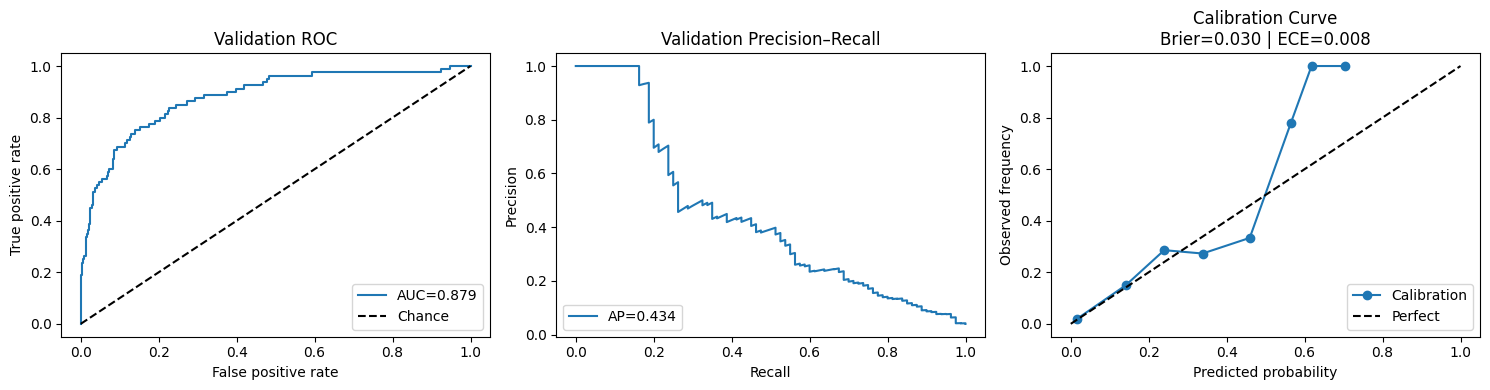

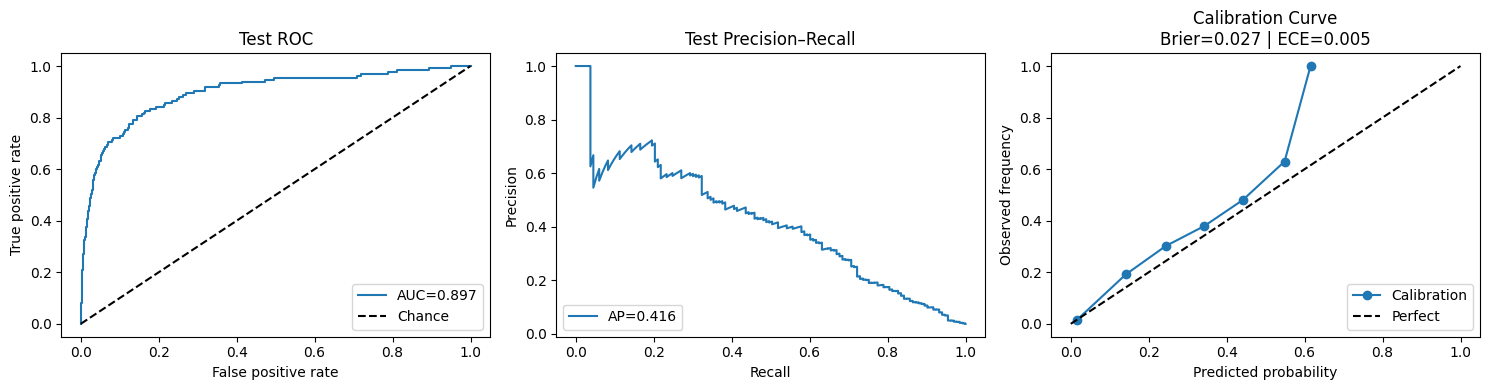

Test metrics @τ:
  ROC-AUC: 0.89654092435082
  PR-AUC : 0.41631277362297275
  F1     : 0.46153846153846156
  Recall : 0.5413533834586466
  Prec   : 0.4022346368715084
📑 Saved calibrated test results → /kaggle/working/results_calibrated.csv
len(idx_map) = 3638 len(X) 3638
💾 Saved hourly preds → /kaggle/working/hourly_predictions_test.csv
💾 Saved daily risk  → /kaggle/working/daily_risk_test.csv

🔎 Hourly predictions (head):
   patientID                hour       date  y_true    y_prob  y_pred  \
0         57 2023-03-23 14:00:00 2023-03-23       0  0.005820       0   
1         57 2023-03-23 15:00:00 2023-03-23       0  0.014100       0   
2         57 2023-03-23 16:00:00 2023-03-23       0  0.025068       0   
3         57 2023-03-23 17:00:00 2023-03-23       0  0.012792       0   
4         57 2023-03-23 18:00:00 2023-03-23       0  0.007407       0   

   threshold_used  
0        0.151307  
1        0.151307  
2        0.151307  
3        0.151307  
4        0.151307  

📊 Daily risk 

In [19]:
# ============================================================
# Leak-safe Ramadan CGM → BiLSTM → Calibrated Threshold → Daily Risk
# with full calibration metrics (ROC, PR, Brier, ECE)
# ============================================================

import os
import random
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    brier_score_loss,
)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# ============================================================
# CONFIG
# ============================================================

# Kaggle paths – change if your files are elsewhere
CSV_INTRADAY_WITH_VISITS = "/kaggle/input/hmcdataset/intraday_with_visits.csv"
STATIC_CSV      = "/kaggle/input/hmc-model-static-variables/outcome_static.csv"
VISIT_WIDE_CSV  = "/kaggle/input/hmc-model-static-variables/outcome_visit_wide_by_variable.csv"
VISIT_LONG_CSV  = "/kaggle/input/hmc-model-static-variables/outcome_visit_long.csv"

OUT_HOURLY_CSV  = "/kaggle/working/dynamic_hourly_features_ramadan.csv"
OUT_SEQ_NPZ     = "/kaggle/working/sequences_leakfree_calibrated.npz"
OUT_RESULTS_CSV = "/kaggle/working/results_calibrated.csv"
OUT_DAILY_RISK  = "/kaggle/working/daily_risk_test.csv"

# Ramadan window
RAMADAN_START = pd.to_datetime("2023-03-22")
RAMADAN_END   = pd.to_datetime("2023-04-19")

HYPO_CUTOFF   = 70.0   # mg/dL
MIN_CGM_PER_H = 4      # minimum CGM readings to keep an hour

SEQ_LEN       = 36     # sliding window length (hours)
RANDOM_STATE  = 42     # 🔑 GLOBAL SEED
USE_STATIC    = True   # include static patient features in the model

# Lifestyle candidates in intraday table
LIFESTYLE_COLS_CANDIDATES = [
    "steps","distance","calories","heart_rate","spo2",
    "deep","light","rem","nap","awake"
]

# Visit-level features you want (per day)
VISIT_COLS = ["carb","meals","total_daily_dose_u","fasting_percent_29"]

# Static features (per patient)
STATIC_COLS = [
    "Age","Gender","BMI","HbA1C","Cholesterol","LDL","HDL","Triglycerides",
    "eGFR","Creatinine","Insulin_units_per_kg","SmartGuard_percent"
]

# Sequence features used by the LSTM
SEQ_FEATURE_COLS = [
    "cgm_mean","cgm_std","pca_cgm1",
    "pc1_activity_energy",
    "carb","meals","total_daily_dose_u","fasting_percent_29"
]


# ============================================================
# REPRO
# ============================================================

def set_seeds(seed=RANDOM_STATE):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()


# ============================================================
# SMALL UTILS
# ============================================================

def to_dt(x):
    return pd.to_datetime(x, errors="coerce", utc=True).dt.tz_convert(None)

def _norm_col(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def _pick_col_flex(df, preferred=None, required=False, name="", any_contains=None):
    cols = list(df.columns)
    norm_map = {c: _norm_col(c) for c in cols}

    # direct match
    if preferred:
        lower_map = {str(p).lower(): p for p in preferred}
        for c in cols:
            if str(c).lower() in lower_map:
                return c

    # fuzzy “contains”
    if any_contains:
        cands = []
        for c, n in norm_map.items():
            if any(_norm_col(tok) in n for tok in any_contains):
                cands.append(c)
        if cands:
            return cands[0]

    if required:
        raise KeyError(f"Could not find column for {name}. Have: {cols}")
    return None

def pick_patient_col(df):
    return _pick_col_flex(
        df,
        preferred=["patientID","PatientID (Huawei Data)","subject_id","id","huaweiID"],
        required=True,
        name="patientID",
        any_contains=["patient","subject","id","huawei"]
    )

def pick_date_col(df):
    return _pick_col_flex(
        df,
        preferred=["date","visit_date","Date","day","timestamp","start"],
        required=True,
        name="date",
        any_contains=["date","visit","day","timestamp","start"]
    )

def safe_encode_gender(s):
    if s.dtype == "object":
        return s.str.strip().str.lower().map({"male":1,"m":1,"female":0,"f":0})
    return pd.to_numeric(s, errors="coerce")

def ensure_numeric(df, ignore=("patientID","huaweiID","visit_assigned","period_main","start","date","hour","hour_of_day")):
    ignore = set(ignore)
    for c in df.columns:
        if c not in ignore:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


# ============================================================
# STATIC + VISIT LOADERS
# ============================================================

def load_static(static_csv=STATIC_CSV):
    if not static_csv or not os.path.exists(static_csv):
        print("⚠️ No static CSV; static features will be zero.")
        return None
    df = pd.read_csv(static_csv)
    pid_col = pick_patient_col(df)
    df = df.rename(columns={pid_col: "patientID"})
    keep = ["patientID"] + [c for c in STATIC_COLS if c in df.columns]
    df = df[keep].drop_duplicates(subset=["patientID"]).copy()
    if "Gender" in df.columns:
        df["Gender"] = safe_encode_gender(df["Gender"])
    for c in keep:
        if c != "patientID":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def load_visit(visit_wide_csv=VISIT_WIDE_CSV, visit_long_csv=VISIT_LONG_CSV):
    # wide preferred
    if visit_wide_csv and os.path.exists(visit_wide_csv):
        wide = pd.read_csv(visit_wide_csv)
        pid_col  = pick_patient_col(wide)
        date_col = pick_date_col(wide)
        wide = wide.rename(columns={pid_col:"patientID", date_col:"date"})
        wide["date"] = pd.to_datetime(wide["date"], errors="coerce").dt.normalize()
        keep = ["patientID","date"] + [c for c in VISIT_COLS if c in wide.columns]
        if len(keep) > 2:
            return wide[keep].copy()
        else:
            print("⚠️ visit_wide found but no desired visit columns; trying LONG…")

    # long → pivot
    if visit_long_csv and os.path.exists(visit_long_csv):
        long = pd.read_csv(visit_long_csv)
        pid_col  = pick_patient_col(long)
        date_col = pick_date_col(long)
        var_col  = _pick_col_flex(long, preferred=["variable","name","measure"], required=True, name="variable")
        val_col  = _pick_col_flex(long, preferred=["value","reading","amount"], required=True, name="value")

        long = long.rename(columns={pid_col:"patientID", date_col:"date", var_col:"variable", val_col:"value"})
        long["date"] = pd.to_datetime(long["date"], errors="coerce").dt.normalize()

        wide = (long
                .pivot_table(index=["patientID","date"], columns="variable", values="value", aggfunc="mean")
                .reset_index())
        keep = ["patientID","date"] + [c for c in VISIT_COLS if c in wide.columns]
        if len(keep) > 2:
            return wide[keep].copy()
        print("⚠️ visit_long has no desired visit variables after pivot.")

    print("⚠️ No usable visit CSV; visit features will be zero.")
    return None


# ============================================================
# HOURLY FEATURES (Ramadan, leak-safe PCA)
# ============================================================

def build_hourly_features():
    if not os.path.exists(CSV_INTRADAY_WITH_VISITS):
        raise FileNotFoundError(CSV_INTRADAY_WITH_VISITS)

    df = pd.read_csv(CSV_INTRADAY_WITH_VISITS)

    # patient
    if "patientID" not in df.columns:
        pid_col = pick_patient_col(df)
        df = df.rename(columns={pid_col: "patientID"})

    # time
    if "start" in df.columns:
        df["start"] = to_dt(df["start"])
        df["date"]  = df["start"].dt.normalize()
        df["hour"]  = df["start"].dt.floor("H")
    else:
        date_col = pick_date_col(df)
        df[date_col] = to_dt(df[date_col])
        df["date"]   = df[date_col].dt.normalize()
        df["hour"]   = df[date_col].dt.floor("H")

    df["hour_of_day"] = df["hour"].dt.hour
    df = ensure_numeric(df)

    # Ramadan filter
    df = df[(df["date"] >= RAMADAN_START) & (df["date"] <= RAMADAN_END)].copy()

    if "cgm" not in df.columns:
        raise ValueError("Dataset must contain 'cgm' column.")

    df_cgm = df.dropna(subset=["cgm"]).copy()

    # keep hours with ≥ MIN_CGM_PER_H
    valid_hours = (
        df_cgm.groupby(["patientID","hour"])
              .filter(lambda g: g["cgm"].notna().sum() >= MIN_CGM_PER_H)
    )

    # basic CGM stats
    hourly = (
        valid_hours.groupby(["patientID","hour"], as_index=False)
                   .agg(
                       cgm_min=("cgm","min"),
                       cgm_max=("cgm","max"),
                       cgm_mean=("cgm","mean"),
                       cgm_std=("cgm","std"),
                   )
                   .sort_values(["patientID","hour"])
                   .reset_index(drop=True)
    )
    hourly["hour_of_day"] = hourly["hour"].dt.hour

    # hypo label (any CBG < 70 in that hour)
    hyp = (
        valid_hours.groupby(["patientID","hour"])["cgm"]
                   .apply(lambda x: int((x < HYPO_CUTOFF).any()))
                   .reset_index(name="hypo_label")
    )
    hourly = hourly.merge(hyp, on=["patientID","hour"], how="left")

    # lifestyle hourly means (if columns exist)
    life_cols = [c for c in LIFESTYLE_COLS_CANDIDATES if c in df_cgm.columns]
    if life_cols:
        life_h = (df_cgm.groupby(["patientID","hour"], as_index=False)[life_cols].mean())
        hourly = hourly.merge(life_h, on=["patientID","hour"], how="left")
    else:
        for c in LIFESTYLE_COLS_CANDIDATES:
            if c not in hourly.columns:
                hourly[c] = 0.0

    # composites
    hourly["cgm_mean_plus_std"]  = hourly["cgm_mean"] + hourly["cgm_std"]
    hourly["cgm_mean_minus_std"] = hourly["cgm_mean"] - hourly["cgm_std"]

    # split patients (train/val/test) – leak-safe
    pids = hourly["patientID"].unique()
    train_p, test_p = train_test_split(pids, test_size=0.2, random_state=RANDOM_STATE)
    train_p, val_p  = train_test_split(train_p, test_size=0.1/(0.8), random_state=RANDOM_STATE)

    def _split(pid):
        if pid in train_p: return "train"
        if pid in val_p:   return "val"
        return "test"

    hourly["Split"] = hourly["patientID"].map(_split)
    hourly["date"]  = hourly["hour"].dt.normalize()

    # PCA on CGM (fit on train only)
    cgm_cols = ["cgm_min","cgm_max","cgm_mean","cgm_std"]
    tr_mask  = (hourly["Split"] == "train")
    scal_cgm = StandardScaler().fit(hourly.loc[tr_mask, cgm_cols])
    pca_cgm  = PCA(n_components=3, random_state=RANDOM_STATE).fit(
        scal_cgm.transform(hourly.loc[tr_mask, cgm_cols])
    )
    Xc = scal_cgm.transform(hourly[cgm_cols])
    Zc = pca_cgm.transform(Xc)
    hourly["pca_cgm1"] = Zc[:,0]
    hourly["pca_cgm2"] = Zc[:,1]
    hourly["pca_cgm3"] = Zc[:,2]
    print("CGM PCA explained variance:", np.round(pca_cgm.explained_variance_ratio_, 3))

    # PCA on lifestyle (fit on train only)
    life_used = [c for c in ["steps","distance","calories","heart_rate","spo2","deep","light","rem","nap","awake"]
                 if c in hourly.columns]
    if life_used:
        scal_life = StandardScaler().fit(hourly.loc[tr_mask, life_used])
        ZL = PCA(n_components=3, random_state=RANDOM_STATE).fit_transform(
            scal_life.transform(hourly[life_used].fillna(0.0))
        )
        hourly["pc1_activity_energy"] = ZL[:,0]
        hourly["pc2_physiology"]      = ZL[:,1]
        hourly["pc3_sleep_rest"]      = ZL[:,2]
    else:
        hourly["pc1_activity_energy"] = 0.0
        hourly["pc2_physiology"]      = 0.0
        hourly["pc3_sleep_rest"]      = 0.0

    # visit features
    visit_df = load_visit()
    if visit_df is not None:
        visit_df["date"] = pd.to_datetime(visit_df["date"], errors="coerce").dt.normalize()
        visit_df = visit_df[(visit_df["date"] >= RAMADAN_START) & (visit_df["date"] <= RAMADAN_END)]
        hourly = hourly.merge(visit_df, on=["patientID","date"], how="left")
    for c in VISIT_COLS:
        if c not in hourly.columns:
            hourly[c] = 0.0
        hourly[c] = pd.to_numeric(hourly[c], errors="coerce").fillna(0.0)

    # static features
    static_df = load_static()
    if static_df is not None:
        hourly = hourly.merge(static_df, on="patientID", how="left")
    for c in STATIC_COLS:
        if c not in hourly.columns:
            hourly[c] = 0.0
        hourly[c] = pd.to_numeric(hourly[c], errors="coerce").fillna(0.0)

    hourly = hourly.sort_values(["patientID","hour"]).reset_index(drop=True)
    hourly.to_csv(OUT_HOURLY_CSV, index=False)
    print(f"✅ Saved hourly features → {OUT_HOURLY_CSV}")
    return hourly


# ============================================================
# SEQUENCES + SCALING
# ============================================================

def build_sequences(hourly, seq_len=SEQ_LEN):
    for col in ["patientID","hour","hypo_label","Split"]:
        if col not in hourly.columns:
            raise KeyError(f"hourly missing '{col}'")

    hourly = hourly.copy()
    hourly["hour"] = pd.to_datetime(hourly["hour"], errors="coerce")
    hourly["date"] = hourly["hour"].dt.normalize()

    missing = [c for c in SEQ_FEATURE_COLS if c not in hourly.columns]
    if missing:
        raise KeyError(f"Missing seq features: {missing}")

    def _pids(split):
        s = hourly["Split"].astype(str).str.lower()
        return np.array(sorted(hourly.loc[s==split, "patientID"].unique()))

    train_p = _pids("train")
    val_p   = _pids("val")
    test_p  = _pids("test")

    static_present = [c for c in STATIC_COLS if c in hourly.columns]
    if USE_STATIC and static_present:
        static_mat = (hourly[["patientID"]+static_present]
                      .drop_duplicates(subset=["patientID"])
                      .set_index("patientID")
                      .astype(float)
                      .fillna(0.0))
    else:
        static_mat = None

    def _build_for(pid_set):
        sub = hourly[hourly["patientID"].isin(pid_set)].copy()
        sub = sub.sort_values(["patientID","hour"]).reset_index(drop=True)

        X_seq, y, X_stat = [], [], []
        for pid, grp in sub.groupby("patientID", sort=True):
            grp = grp.sort_values("hour").reset_index(drop=True)
            if len(grp) <= seq_len:
                continue

            feats  = grp[SEQ_FEATURE_COLS].astype(float).values
            labels = grp["hypo_label"].astype(int).values

            for i in range(len(grp) - seq_len):
                X_seq.append(feats[i:i+seq_len])
                y.append(labels[i+seq_len])
                if USE_STATIC and static_mat is not None:
                    if pid in static_mat.index:
                        X_stat.append(static_mat.loc[pid].values.astype(float))
                    else:
                        X_stat.append(np.zeros(len(static_present), dtype=float))

        X_seq = np.asarray(X_seq, dtype=float)
        y     = np.asarray(y, dtype=int)
        X_stat = np.asarray(X_stat, dtype=float) if (USE_STATIC and static_mat is not None and len(X_stat)>0) else None
        return X_seq, X_stat, y

    Xtr, Str, ytr = _build_for(train_p)
    Xva, Sva, yva = _build_for(val_p)
    Xte, Ste, yte = _build_for(test_p)

    # scale seq features on train only
    seq_scaler = None
    if Xtr.size > 0:
        F = Xtr.shape[2]
        seq_scaler = StandardScaler().fit(Xtr.reshape(-1, F))

        def _scale_seq(X):
            if X is None or X.size == 0:
                return X
            n, T, F_ = X.shape
            return seq_scaler.transform(X.reshape(-1, F_)).reshape(n, T, F_)

        Xtr = _scale_seq(Xtr)
        Xva = _scale_seq(Xva)
        Xte = _scale_seq(Xte)

        # sanity check
        assert Xtr.shape[1] == seq_len, (Xtr.shape, seq_len)

    # scale static
    stat_scaler = None
    if Str is not None and Str.size > 0:
        stat_scaler = StandardScaler().fit(Str)

        def _scale_stat(S):
            if S is None or S.size == 0:
                return S
            return stat_scaler.transform(S)

        Str = _scale_stat(Str)
        Sva = _scale_stat(Sva)
        Ste = _scale_stat(Ste)

    data = {
        "train": {"X_seq": Xtr, "X_stat": Str, "y": ytr},
        "val":   {"X_seq": Xva, "X_stat": Sva, "y": yva},
        "test":  {"X_seq": Xte, "X_stat": Ste, "y": yte},
        "seq_features_used": list(SEQ_FEATURE_COLS),
        "static_features_used": static_present,
        "scalers": {"seq": seq_scaler, "stat": stat_scaler}
    }

    np.savez_compressed(
        OUT_SEQ_NPZ,
        Xtr=Xtr, Xtr_stat=(Str if Str is not None else np.empty((0,0))),
        ytr=ytr,
        Xva=Xva, Xva_stat=(Sva if Sva is not None else np.empty((0,0))),
        yva=yva,
        Xte=Xte, Xte_stat=(Ste if Ste is not None else np.empty((0,0))),
        yte=yte,
        seq_features_used=np.array(SEQ_FEATURE_COLS, dtype=object),
        static_features_used=np.array(static_present, dtype=object)
    )
    print(f"📦 Saved sequences → {OUT_SEQ_NPZ}")
    print("Train/val/test shapes:", Xtr.shape, Xva.shape, Xte.shape)
    print("Train label dist:", Counter(ytr))

    return data


# ============================================================
# MODEL + TRAIN + CALIBRATION
# ============================================================

def make_model(seq_len, n_seq_f, n_stat_f=0, lr=1e-3):
    seq_in = Input(shape=(seq_len, n_seq_f), name="seq_in")
    x = Bidirectional(LSTM(64, return_sequences=True))(seq_in)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation="relu")(x)

    if USE_STATIC and n_stat_f > 0:
        stat_in = Input(shape=(n_stat_f,), name="stat_in")
        s = Dense(16, activation="relu")(stat_in)
        s = Dropout(0.2)(s)
        h = Concatenate()([x, s])
        h = Dense(16, activation="relu")(h)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=[seq_in, stat_in], outputs=out)
    else:
        h = Dense(16, activation="relu")(x)
        out = Dense(1, activation="sigmoid")(h)
        model = Model(inputs=seq_in, outputs=out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

def predict_proba(model, X, S=None):
    if USE_STATIC and S is not None and S.size > 0:
        return model.predict([X, S], verbose=0).ravel()
    return model.predict(X, verbose=0).ravel()

def calibrate_threshold_on_val(y_val, p_val, beta=1.0, thr_min=0.05, thr_max=0.95, default=0.5):
    y_val = np.asarray(y_val).astype(int).ravel()
    p_val = np.asarray(p_val).astype(float).ravel()
    if len(np.unique(y_val)) < 2:
        return float(default)

    prec, rec, thr = precision_recall_curve(y_val, p_val)
    prec, rec = prec[:-1], rec[:-1]
    thr = np.asarray(thr)

    mask = np.isfinite(thr) & (thr >= thr_min) & (thr <= thr_max)
    if not mask.any():
        return float(default)

    beta2 = beta**2
    fbeta = (1 + beta2) * (prec[mask]*rec[mask]) / (beta2*prec[mask] + rec[mask] + 1e-12)
    best_thr = float(thr[mask][np.nanargmax(fbeta)])
    return best_thr

# ---------- Full calibration evaluation (ROC, PR, Brier, ECE + plots) ----------

def evaluate_calibration(y_true, p_pred, n_bins=10, title_prefix="Test"):
    y_true = np.asarray(y_true).astype(int).ravel()
    p_pred = np.asarray(p_pred).astype(float).ravel()

    # ROC & PR
    try:
        roc_auc = roc_auc_score(y_true, p_pred)
    except Exception:
        roc_auc = np.nan
    try:
        pr_auc  = average_precision_score(y_true, p_pred)
    except Exception:
        pr_auc = np.nan

    # Brier score
    try:
        brier = brier_score_loss(y_true, p_pred)
    except Exception:
        brier = np.nan

    # Binning for calibration curve and ECE
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(p_pred, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    prob_true = []
    prob_pred_bin = []
    bin_counts = []

    for b in range(n_bins):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        bin_counts.append(mask.sum())
        prob_true.append(y_true[mask].mean())
        prob_pred_bin.append(p_pred[mask].mean())

    prob_true = np.array(prob_true)
    prob_pred_bin = np.array(prob_pred_bin)
    bin_counts = np.array(bin_counts)
    total = bin_counts.sum() if len(bin_counts) > 0 else 1.0

    ece = 0.0
    if len(bin_counts) > 0:
        ece = np.sum((bin_counts / total) * np.abs(prob_true - prob_pred_bin))

    # Plots: ROC, PR, Calibration
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    # ROC curve
    try:
        fpr, tpr, _ = roc_curve(y_true, p_pred)
        ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
        ax[0].plot([0, 1], [0, 1], "k--", label="Chance")
        ax[0].set_title(f"{title_prefix} ROC")
        ax[0].set_xlabel("False positive rate")
        ax[0].set_ylabel("True positive rate")
        ax[0].legend(loc="lower right")
    except Exception:
        ax[0].set_title(f"{title_prefix} ROC (unavailable)")

    # PR curve
    try:
        prec, rec, _ = precision_recall_curve(y_true, p_pred)
        ax[1].plot(rec, prec, label=f"AP={pr_auc:.3f}")
        ax[1].set_title(f"{title_prefix} Precision–Recall")
        ax[1].set_xlabel("Recall")
        ax[1].set_ylabel("Precision")
        ax[1].legend(loc="lower left")
    except Exception:
        ax[1].set_title(f"{title_prefix} PR (unavailable)")

    # Calibration curve
    if len(prob_pred_bin) > 0:
        ax[2].plot(prob_pred_bin, prob_true, "o-", label="Calibration")
        ax[2].plot([0, 1], [0, 1], "k--", label="Perfect")
        ax[2].set_title(f"Calibration Curve\nBrier={brier:.3f} | ECE={ece:.3f}")
        ax[2].set_xlabel("Predicted probability")
        ax[2].set_ylabel("Observed frequency")
        ax[2].legend(loc="lower right")
    else:
        ax[2].set_title("Calibration (no bins)")

    plt.tight_layout()
    plt.show()

    return {
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc,
        "Brier": brier,
        "ECE": ece,
    }

# ---------- Training + threshold calibration ----------

def train_and_calibrate(data):
    Xtr, Str, ytr = data["train"]["X_seq"], data["train"]["X_stat"], data["train"]["y"]
    Xva, Sva, yva = data["val"]["X_seq"],   data["val"]["X_stat"],   data["val"]["y"]

    seq_len = Xtr.shape[1]
    n_seq_f = Xtr.shape[2]
    n_stat_f = 0 if (Str is None or Str.size == 0) else Str.shape[1]

    model = make_model(seq_len, n_seq_f, n_stat_f=n_stat_f, lr=1e-3)

    es = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1)
    ckpt = "/kaggle/working/bilstm_best.keras"
    mc  = ModelCheckpoint(ckpt, monitor="val_loss", save_best_only=True, verbose=0)

    if USE_STATIC and n_stat_f > 0:
        model.fit(
            [Xtr, Str], ytr,
            validation_data=([Xva, Sva], yva),
            epochs=20, batch_size=64,
            callbacks=[es, mc],
            verbose=1
        )
    else:
        model.fit(
            Xtr, ytr,
            validation_data=(Xva, yva),
            epochs=20, batch_size=64,
            callbacks=[es, mc],
            verbose=1
        )

    model = tf.keras.models.load_model(ckpt)  # best val

    # calibration on VALIDATION (for threshold)
    p_val = predict_proba(model, Xva, Sva)
    tau = calibrate_threshold_on_val(yva, p_val, beta=1.0, thr_min=0.1, thr_max=0.9, default=0.5)
    print(f"🎚️ Calibrated decision threshold τ = {tau:.4f}")

    # Optional: show validation calibration
    print("Validation calibration metrics:")
    _ = evaluate_calibration(yva, p_val, n_bins=10, title_prefix="Validation")

    # quick test metrics
    Xte, Ste, yte = data["test"]["X_seq"], data["test"]["X_stat"], data["test"]["y"]
    p_test = predict_proba(model, Xte, Ste)
    y_pred = (p_test >= tau).astype(int)

    calib_test = evaluate_calibration(yte, p_test, n_bins=10, title_prefix="Test")

    print("Test metrics @τ:")
    print("  ROC-AUC:", calib_test["ROC_AUC"])
    print("  PR-AUC :", calib_test["PR_AUC"])
    print("  F1     :", f1_score(yte, y_pred, zero_division=0))
    print("  Recall :", recall_score(yte, y_pred, zero_division=0))
    print("  Prec   :", precision_score(yte, y_pred, zero_division=0))

    # save simple CSV summary
    os.makedirs(os.path.dirname(OUT_RESULTS_CSV) or ".", exist_ok=True)
    pd.DataFrame([{
        "split": "test",
        "threshold": tau,
        "ROC_AUC": calib_test["ROC_AUC"],
        "PR_AUC": calib_test["PR_AUC"],
        "F1": f1_score(yte, y_pred, zero_division=0),
        "Recall": recall_score(yte, y_pred, zero_division=0),
        "Precision": precision_score(yte, y_pred, zero_division=0),
        "Brier": calib_test["Brier"],
        "ECE": calib_test["ECE"],
    }]).to_csv(OUT_RESULTS_CSV, index=False)
    print(f"📑 Saved calibrated test results → {OUT_RESULTS_CSV}")

    return model, tau


# ============================================================
# SEQUENCE → HOUR MAPPING  (shape-safe)
# ============================================================

def build_sequence_index_map(hourly, split, seq_len):
    h = hourly.copy()
    h["hour"] = pd.to_datetime(h["hour"], errors="coerce")
    h["date"] = h["hour"].dt.normalize()

    s = h["Split"].astype(str).str.lower()
    sub = (h[s==split.lower()]
           .sort_values(["patientID","hour"])
           .reset_index()
           .rename(columns={"index":"row_idx"}))

    rows = []
    for pid, grp in sub.groupby("patientID", sort=True):
        grp = grp.sort_values("hour").reset_index(drop=True)
        if len(grp) <= seq_len:
            continue
        for i in range(len(grp)-seq_len):
            tgt = grp.loc[i+seq_len]
            rows.append({
                "seq_idx": len(rows),
                "patientID": pid,
                "hour": pd.to_datetime(tgt["hour"]),
                "date": pd.to_datetime(tgt["date"]).normalize(),
                "row_idx": int(tgt["row_idx"]),
            })
    return pd.DataFrame(rows)


# ============================================================
# DAILY RISK (using calibrated τ)
# ============================================================

def compute_daily_risk(model, data, hourly, split="test", threshold=0.5):
    X = data[split]["X_seq"]
    S = data[split]["X_stat"]
    y = np.asarray(data[split]["y"]).astype(int).ravel()

    seq_len = X.shape[1]
    p = predict_proba(model, X, S)
    y_pred = (p >= float(threshold)).astype(int)

    idx_map = build_sequence_index_map(hourly, split, seq_len)
    print("len(idx_map) =", len(idx_map), "len(X)", len(X))
    assert len(idx_map) == len(X), "❌ mapping length != #sequences (shape problem)"

    df_hourly = pd.DataFrame({
        "patientID": idx_map["patientID"].values,
        "hour":      pd.to_datetime(idx_map["hour"]),
        # ✅ FIX: keep as Series, then use .dt
        "date":      pd.to_datetime(idx_map["date"]).dt.normalize(),
        "y_true":    y,
        "y_prob":    p,
        "y_pred":    y_pred,
        "threshold_used": float(threshold),
    })

    g = df_hourly.groupby(["patientID","date"], as_index=False)
    df_daily = g.agg(
        n_hours      = ("y_true","size"),
        true_events  = ("y_true","sum"),
        pred_events  = ("y_pred","sum"),
        risk_mean    = ("y_prob","mean"),
        risk_max     = ("y_prob","max"),
    )
    df_daily["daily_true"] = (df_daily["true_events"] > 0).astype(int)
    df_daily["daily_pred"] = (df_daily["risk_max"] >= float(threshold)).astype(int)
    df_daily["threshold_used"] = float(threshold)

    df_hourly.to_csv("/kaggle/working/hourly_predictions_test.csv", index=False)
    df_daily.to_csv(OUT_DAILY_RISK, index=False)
    print(f"💾 Saved hourly preds → /kaggle/working/hourly_predictions_test.csv")
    print(f"💾 Saved daily risk  → {OUT_DAILY_RISK}")

    return df_hourly, df_daily


# ============================================================
# MAIN
# ============================================================

if __name__ == "__main__":
    # 1) Build hourly features
    hourly = build_hourly_features()

    # 2) Build sequences
    data = build_sequences(hourly, seq_len=SEQ_LEN)

    # 3) Train + calibrate threshold on VALIDATION
    model, tau = train_and_calibrate(data)

    # 4) Compute daily risk on TEST using calibrated τ
    df_hourly, df_daily = compute_daily_risk(model, data, hourly, split="test", threshold=tau)

    print("\n🔎 Hourly predictions (head):")
    print(df_hourly.head())

    print("\n📊 Daily risk (head):")
    print(df_daily.head())


Loading model and data artifacts...
Loaded.
  Test shapes: (3638, 36, 8) (seq), (3638, 12) (static)
  Calibrated threshold τ = 0.1513065248727798
Building GradientExplainer with background size = 128

Global importance – sequence features:
               feature  mean_abs_shap
0             pca_cgm1       0.001241
1             cgm_mean       0.000837
2              cgm_std       0.000747
3  pc1_activity_energy       0.000167
4                 carb       0.000000
5                meals       0.000000
6   total_daily_dose_u       0.000000
7   fasting_percent_29       0.000000


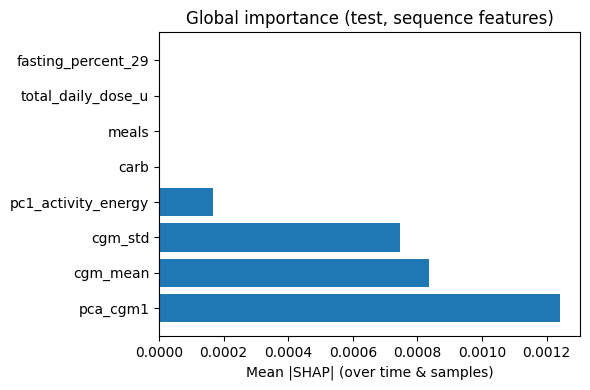


Global importance – static features:
                 feature  mean_abs_shap
0                 Gender       0.002756
1          Triglycerides       0.002575
2     SmartGuard_percent       0.002247
3                    Age       0.001809
4   Insulin_units_per_kg       0.001807
5            Cholesterol       0.001504
6                  HbA1C       0.001401
7             Creatinine       0.001347
8                    LDL       0.001067
9                   eGFR       0.000855
10                   HDL       0.000776
11                   BMI       0.000524


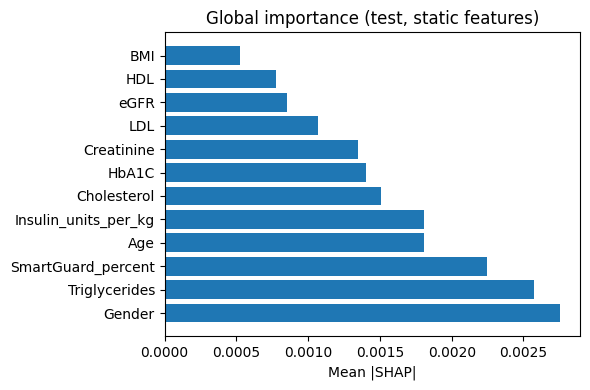


Explaining patient 57 in test split...


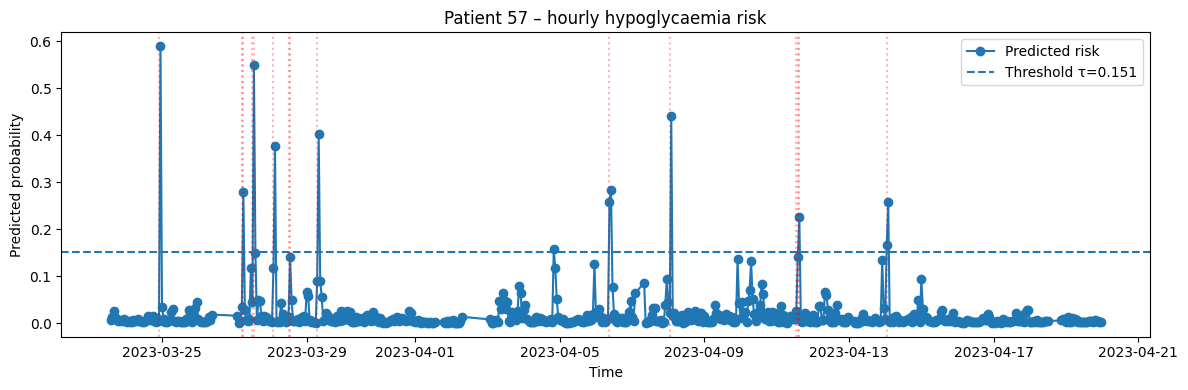

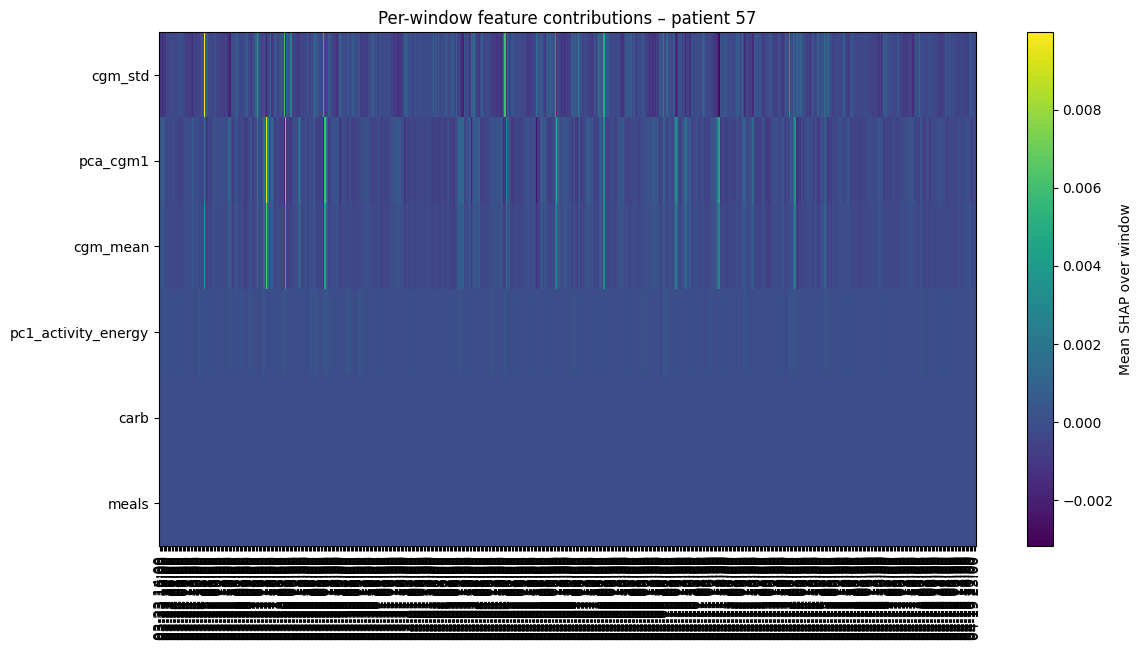


Daily risk stats for example patient:
            n_windows  mean_risk  max_risk  true_events  pred_events
date                                                                
2023-03-23         10   0.009536  0.025068            0            0
2023-03-24         24   0.030642  0.589965            1            1
2023-03-25         24   0.012500  0.044509            0            0
2023-03-26         10   0.006379  0.018252            0            0
2023-03-27         22   0.064031  0.549263            4            2
2023-03-28         24   0.035774  0.377902            3            1
2023-03-29         24   0.037604  0.402134            1            1
2023-03-30         24   0.010461  0.025505            0            0
2023-03-31         24   0.007212  0.025108            0            0
2023-04-01         19   0.002418  0.007256            0            0
2023-04-02          8   0.003898  0.013623            0            0
2023-04-03         22   0.024204  0.078549            0         

In [20]:
# ============================================================
# SHAP explainability for leak-safe Ramadan BiLSTM
#
# Fixes:
#   * Works with TF 2.15/2.16 + Keras 3 by monkey‑patching
#     tf.keras.backend.learning_phase / set_learning_phase,
#     which SHAP's GradientExplainer still calls.
#
# Assumes you have already run the training script and created:
#   /kaggle/working/bilstm_best.keras
#   /kaggle/working/sequences_leakfree_calibrated.npz
#   /kaggle/working/dynamic_hourly_features_ramadan.csv
#   /kaggle/working/results_calibrated.csv
# ============================================================

import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import shap

# ------------------------------------------------------------
# SHAP / KERAS 3 COMPAT PATCH
# ------------------------------------------------------------
# Keras 3 removed backend.learning_phase & set_learning_phase,
# but shap.GradientExplainer still uses them. We add light
# stand‑ins to avoid AttributeError without changing behavior
# in practice (we always evaluate in inference mode).
#
# This MUST run before calling shap.GradientExplainer.shap_values().
# ------------------------------------------------------------

if not hasattr(tf.keras.backend, "learning_phase"):
    # SHAP expects this to be callable
    def _fake_learning_phase():
        # 0 -> inference / test mode
        return 0
    tf.keras.backend.learning_phase = _fake_learning_phase

if not hasattr(tf.keras.backend, "set_learning_phase"):
    # SHAP uses this as a context switch; we can no‑op safely
    def _fake_set_learning_phase(value):
        # value is usually 0 or 1; we ignore it
        return None
    tf.keras.backend.set_learning_phase = _fake_set_learning_phase


# ------------------------------------------------------------
# CONFIG + SEED
# ------------------------------------------------------------

RANDOM_STATE = 42          # 🔑 keep same seed as training
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

USE_STATIC      = True     # same as in training

OUT_SEQ_NPZ     = "/kaggle/working/sequences_leakfree_calibrated.npz"
OUT_HOURLY_CSV  = "/kaggle/working/dynamic_hourly_features_ramadan.csv"
OUT_RESULTS_CSV = "/kaggle/working/results_calibrated.csv"
MODEL_CKPT      = "/kaggle/working/bilstm_best.keras"


# ------------------------------------------------------------
# LOAD MODEL + DATA
# ------------------------------------------------------------

print("Loading model and data artifacts...")
model = tf.keras.models.load_model(MODEL_CKPT)

npz = np.load(OUT_SEQ_NPZ, allow_pickle=True)

Xtr = npz["Xtr"]
Xva = npz["Xva"]
Xte = npz["Xte"]

Xtr_stat = npz["Xtr_stat"]
Xva_stat = npz["Xva_stat"]
Xte_stat = npz["Xte_stat"]

ytr = npz["ytr"]
yva = npz["yva"]
yte = npz["yte"]

seq_features_used    = npz["seq_features_used"].tolist()
static_features_used = npz["static_features_used"].tolist()


def _maybe_static(arr: np.ndarray):
    """Convert empty (0,0) static arrays to None for convenience."""
    if arr.ndim != 2:
        return None
    if arr.shape[0] == 0 or arr.shape[1] == 0:
        return None
    return arr


Xtr_stat = _maybe_static(Xtr_stat)
Xva_stat = _maybe_static(Xva_stat)
Xte_stat = _maybe_static(Xte_stat)

data = {
    "train": {"X_seq": Xtr, "X_stat": Xtr_stat, "y": ytr},
    "val":   {"X_seq": Xva, "X_stat": Xva_stat, "y": yva},
    "test":  {"X_seq": Xte, "X_stat": Xte_stat, "y": yte},
    "seq_features_used": seq_features_used,
    "static_features_used": static_features_used,
}

hourly  = pd.read_csv(OUT_HOURLY_CSV)
results = pd.read_csv(OUT_RESULTS_CSV)
tau = float(results["threshold"].iloc[0])

print("Loaded.")
print("  Test shapes:", Xte.shape, "(seq),",
      "None" if Xte_stat is None else Xte_stat.shape, "(static)")
print("  Calibrated threshold τ =", tau)


# ------------------------------------------------------------
# SMALL HELPERS
# ------------------------------------------------------------

def predict_proba(model, X, S=None):
    """Return model probabilities with/without static input."""
    if USE_STATIC and S is not None:
        return model.predict([X, S], verbose=0).ravel()
    return model.predict(X, verbose=0).ravel()


def build_sequence_index_map(hourly_df: pd.DataFrame, split: str, seq_len: int):
    """
    Rebuild mapping from sequence index (within split) → (patientID, hour, date)
    Must be consistent with how sequences were built for training.

    For each patient:
      - sort by hour
      - create sliding windows of length `seq_len`
      - predict at the next hour after the window
    """
    h = hourly_df.copy()
    h["hour"] = pd.to_datetime(h["hour"], errors="coerce")
    h["date"] = pd.to_datetime(h["date"], errors="coerce").dt.normalize()

    s = h["Split"].astype(str).str.lower()
    sub = (h[s == split.lower()]
           .sort_values(["patientID", "hour"])
           .reset_index()
           .rename(columns={"index": "row_idx"}))

    rows = []
    for pid, grp in sub.groupby("patientID", sort=True):
        grp = grp.sort_values("hour").reset_index(drop=True)
        if len(grp) <= seq_len:
            continue
        for i in range(len(grp) - seq_len):
            tgt = grp.loc[i + seq_len]
            rows.append({
                "seq_idx": len(rows),
                "patientID": pid,
                "hour": pd.to_datetime(tgt["hour"]),
                "date": pd.to_datetime(tgt["date"]).normalize(),
                "row_idx": int(tgt["row_idx"]),
            })
    return pd.DataFrame(rows)


def _unpack_shap_values(shap_values, has_static: bool):
    """
    Handle SHAP output structures for GradientExplainer, supporting:
      * single-input, single-output
      * multi-input (seq + static), single-output

    For multi-input we might get:
        [seq_array, static_array]
    or:
        [[seq_array, static_array]]  (one output, two inputs)
    """
    # Multi-input case: sequence + static
    if has_static:
        if not isinstance(shap_values, list) or len(shap_values) == 0:
            raise ValueError("Unexpected SHAP structure for multi-input model.")

        first = shap_values[0]

        # Case: [[seq, static]] (list of outputs, here 1 output)
        if isinstance(first, list):
            input_vals = first
        # Case: [seq, static] (direct list of inputs)
        elif isinstance(first, np.ndarray):
            input_vals = shap_values
        else:
            raise ValueError("Unexpected nested SHAP structure for multi-input model.")

        shap_seq = np.array(input_vals[0])
        shap_stat = np.array(input_vals[1]) if len(input_vals) > 1 else None

    # Single-input case: only sequence features
    else:
        if isinstance(shap_values, list):
            if len(shap_values) == 1 and isinstance(shap_values[0], np.ndarray):
                shap_seq = np.array(shap_values[0])
            else:
                # If multiple outputs, just take the first one
                first = shap_values[0]
                if isinstance(first, np.ndarray):
                    shap_seq = np.array(first)
                else:
                    raise ValueError("Unexpected SHAP structure for single-input model.")
        else:
            shap_seq = np.array(shap_values)

        shap_stat = None

    return shap_seq, shap_stat


# ------------------------------------------------------------
# SHAP EXPLAINER
# ------------------------------------------------------------

def build_shap_explainer(model, data, bg_split="train", bg_size=128):
    """
    Build GradientExplainer with a small background set from the training split.

    This uses our Keras‑3‑compatible monkey‑patch above to avoid
    the tf.keras.backend.learning_phase() AttributeError.
    """
    X_bg = data[bg_split]["X_seq"]
    S_bg = data[bg_split]["X_stat"]

    n_bg = len(X_bg)
    if bg_size is not None and n_bg > bg_size:
        idx = np.random.choice(n_bg, size=bg_size, replace=False)
        X_bg = X_bg[idx]
        if S_bg is not None:
            S_bg = S_bg[idx]

    if USE_STATIC and S_bg is not None:
        background = [X_bg, S_bg]
    else:
        background = X_bg

    print(f"Building GradientExplainer with background size = {len(X_bg)}")
    explainer = shap.GradientExplainer(model, background)
    return explainer


# ------------------------------------------------------------
# GLOBAL SHAP (overall feature importance)
# ------------------------------------------------------------

def global_shap(explainer, data, split="test", nsamples=256):
    """
    Compute global SHAP importance for sequence and static features.
    Sequence SHAP is aggregated over time (sequence length) and samples.
    """
    X = data[split]["X_seq"]
    S = data[split]["X_stat"]
    n = len(X)

    if nsamples is not None and n > nsamples:
        idx = np.random.choice(n, size=nsamples, replace=False)
        X_sample = X[idx]
        S_sample = S[idx] if S is not None else None
    else:
        X_sample = X
        S_sample = S

    # GradientExplainer with multi-input returns nested lists for outputs/inputs.
    if USE_STATIC and S_sample is not None:
        raw_shap = explainer.shap_values([X_sample, S_sample])
        shap_seq, shap_stat = _unpack_shap_values(raw_shap, has_static=True)
    else:
        raw_shap = explainer.shap_values(X_sample)
        shap_seq, shap_stat = _unpack_shap_values(raw_shap, has_static=False)

    # ---- sequence features: aggregate over time + samples ----
    seq_feat_names = data["seq_features_used"]
    # shap_seq shape: (N, T, F_seq)
    mean_abs_seq = np.abs(shap_seq).mean(axis=(0, 1))
    df_seq_imp = (
        pd.DataFrame({
            "feature": seq_feat_names,
            "mean_abs_shap": mean_abs_seq
        })
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )

    print("\nGlobal importance – sequence features:")
    print(df_seq_imp)

    plt.figure(figsize=(6, 4))
    plt.barh(df_seq_imp["feature"], df_seq_imp["mean_abs_shap"])
    plt.xlabel("Mean |SHAP| (over time & samples)")
    plt.title(f"Global importance ({split}, sequence features)")
    plt.tight_layout()
    plt.show()

    # ---- static features (if present) ----
    df_stat_imp = None
    if shap_stat is not None and len(data["static_features_used"]) > 0:
        stat_feat_names = data["static_features_used"]
        # shap_stat shape: (N, F_stat)
        mean_abs_stat = np.abs(shap_stat).mean(axis=0)
        df_stat_imp = (
            pd.DataFrame({
                "feature": stat_feat_names,
                "mean_abs_shap": mean_abs_stat
            })
            .sort_values("mean_abs_shap", ascending=False)
            .reset_index(drop=True)
        )

        print("\nGlobal importance – static features:")
        print(df_stat_imp)

        plt.figure(figsize=(6, 4))
        plt.barh(df_stat_imp["feature"], df_stat_imp["mean_abs_shap"])
        plt.xlabel("Mean |SHAP|")
        plt.title(f"Global importance ({split}, static features)")
        plt.tight_layout()
        plt.show()

    return {
        "X_sample": X_sample,
        "S_sample": S_sample,
        "shap_seq": shap_seq,
        "shap_stat": shap_stat,
        "seq_importance": df_seq_imp,
        "static_importance": df_stat_imp,
    }


# ------------------------------------------------------------
# PATIENT-LEVEL SHAP
# ------------------------------------------------------------

def explain_patient(explainer, model, data, hourly_df, split, patient_id, threshold):
    """
    Get SHAP explanations and predictions for all sequences
    belonging to a single patient in a given split.
    """
    X = data[split]["X_seq"]
    S = data[split]["X_stat"]
    y = data[split]["y"].astype(int).ravel()

    idx_map = build_sequence_index_map(hourly_df, split=split, seq_len=X.shape[1])
    sub = idx_map[idx_map["patientID"] == patient_id].copy()
    if sub.empty:
        raise ValueError(f"No sequences found for patientID={patient_id} in split {split}.")

    seq_idx = sub["seq_idx"].astype(int).values

    X_p = X[seq_idx]
    S_p = S[seq_idx] if S is not None else None
    y_true = y[seq_idx]

    p = predict_proba(model, X_p, S_p)
    y_pred = (p >= float(threshold)).astype(int)

    # SHAP values for this patient's sequences
    if USE_STATIC and S_p is not None:
        raw_shap = explainer.shap_values([X_p, S_p])
        shap_seq, shap_stat = _unpack_shap_values(raw_shap, has_static=True)
    else:
        raw_shap = explainer.shap_values(X_p)
        shap_seq, shap_stat = _unpack_shap_values(raw_shap, has_static=False)

    df_p = (
        pd.DataFrame({
            "seq_idx": seq_idx,
            "patientID": sub["patientID"].values,
            "hour": pd.to_datetime(sub["hour"].values),
            "date": pd.to_datetime(sub["date"].values).normalize(),
            "y_true": y_true,
            "y_prob": p,
            "y_pred": y_pred,
        })
        .sort_values("hour")
        .reset_index(drop=True)
    )

    return df_p, shap_seq, shap_stat


def plot_patient_risk_timeline(df_p, threshold, title=None):
    """
    Plot predicted risk over time for one patient, with threshold
    and vertical lines at true hypo hours.
    """
    t = df_p["hour"]
    risk = df_p["y_prob"]
    hypo = df_p["y_true"] == 1

    if title is None:
        pid = df_p["patientID"].iloc[0]
        title = f"Patient {pid} – hourly hypoglycaemia risk"

    plt.figure(figsize=(12, 4))
    plt.plot(t, risk, marker="o", label="Predicted risk")
    plt.axhline(threshold, linestyle="--", label=f"Threshold τ={threshold:.3f}")
    for ts in t[hypo]:
        plt.axvline(ts, linestyle=":", alpha=0.3, color="red")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Predicted probability")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_patient_shap_heatmap(df_p, shap_seq, seq_feature_names, top_k=6):
    """
    Heatmap: x-axis = sequences (time), y-axis = features,
    values = mean SHAP over window for each feature.
    """
    # shap_seq shape: (n_seq, seq_len, n_feat)
    shap_agg = shap_seq.mean(axis=1)  # (n_seq, n_feat)

    mean_abs = np.abs(shap_agg).mean(axis=0)
    # pick top_k features by global mean |SHAP|
    top_idx = np.argsort(mean_abs)[::-1][:top_k]
    shap_top = shap_agg[:, top_idx]
    feat_top = [seq_feature_names[i] for i in top_idx]

    plt.figure(figsize=(12, 0.6 * top_k + 3))
    plt.imshow(shap_top.T, aspect="auto", interpolation="nearest")
    plt.colorbar(label="Mean SHAP over window")
    plt.yticks(range(len(feat_top)), feat_top)
    plt.xticks(
        range(len(df_p)),
        df_p["hour"].dt.strftime("%m-%d %H:%M"),
        rotation=90
    )
    pid = df_p["patientID"].iloc[0]
    plt.title(f"Per-window feature contributions – patient {pid}")
    plt.tight_layout()
    plt.show()


def build_daily_shap_summary(df_p, shap_seq, seq_feature_names, top_k=5):
    """
    Daily risk stats + daily mean |SHAP| for top-k sequence features.
    """
    df = df_p.copy()
    df["date"] = df["hour"].dt.normalize()

    daily_stats = df.groupby("date").agg(
        n_windows=("y_prob", "size"),
        mean_risk=("y_prob", "mean"),
        max_risk=("y_prob", "max"),
        true_events=("y_true", "sum"),
        pred_events=("y_pred", "sum"),
    )

    # aggregate SHAP per sequence (mean over time), then per day
    shap_agg = shap_seq.mean(axis=1)  # (n_seq, n_feat)
    shap_df = pd.DataFrame(shap_agg, columns=seq_feature_names)
    shap_df["date"] = df["date"].values

    mean_abs_global = np.abs(shap_agg).mean(axis=0)
    top_idx = np.argsort(mean_abs_global)[::-1][:top_k]
    top_features = [seq_feature_names[i] for i in top_idx]

    daily_shap = shap_df.groupby("date")[top_features].apply(
        lambda g: np.abs(g).mean(axis=0)
    )

    return daily_stats, daily_shap


# ------------------------------------------------------------
# MAIN
# ------------------------------------------------------------

if __name__ == "__main__":
    # 1) Build SHAP explainer on training background
    explainer = build_shap_explainer(model, data, bg_split="train", bg_size=128)

    # 2) Global SHAP on test set
    global_info = global_shap(explainer, data, split="test", nsamples=256)

    # 3) Example patient from test split
    test_mask = hourly["Split"].astype(str).str.lower() == "test"
    test_pids = hourly.loc[test_mask, "patientID"].unique()

    if len(test_pids) > 0:
        example_pid = test_pids[0]
        print(f"\nExplaining patient {example_pid} in test split...")

        df_p, shap_seq_p, shap_stat_p = explain_patient(
            explainer,
            model,
            data,
            hourly_df=hourly,
            split="test",
            patient_id=example_pid,
            threshold=tau,
        )

        # risk timeline
        plot_patient_risk_timeline(df_p, threshold=tau)

        # SHAP heatmap over time
        plot_patient_shap_heatmap(df_p, shap_seq_p, data["seq_features_used"], top_k=6)

        # per-day risk + SHAP summaries
        daily_stats, daily_shap = build_daily_shap_summary(
            df_p, shap_seq_p, data["seq_features_used"], top_k=5
        )
        print("\nDaily risk stats for example patient:")
        print(daily_stats)

        print("\nDaily mean |SHAP| for top sequence features:")
        print(daily_shap)
    else:
        print("No patients in test split. Check hourly['Split'] values.")
